#### Installing libraries that are not there in COLLAB

In [1]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.1 MB/s eta 0:00:00


In [2]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 7.5 MB/s eta 0:00:00


In [3]:
!pip install pandarallel

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 4.4 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=5d6f30c33cbc5401d9731fc435d013c08d6f479d4224ecde95ffc24a3bf22582
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel


#### Loading drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing reqd. libraries.

In [5]:
SEED_VAL = 100
# common libs
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import cv2
import math
import random
import os
import pickle
import shutil
import gc
from IPython.display import Markdown, display
from pandarallel import pandarallel

from joblib import Parallel, delayed


# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

# utility lib
import zipfile
from glob import glob
import itertools
from tqdm import tqdm

# ML libs
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.utils import class_weight

# NN libs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, SeparableConv2D, MaxPool2D, LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import visualkeras

#dicom image utility
import pydicom as dicom

# set seeds
tf.random.set_seed(SEED_VAL)
np.random.seed(SEED_VAL)
random.seed(SEED_VAL)

# other settings
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

print(f'TF Version {tf.__version__}')
print(f'Available processors {tf.config.list_physical_devices()}')


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 10000)

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
TF Version 2.14.0
Available processors [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Milestone -1

## Step 1:  Import the data

In [ ]:
TRAIN_IMG_PATH = 'CAPSTONE_PROJECT_TRAIN'
img_file = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/stage_2_train_images.zip'
with zipfile.ZipFile(img_file,"r") as zip_ref:
    zip_ref.extractall(TRAIN_IMG_PATH)
TRAIN_IMG_PATH = os.path.sep.join([os.getcwd(),TRAIN_IMG_PATH,'stage_2_train_images'])
print(TRAIN_IMG_PATH)

In [ ]:
TEST_IMG_PATH = 'CAPSTONE_PROJECT_TEST'
img_file = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/stage_2_test_images.zip'
with zipfile.ZipFile(img_file,"r") as zip_ref:
    zip_ref.extractall(TEST_IMG_PATH)
TEST_IMG_PATH = os.path.sep.join([os.getcwd(),TEST_IMG_PATH,'stage_2_test_images'])
print(TEST_IMG_PATH)

/content/CAPSTONE_PROJECT_TEST/stage_2_test_images


In [ ]:
image_labels_df = pd.merge(left = pd.read_csv('/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/stage_2_train_labels.csv'),
                           right = pd.read_csv('/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/stage_2_detailed_class_info.csv'),
                           left_on = 'patientId',
                           right_on = 'patientId',
                           how = 'inner')

In [ ]:
image_labels_df.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

**File descriptions**

* **stage_2_train.csv** - the training set. Contains patientIds and bounding box / target information.

* **stage_2_sample_submission.csv** - a sample submission file in the correct format. Contains patientIds for the test set. Note that the sample submission contains one box per image, but there is no limit to the number of bounding boxes that can be assigned to a given image.

* **stage_2_detailed_class_info.csv** - provides detailed information about the type of positive or negative class for each image.

* **stage_2_train_images.zip** - Contains Dicom images that be used for training the algorithm. These images have target and class mappings available.

* **stage_2_test_images.zip** - Test Dicom images but without Target / Class label mapping

**Data fields**

* patientId - A patientId. Each patientId corresponds to a unique image.
* x - the upper-left x coordinate of the bounding box.
* y - the upper-left y coordinate of the bounding box.
* width - the width of the bounding box.
* height - the height of the bounding box.
* Target - the binary Target, indicating whether this sample has evidence of pneumonia.
* class - One of 'Lung Opacity' , 'Normal' or 'No Lung Opacity / Not Normal'

## Step 2: Map training and testing images to its classes.

In [ ]:
def readMetaData(file):
  data_img = dicom.read_file(file)
  patientid = data_img.PatientID
  sex = data_img.PatientSex
  age = int(data_img.PatientAge)
  bodypartexamined = data_img.BodyPartExamined
  viewposition = data_img.ViewPosition
  modality = data_img.Modality
  img_height = data_img.Rows
  img_width = data_img.Columns
  return patientid, sex, age, bodypartexamined, viewposition, modality, img_height, img_width

In [ ]:
# get image path and patient ids for training data
df_train_data = pd.DataFrame()
df_train_data['img_path'] = glob(os.path.join(TRAIN_IMG_PATH, '*.dcm'))
(df_train_data['patientId'], df_train_data['sex'],
 df_train_data['age'], df_train_data['bodypartexamined'],
 df_train_data['viewposition'], df_train_data['modality'],
 df_train_data['img_height'], df_train_data['img_width']) = zip(*df_train_data['img_path'].progress_apply(lambda x : readMetaData(x)))


# get image path and patient ids for test data
df_test_data = pd.DataFrame()
df_test_data['img_path'] = glob(os.path.join(TEST_IMG_PATH, '*.dcm'))
(df_test_data['patientId'], df_test_data['sex'],
 df_test_data['age'], df_test_data['bodypartexamined'],
 df_test_data['viewposition'], df_test_data['modality'],
 df_test_data['img_height'], df_test_data['img_width']) = zip(*df_test_data['img_path'].progress_apply(lambda x : readMetaData(x)))


100%|██████████| 3000/3000 [00:02<00:00, 1232.48it/s]


## Step 3 :Map training and testing images to its annotations. [ 4 points ]

In [ ]:
df_train_data = pd.merge(left = image_labels_df,
                         right = df_train_data,
                         left_on = 'patientId',
                         right_on = 'patientId',
                         how = 'inner')
df_train_data.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  \
0  No Lung Opacity / Not Normal   
1  No Lung Opacity / Not Normal   
2  No Lung Opacity / Not Normal   
3                        Normal   
4                  Lung Opacity   

                                            img_path sex  age  \
0  /content/CAPSTONE_PROJECT_TRAIN/stage_2_train_...   F   51   
1  /content/CAPSTONE_PROJECT_TRAIN/stage_2_train_...   F   48   
2  /content/CAPSTONE_PROJECT_TRAIN/stage_2_train_...   M   19   
3  /content/CAPSTONE_PROJECT_TRAIN/stage_2_train_...   M   28   
4  /content/CAPSTONE_PROJECT_TRAIN/stage_2_train_...   F   32   

  bodypartexamined viewposition modality  img_height  img_width  
0            CHEST           PA       CR        1024       1024  
1            CHEST           PA       CR        1024       1024  
2            CHEST           AP       CR        1024       1024  
3            CHEST           PA       CR        1024       1024  
4            CHEST           AP       CR        1024       1024

In [ ]:
df_train_data['centroid_x'] = df_train_data['x'] + df_train_data['width'] / 2
df_train_data['centroid_y'] = df_train_data['y'] + df_train_data['height'] / 2

## Step 4: Preprocessing and Visualisation of different classes [4 Points]

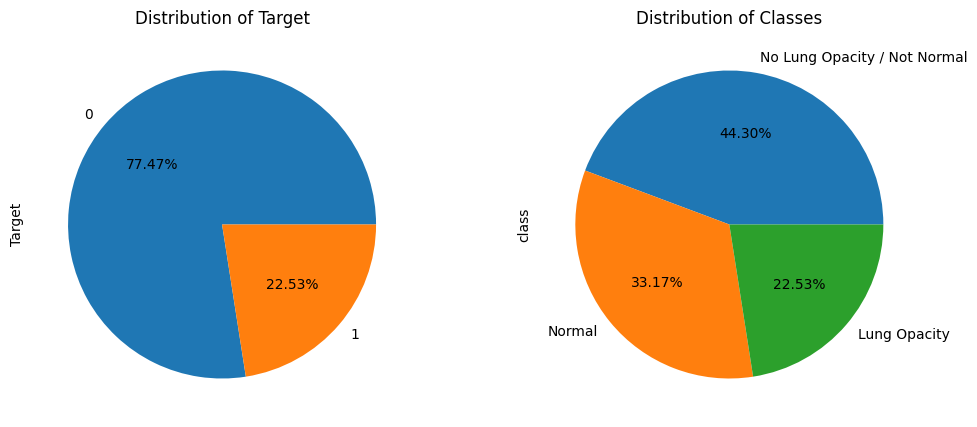

In [ ]:
fig, ax = plt.subplots(1,2,  figsize=(12,5))
df_train_data.drop_duplicates(subset='patientId')['Target'].value_counts().plot.pie(autopct='%.2f%%',ax=ax[0])
ax[0].set_title('Distribution of Target')
df_train_data.drop_duplicates(subset='patientId')['class'].value_counts().plot.pie(autopct='%.2f%%',ax=ax[1])
ax[1].set_title('Distribution of Classes')
plt.show()

* There is imbalance in data, target 1 (Pneumonia positive) is a minority target.
* the distribution of class is most equal between 3 classes.

In [ ]:
df_train_data.drop_duplicates(subset='patientId').pivot_table(values='sex',index='Target',columns='class',aggfunc=len,fill_value=0)

class   Lung Opacity  No Lung Opacity / Not Normal  Normal
Target                                                    
0                  0                         11821    8851
1               6012                             0       0

Above table shows the distribution of classes within the target values

In [ ]:
print(f'Training Image height - Min {df_train_data.img_height.min()} Max {df_train_data.img_height.max()} avg {df_train_data.img_height.mean()}')
print(f'Training Image width - Min {df_train_data.img_width.min()} Max {df_train_data.img_width.max()} avg {df_train_data.img_height.mean()}')

print(f'Test Image height - Min {df_test_data.img_height.min()} Max {df_test_data.img_height.max()} avg {df_test_data.img_height.mean()}')
print(f'Test Image width - Min {df_test_data.img_width.min()} Max {df_test_data.img_width.max()} avg {df_test_data.img_height.mean()}')

Training Image height - Min 1024 Max 1024 avg 1024.0
Training Image width - Min 1024 Max 1024 avg 1024.0
Test Image height - Min 1024 Max 1024 avg 1024.0
Test Image width - Min 1024 Max 1024 avg 1024.0


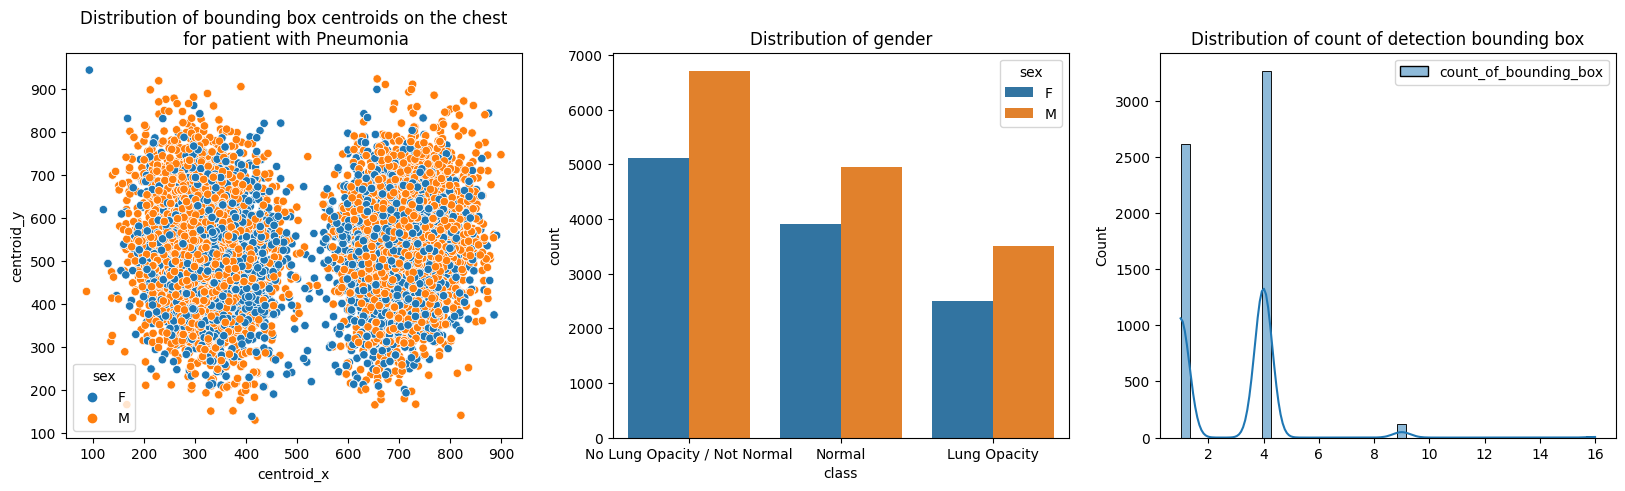

In [ ]:
fig, ax = plt.subplots(1,3,  figsize=(20,5))
sns.scatterplot(df_train_data.dropna(subset=['centroid_x','centroid_y']),x='centroid_x',y='centroid_y',hue='sex',ax=ax[0])
ax[0].set_title('Distribution of bounding box centroids on the chest\n for patient with Pneumonia')
sns.countplot(df_train_data.drop_duplicates(subset=['patientId']),x='class',hue='sex',ax=ax[1])
ax[1].set_title('Distribution of gender')
temp = df_train_data.loc[df_train_data.Target==1,:].groupby(by='patientId').agg({'Target':len})
temp.columns = ['count_of_bounding_box']
sns.histplot(temp,kde=True, ax=ax[2])
ax[2].set_title('Distribution of count of detection bounding box')
plt.show()

Observation
1. the lung opacity is quite evenly distributed in both side of the lung.
2. out of the persons who have pneumonia female have lower number of confirmed case.
3. there are at most 16 bounding boxes on a image, where most images have 4 bounding box.

## Step 5: Display images with bounding box. [ 5 points ]

In [ ]:
# dont run it if re-running this code
pickle.dump(df_train_data, open(r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/df_train_data.pkl','wb'))
pickle.dump(df_test_data, open(r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/df_test_data.pkl','wb'))

In [6]:
df_train_data = pickle.load(open(r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/df_train_data.pkl','rb'))
df_test_data = pickle.load(open(r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/df_test_data.pkl','rb'))

In [7]:
print(f'Number of training images - {df_train_data.patientId.drop_duplicates().shape[0]} and number of test images - {df_test_data.patientId.drop_duplicates().shape[0]}')

Number of training images - 26684 and number of test images - 3000


In [8]:

# copy data from google drive to local disk
PATH = 'JPG_FILES_TEST'
img_file = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/JPG_IMG_TEST.zip'
with zipfile.ZipFile(img_file,"r") as zip_ref:
    zip_ref.extractall(PATH)

In [9]:
JPG_FILES_TEST  = '/content/JPG_FILES_TEST/JPG_IMG_TEST'
jpg_file_path = glob(os.path.join(JPG_FILES_TEST, '*.jpg'))
patientIdsFound = [x.split('/')[-1].split('.')[0] for x in jpg_file_path]
df = pd.DataFrame({'patientId':patientIdsFound,
                   'jpg_file_path':jpg_file_path})
if len(set(df_test_data.patientId) - set(patientIdsFound))>0 or len(set(patientIdsFound) - set(df_test_data.patientId))>0:
  raise Exception('File missing')
else:
  df_test_data = pd.merge(left = df_test_data,
                          right = df,
                          left_on = 'patientId',
                          right_on = 'patientId',
                          how = 'inner')
df_test_data.head()

img_path                             patientId sex  age bodypartexamined viewposition modality  img_height  img_width                                      jpg_file_path
0  /content/CAPSTONE_PROJECT_TEST/stage_2_test_im...  23606f99-638f-4a8a-94a2-9f6288a87d07   F   56            CHEST           AP       CR        1024       1024  /content/JPG_FILES_TEST/JPG_IMG_TEST/23606f99-...
1  /content/CAPSTONE_PROJECT_TEST/stage_2_test_im...  211f242e-8f05-4307-bf14-dcb8270dda7b   M   42            CHEST           AP       CR        1024       1024  /content/JPG_FILES_TEST/JPG_IMG_TEST/211f242e-...
2  /content/CAPSTONE_PROJECT_TEST/stage_2_test_im...  2767048d-aef9-4a2d-be21-f8009f4f9b7e   M   27            CHEST           AP       CR        1024       1024  /content/JPG_FILES_TEST/JPG_IMG_TEST/2767048d-...
3  /content/CAPSTONE_PROJECT_TEST/stage_2_test_im...  3135b442-13ea-496f-b5ba-e0e074494c16   F   42            CHEST           PA       CR        1024       1024  /content/JPG_FILES_TEST/JPG_IMG_TEST/3135b442-...
4  /content/CAPSTONE_PROJECT_TEST/stage_2_test_im...  276f3471-858d-4856-a0e2-1106a92175c0   F   46            CHEST           AP       CR        1024       1024  /content/JPG_FILES_TEST/JPG_IMG_TEST/276f3471-...

In [10]:
# copy data from google drive to local disk
PATH = 'JPG_FILES_TRAIN'
img_file = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/JPG_IMG_TRAIN.zip'
with zipfile.ZipFile(img_file,"r") as zip_ref:
    zip_ref.extractall(PATH)

In [11]:
JPG_FILES_TRAIN  = '/content/JPG_FILES_TRAIN/JPG_IMG_TRAIN'
jpg_file_path = glob(os.path.join(JPG_FILES_TRAIN, '*.jpg'))
patientIdsFound = [x.split('/')[-1].split('.')[0] for x in jpg_file_path]
df = pd.DataFrame({'patientId':patientIdsFound,
                   'jpg_file_path':jpg_file_path})
if len(set(df_train_data.patientId) - set(patientIdsFound))>0 or len(set(patientIdsFound) - set(df_train_data.patientId))>0:
  raise Exception('File missing')
else:
  df_train_data = pd.merge(left = df_train_data,
                          right = df,
                          left_on = 'patientId',
                          right_on = 'patientId',
                          how = 'inner')
df_train_data.head()

patientId      x      y  width  height  Target                         class                                           img_path sex  age bodypartexamined viewposition modality  img_height  img_width  centroid_x  centroid_y                                      jpg_file_path
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0  No Lung Opacity / Not Normal  /content/CAPSTONE_PROJECT_TRAIN/stage_2_train_...   F   51            CHEST           PA       CR        1024       1024         NaN         NaN  /content/JPG_FILES_TRAIN/JPG_IMG_TRAIN/0004cfa...
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0  No Lung Opacity / Not Normal  /content/CAPSTONE_PROJECT_TRAIN/stage_2_train_...   F   48            CHEST           PA       CR        1024       1024         NaN         NaN  /content/JPG_FILES_TRAIN/JPG_IMG_TRAIN/00313ee...
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0  No Lung Opacity / Not Normal  /content/CAPSTONE_PROJECT_TRAIN/stage_2_train_...   M   19            CHEST           AP       CR        1024       1024         NaN         NaN  /content/JPG_FILES_TRAIN/JPG_IMG_TRAIN/00322d4...
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0                        Normal  /content/CAPSTONE_PROJECT_TRAIN/stage_2_train_...   M   28            CHEST           PA       CR        1024       1024         NaN         NaN  /content/JPG_FILES_TRAIN/JPG_IMG_TRAIN/003d8fa...
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1                  Lung Opacity  /content/CAPSTONE_PROJECT_TRAIN/stage_2_train_...   F   32            CHEST           AP       CR        1024       1024       370.5       341.5  /content/JPG_FILES_TRAIN/JPG_IMG_TRAIN/0043651...

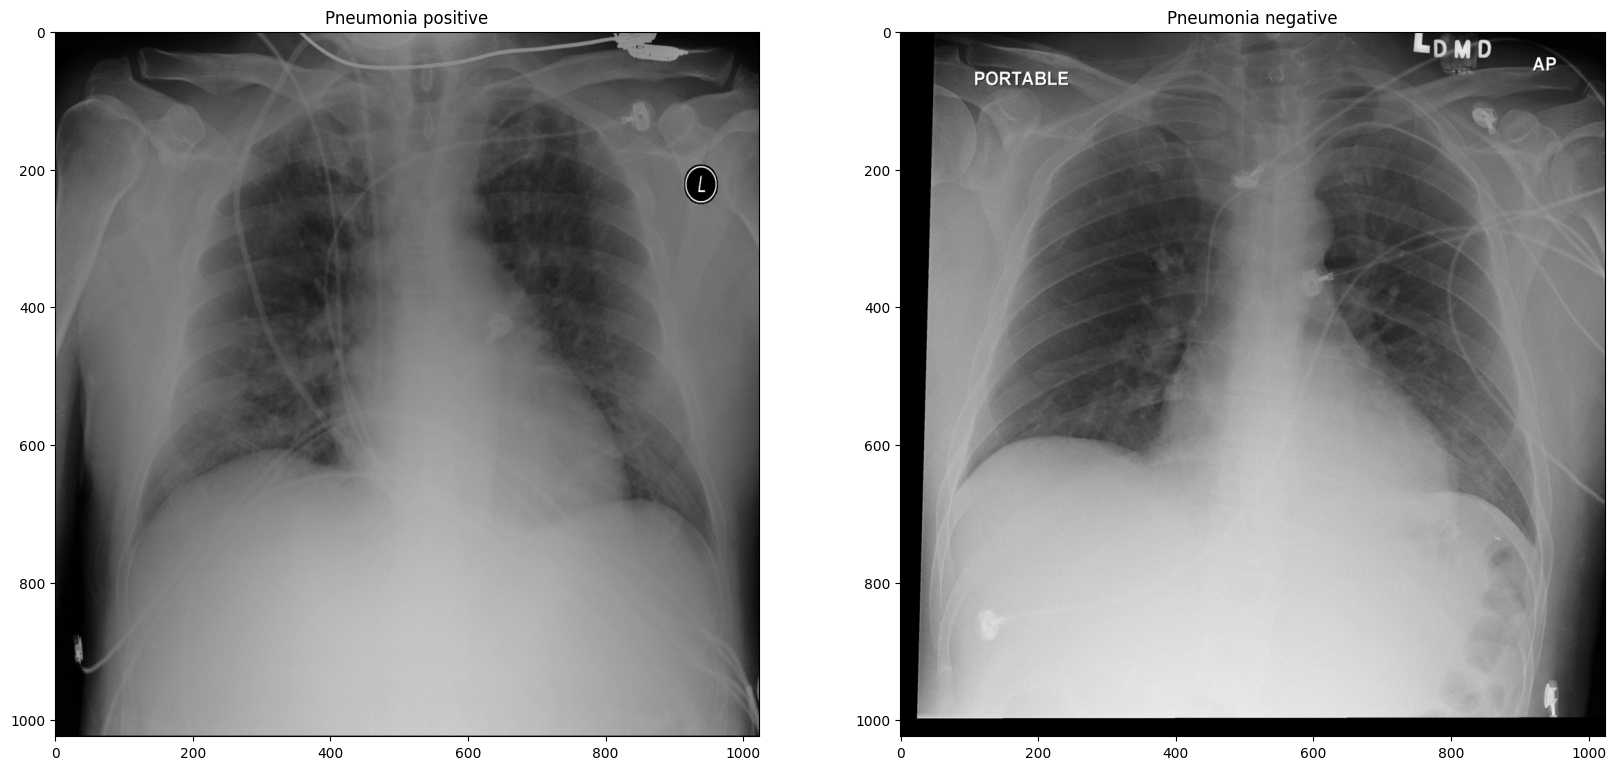

In [12]:
JPG_IMG_TRAIN = r'/content/JPG_FILES_TRAIN/JPG_IMG_TRAIN'
pos_patient_id = df_train_data.loc[df_train_data.Target==1, 'patientId'].sample(n = 1).values[0]
neg_patient_id = df_train_data.loc[df_train_data.Target==0, 'patientId'].sample(n = 1).values[0]
fig, ax = plt.subplots(1,2, figsize=(20,10))

pos_patient_file = os.path.join(JPG_IMG_TRAIN,pos_patient_id+'.jpg')
pos_patient_img = cv2.imread(pos_patient_file,cv2.IMREAD_GRAYSCALE)
ax[0].imshow(pos_patient_img,cmap='gray')
ax[0].set_title('Pneumonia positive')

neg_patient_file = os.path.join(JPG_IMG_TRAIN,neg_patient_id+'.jpg')
neg_patient_img = cv2.imread(neg_patient_file,cv2.IMREAD_GRAYSCALE)
ax[1].imshow(neg_patient_img,cmap='gray')
ax[1].set_title('Pneumonia negative')
plt.show()

above picture it can be seen that Pneumonia infected (or positive) lungs has more black/grey regions in comparison to not infected (or negative) lungs. We need our models to capture this difference in images.

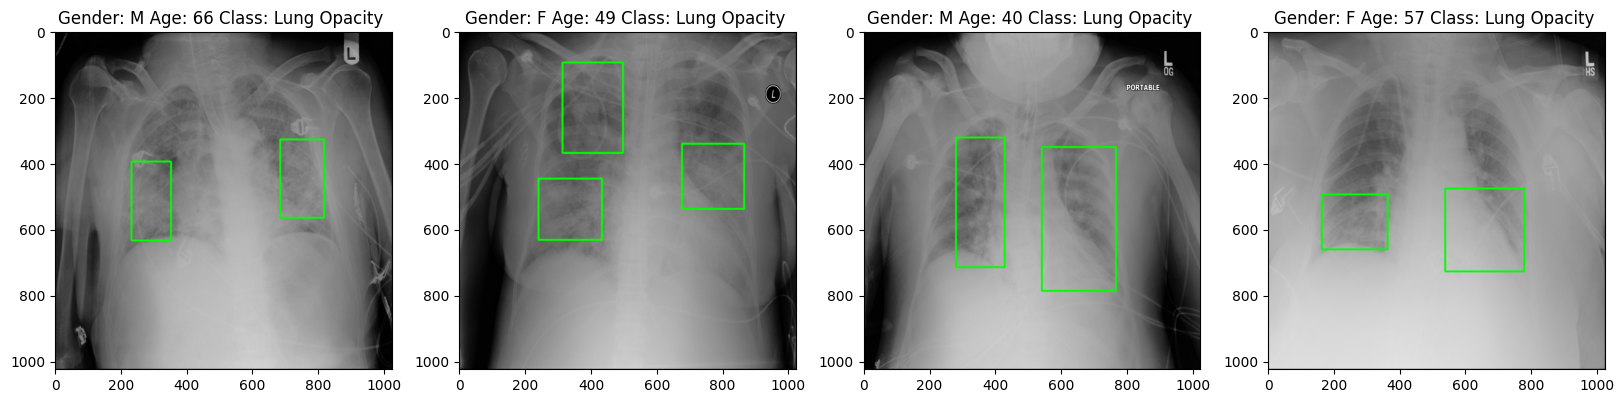

In [ ]:
noOfSample = 4
randSample = df_train_data.loc[df_train_data.Target==1, :].sample(n = noOfSample)

fig, ax = plt.subplots(1,noOfSample, figsize=(noOfSample*5,5))
i = 0
for _, row in randSample.iterrows():
  img = cv2.imread(row['jpg_file_path'])


  boundBoxes = df_train_data.loc[df_train_data.patientId == row['patientId'],['x','y','width','height']]
  for _,box in boundBoxes.iterrows():
    x1 = int(box['x'])
    y1 = int(box['y'])
    x2 = x1 + int(box['width'])
    y2 = y1 + int(box['height'])
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0), 3, cv2.LINE_AA)

  ax[i].imshow(img, cmap = plt.cm.bone)
  ax[i].set_title(f"Gender: {row['sex']} Age: {row['age']} Class: {row['class']} ")

  i += 1


above images show the boouding boxed of location of lungs where the infection is found

In [ ]:
pos_patient_id = df_train_data.drop_duplicates(subset=['patientId']).loc[df_train_data.Target==1, 'patientId'].sample(n = 100)
neg_patient_id = df_train_data.drop_duplicates(subset=['patientId']).loc[df_train_data.Target==0, 'patientId'].sample(n = 100)

img_list = []
sample_data = df_train_data.drop_duplicates(subset=['patientId']).loc[df_train_data.patientId.isin(pos_patient_id.append(neg_patient_id)),['jpg_file_path','Target']]
for _,img in sample_data.iterrows():
  img = cv2.imread(img['jpg_file_path'],cv2.IMREAD_GRAYSCALE)
  # img = cv2.resize(img,(256,256))
  img_list.append(img.flatten())
img_list = np.asarray(img_list)
img_list = img_list/255
pca = PCA(n_components=2)
img_list_pca = pca.fit_transform(img_list)

<ipython-input-14-41daaa97db90>:5: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_data = df_train_data.drop_duplicates(subset=['patientId']).loc[df_train_data.patientId.isin(pos_patient_id.append(neg_patient_id)),['jpg_file_path','Target']]


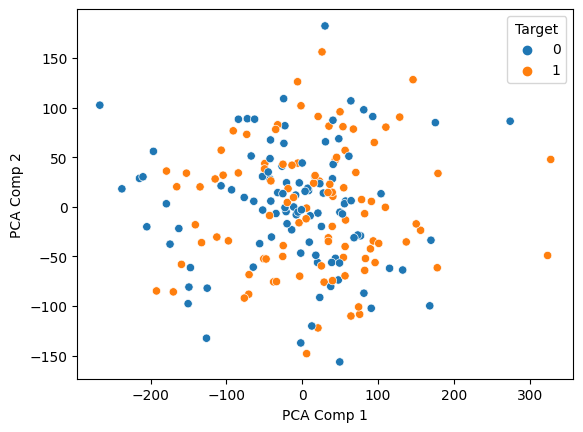

In [ ]:
sns.scatterplot(x=img_list_pca[:,0],y=img_list_pca[:,1],hue=sample_data.Target)
plt.gca().set_xlabel('PCA Comp 1')
plt.gca().set_ylabel('PCA Comp 2')
plt.show()

Performing a principal component decomposition of pixel values of a sample images revels that there is no significant feature within the pixels that can separate the two target values (0 for pneumonia -ve and 1 for pneumonia +ve). It’s very complex feature space and its difficult to separate between two classes.

## Step 6: Design, train and test basic CNN models for classification. [ 10 points ]

In [ ]:
# temp = df_train_data.drop_duplicates(subset=['patientId'])[['img_path','Target','patientId']]
# JPG_IMG_TRAIN = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/JPG_IMG_TRAIN'
# if os.path.exists(JPG_IMG_TRAIN)==False:
#   os.mkdir(JPG_IMG_TRAIN)
# def writeJpg(filename,patientId):
#   jpg_file_path = os.path.sep.join([JPG_IMG_TRAIN,patientId+'.jpg'])
#   image = dicom.read_file(filename).pixel_array
#   image = np.expand_dims(image, axis=-1)
#   cv2.imwrite(jpg_file_path,image)
#   return jpg_file_path


# temp['jpg_file_path'] = temp.progress_apply(lambda x : writeJpg(x['img_path'],x['patientId']),axis=1)

In [ ]:
# pickle.dump(temp, open(r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/temp.pkl','wb'))

In [ ]:
# temp = pickle.load(open(r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/temp.pkl','rb'))

In [13]:
temp = df_train_data.drop_duplicates(subset=['patientId'])[['jpg_file_path','Target','patientId']]

Splitting train, validation and test

In [14]:
X = temp['jpg_file_path']
y = temp['Target'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED_VAL)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify= y_test, random_state= SEED_VAL)

#### Training a 3 Layer CNN

Defining some utility functions

In [15]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32

def plotLossAcc(history,matric='accuracy'):
  '''
  this method will plot the validation and training curve.
  it helps to see if the model if over fitting or not
  '''
  hist  = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig,ax = plt.subplots(1,2, figsize=(10,5), sharex=True)

  # Plotting accuracy at different epochs

  ax[0].plot(hist['loss'])
  ax[0].plot(hist['val_loss'])
  ax[0].legend(("train" , "valid") , loc =0)
  ax[0].set_title('Training Loss and Validation Loss')
  ax[0].set_xlabel('Epoc')
  ax[0].set_ylabel('Loss')


  ax[1].plot(hist[matric])
  ax[1].plot(hist[f'val_{matric}'])
  ax[1].legend(("train" , "valid") , loc =0)
  ax[1].set_title(f'Training {matric} and Validation {matric}')
  ax[1].set_xlabel('Epoc')
  ax[1].set_ylabel(matric)

  plt.show()

def plot_roc_curve(actual, prob):
  '''
  this method plot the ROC curve
  '''
  fpr, tpr, thresholds = roc_curve(actual, prob, pos_label=1)
  rocauc = auc(fpr, tpr)
  plt.clf()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % rocauc)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve')
  plt.legend(loc="lower right")
  plt.show()

def plot_confusion_matrix(actual, pred):
  '''
  this method plots the confusion matrix
  '''
  cm = confusion_matrix(actual, pred)
  plt.figure(figsize=(10,7))
  sns.heatmap(cm,annot=True,fmt='d')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

def evaluate_metrics(y_test, y_test_pred, y_test_probs, probability_threshold=0.5, average='binary',col_labl='test'):
  '''
  this method will evaluate data and generate various performance matrix like accuracy, f1 score, precision and recall
  '''
  fpr, tpr, thresholds = roc_curve(y_test, y_test_probs, pos_label=1)
  rocauc = auc(fpr, tpr)

  testing_accuracy = accuracy_score(y_test, y_test_pred)
  precision = precision_score(y_test, y_test_pred, average=average)
  recall = recall_score(y_test, y_test_pred, average=average)
  f1 = f1_score(y_test, y_test_pred, average=average)

  df = pd.DataFrame({col_labl+'_accuracy':[testing_accuracy],
                  col_labl+'_precision': [precision],
                  col_labl+'_recall': [recall],
                  col_labl+'_f1': [f1],
                  col_labl+'_test_roc_auc':[rocauc]})
  return df

def writeResults(df):
  '''
  this method writes the results to a csv file
  '''
  FINAL_RESULTS_CSV = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/final_result_ver1.csv'
  try:
    final_results = pd.read_csv(FINAL_RESULTS_CSV)
  except:
    final_results = pd.DataFrame()

  final_results = pd.concat([final_results,df])
  final_results.to_csv(FINAL_RESULTS_CSV,index=False)
  # print(final_results)


def make_dataset_1(x_file_list, y_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, batch_size = BATCH_SIZE, do_resize=True, no_channels = 1):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(no_channels))
      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))
      image = tf.cast(image, tf.float32) / 255.0
      return image, label

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset


def getCNN(num_filters=[64,32,16],
               kernel_size=(3,3),
               pool_size = (2,2),
               input_shape = (64,64,1),
               drop_out = 0.5,
               ini_lr = 0.0001):
  '''
  this mehod will create a cnn model
  '''
  tf.keras.backend.clear_session()

  cnn = Sequential()


  cnn.add(Conv2D(num_filters[0], kernel_size=kernel_size, activation="relu", padding='same',
                  input_shape= input_shape))
  cnn.add(MaxPooling2D(pool_size = pool_size ))
  cnn.add(BatchNormalization())


  for i in np.arange(1,len(num_filters)):
    cnn.add(Conv2D(num_filters[i], kernel_size=kernel_size, activation="relu", padding='same'))
    cnn.add(MaxPooling2D(pool_size = pool_size))
    cnn.add(BatchNormalization())


  cnn.add(Flatten())

  cnn.add(Dense(activation = 'relu', units = 128))
  cnn.add(BatchNormalization())
  cnn.add(Dropout(drop_out))

  cnn.add(Dense(activation = 'relu', units = 64))
  cnn.add(BatchNormalization())
  cnn.add(Dropout(drop_out/2))

  cnn.add(Dense(activation = 'sigmoid', units = 1))

  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=ini_lr,
                                                               decay_steps=10000,
                                                               decay_rate=0.9)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

  cnn.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

  return cnn


def runCNN(name='CNN_VER4',
           itr = 1,
           resize_width = 64,
           resize_height = 64,
           num_filters=[64,32,16],
           ini_lr = 0.0001,
           kernel_size=(3,3),
           pool_size = (2,2),
           input_shape = (64,64,1),
           drop_out = 0.5,
           batch_size = 32,
           max_epoch = 5,
           x_train = None,
           x_val = None,
           x_test = None,
           y_train = None,
           y_val = None,
           y_test = None,
           cls_wt = None,
           do_resize_train = True,
           do_resize_val = True,
           do_resize_test = True):
  '''
  this mehod will create a cnn and run a model, plot resutls and store results for validation and test
  '''
  print(f'gc collectd {gc.collect()}')
  print(f'*******************************starting training for model name {name} itr no {itr}*****************************************')
  train_ds = make_dataset_1(x_train, y_train,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = do_resize_train)
  val_ds = make_dataset_1(x_val,y_val,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = do_resize_val)
  test_ds = make_dataset_1(x_test,y_test,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = do_resize_test)
  ver_fl_name = name +'_'+str(itr)+'.h5'
  his_fl_name = name  +'_'+str(itr)+'_history.pkl'
  fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
  ver_fl_name = os.path.join(fldr_name,ver_fl_name)
  his_fl_name = os.path.join(fldr_name,his_fl_name)

  mdl = getCNN(num_filters=num_filters,
                  kernel_size=kernel_size,
                  pool_size = pool_size,
                  input_shape = input_shape,
                  drop_out = drop_out,
                  ini_lr = ini_lr)
  mdl.summary()

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ver_fl_name,
                                                      save_best_only=True,
                                                      monitor='val_accuracy',
                                                      save_weights_only= True,
                                                      mode='max',
                                                      verbose=0)
  model_erly_stp = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3,
                                                  verbose=0)
  if cls_wt !=None:
    print('training with class wt')
    histroy = mdl.fit(train_ds,
                        epochs=max_epoch,
                        validation_data=val_ds,
                        callbacks=[model_checkpoint,model_erly_stp],
                        class_weight=cls_wt)
  else:
    print('training without class wt')
    histroy = mdl.fit(train_ds,
                        epochs=max_epoch,
                        validation_data=val_ds,
                        callbacks=[model_checkpoint,model_erly_stp])

  pickle.dump(histroy, open(his_fl_name,'wb'))
  mdl.load_weights(ver_fl_name)

  PROD_THRESHOLD = 0.5
  y_test = []
  for i, (_, labels) in enumerate(test_ds):
      y_test.append(labels.numpy())
  y_test = np.concatenate(y_test)

  y_test_probs = mdl.predict(test_ds)
  y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)

  plotLossAcc(histroy)
  print(classification_report(y_test, y_test_pred))
  plot_roc_curve(y_test, y_test_probs)
  plot_confusion_matrix(y_test, y_test_pred)
  df1 = evaluate_metrics(y_test, y_test_pred,y_test_probs,col_labl='test')


  y_val = []
  for i, (_, labels) in enumerate(val_ds):
      y_val.append(labels.numpy())
  y_val = np.concatenate(y_val)

  y_val_probs = mdl.predict(val_ds)
  y_val_pred = (y_val_probs >= PROD_THRESHOLD).astype(int)
  df2 = evaluate_metrics(y_val, y_val_pred,y_val_probs,col_labl='val')

  df = pd.concat([df1,df2],axis=1)

  mdl_dtls = f'{len(num_filters)}LYR {num_filters} img_wd {resize_width} img_ht {resize_height} cnn with class weight, itr = {itr}, name = {name}'
  df['model_details'] = [mdl_dtls]
  df['name'] = [name]
  writeResults(df)
  return df

making data set

Will do experiments to find out which scaling of image creates the best resutl

gc collectd 4443
*******************************starting training for model name IMG_SIZE_TRIALS itr no 1*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 1

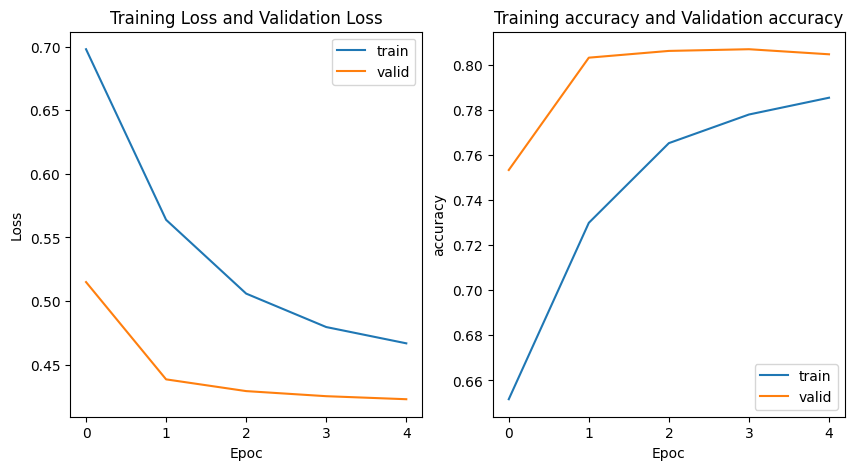

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2068
           1       0.59      0.38      0.46       601

    accuracy                           0.80      2669
   macro avg       0.71      0.65      0.67      2669
weighted avg       0.78      0.80      0.78      2669



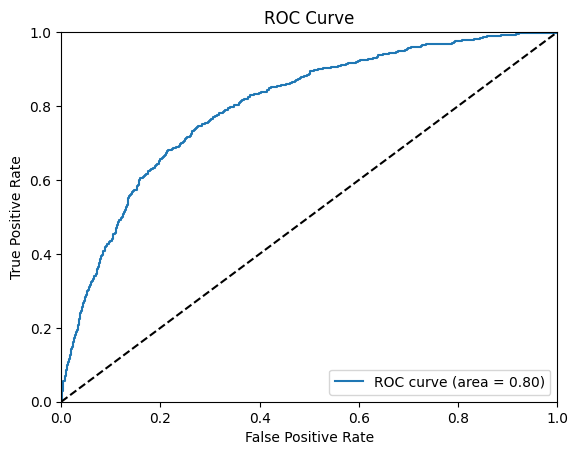

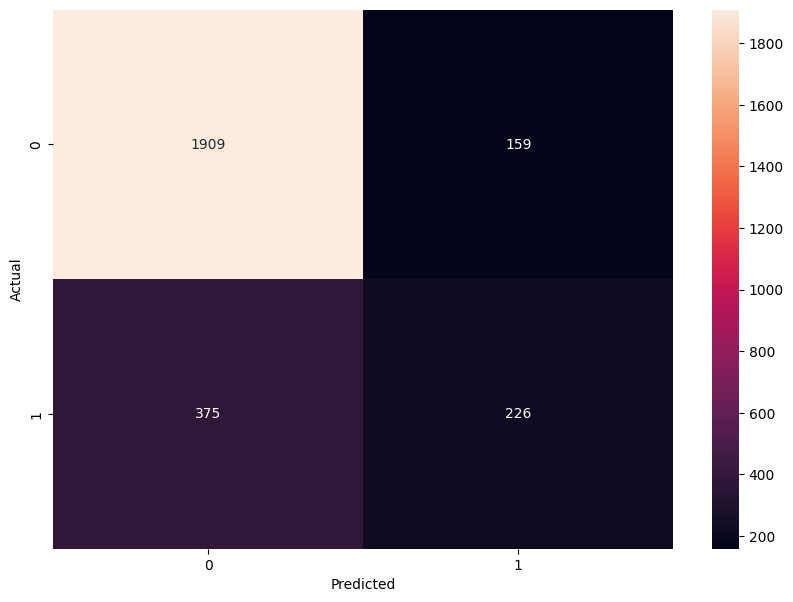

84/84 [==============================] - 9s 106ms/step
gc collectd 14267
*******************************starting training for model name IMG_SIZE_TRIALS itr no 2*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        18464     
                                                   

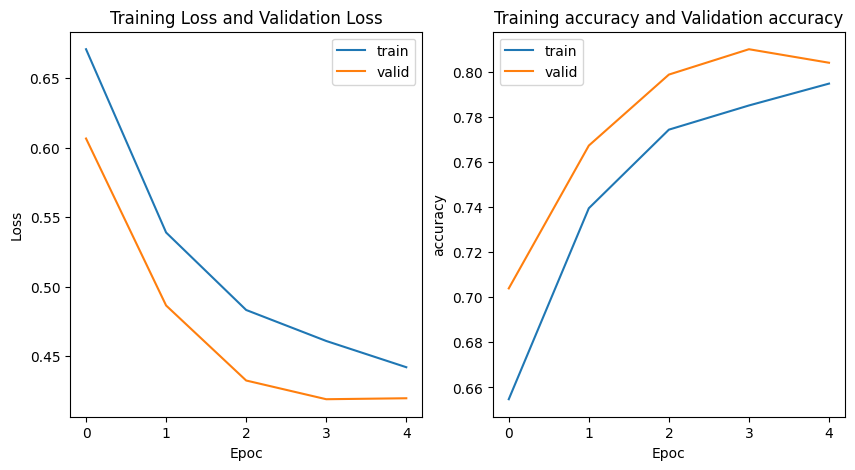

              precision    recall  f1-score   support

           0       0.83      0.92      0.88      2068
           1       0.58      0.36      0.45       601

    accuracy                           0.80      2669
   macro avg       0.71      0.64      0.66      2669
weighted avg       0.78      0.80      0.78      2669



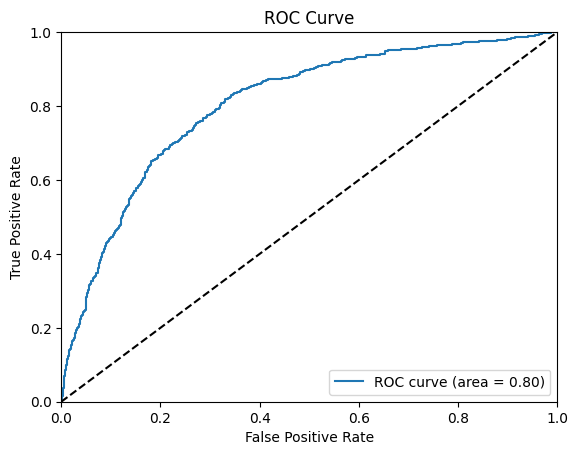

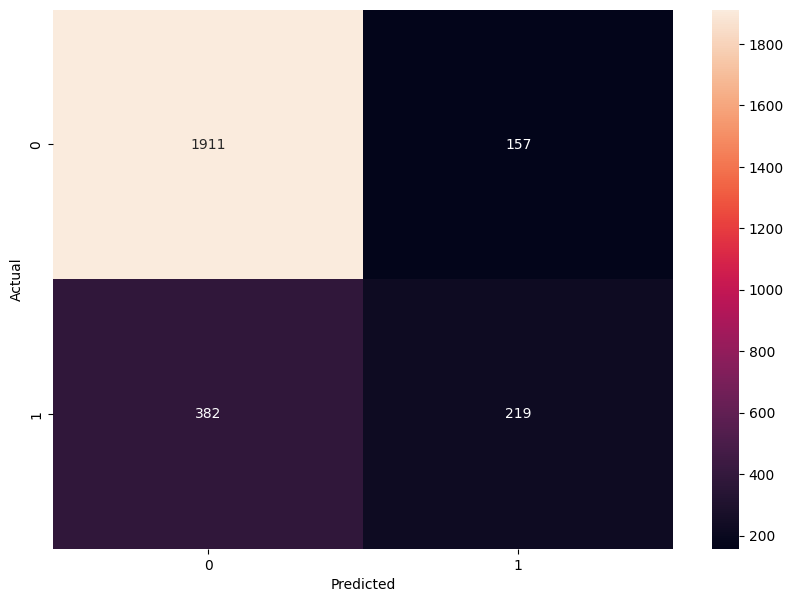

84/84 [==============================] - 9s 112ms/step
gc collectd 16359
*******************************starting training for model name IMG_SIZE_TRIALS itr no 3*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 96, 96, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        18464     
                                                   

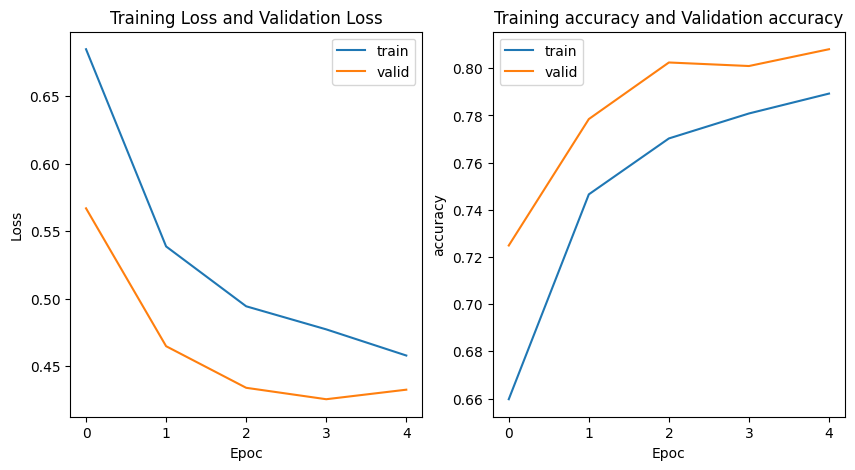

              precision    recall  f1-score   support

           0       0.81      0.96      0.88      2068
           1       0.62      0.25      0.35       601

    accuracy                           0.80      2669
   macro avg       0.72      0.60      0.62      2669
weighted avg       0.77      0.80      0.76      2669



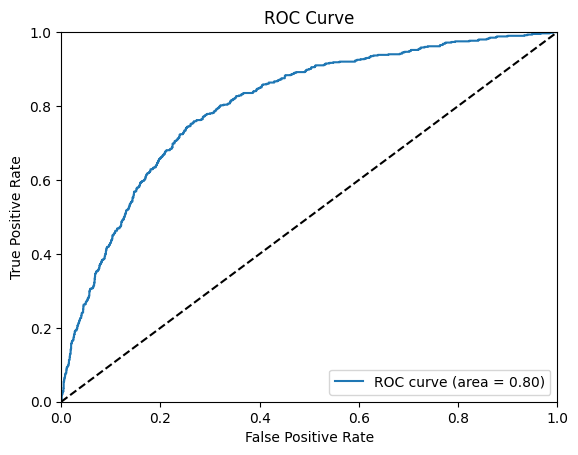

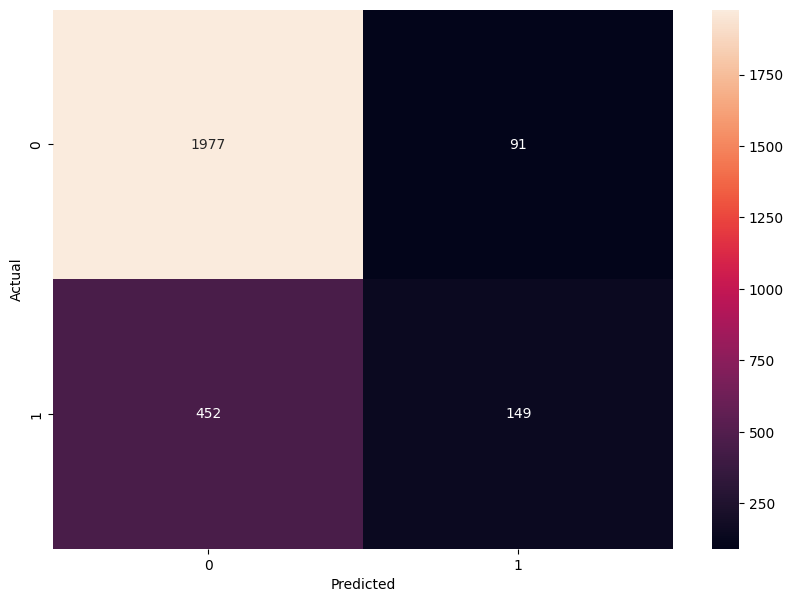

84/84 [==============================] - 10s 122ms/step
gc collectd 16174
*******************************starting training for model name IMG_SIZE_TRIALS itr no 4*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      18464     
                                                  

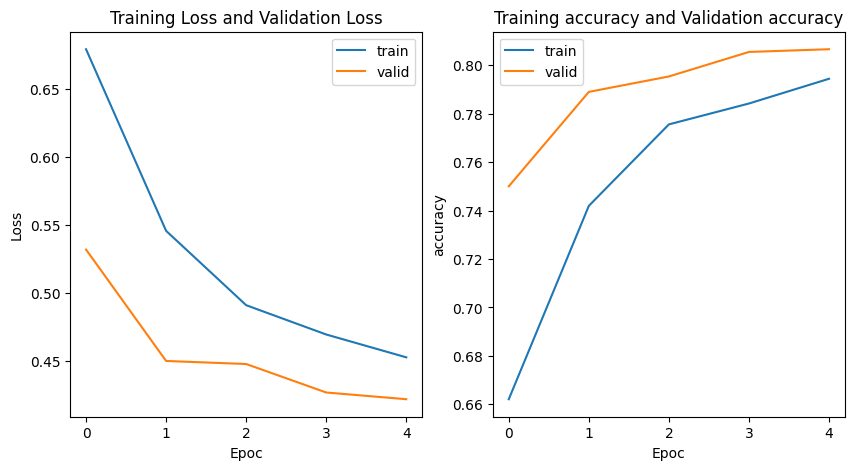

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2068
           1       0.57      0.50      0.53       601

    accuracy                           0.80      2669
   macro avg       0.71      0.69      0.70      2669
weighted avg       0.79      0.80      0.80      2669



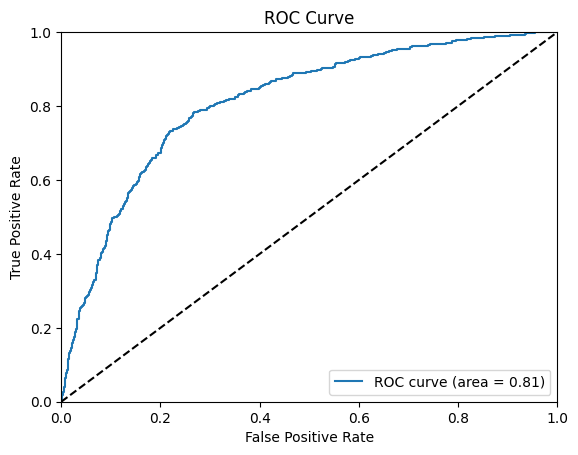

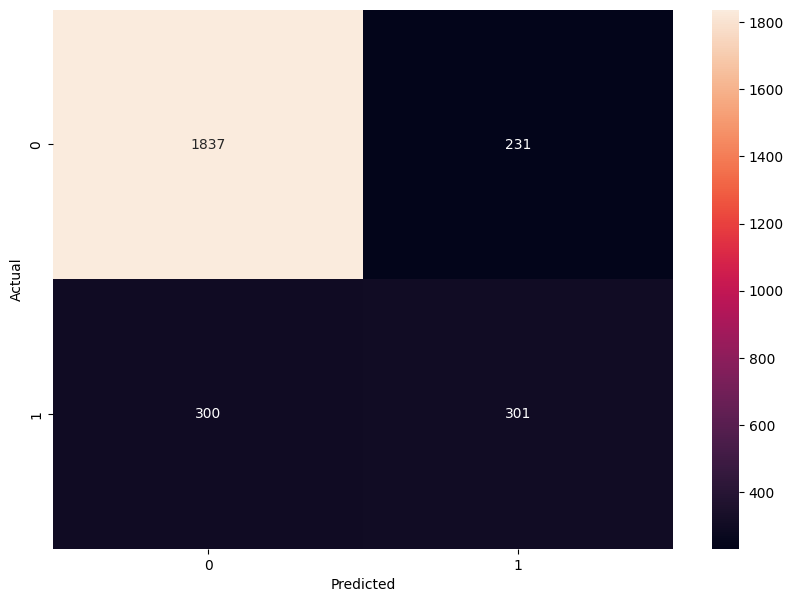

84/84 [==============================] - 9s 101ms/step
gc collectd 16236
*******************************starting training for model name IMG_SIZE_TRIALS itr no 5*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 256, 256, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      18464     
                                                   

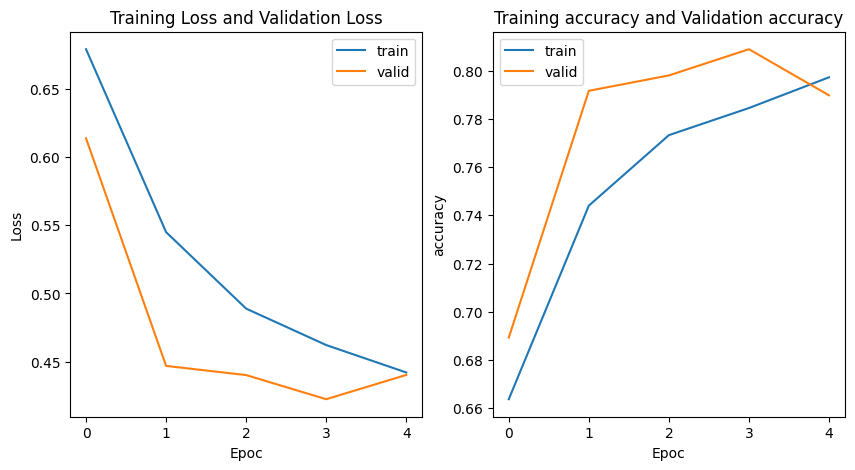

              precision    recall  f1-score   support

           0       0.84      0.92      0.87      2068
           1       0.57      0.38      0.46       601

    accuracy                           0.80      2669
   macro avg       0.70      0.65      0.67      2669
weighted avg       0.78      0.80      0.78      2669



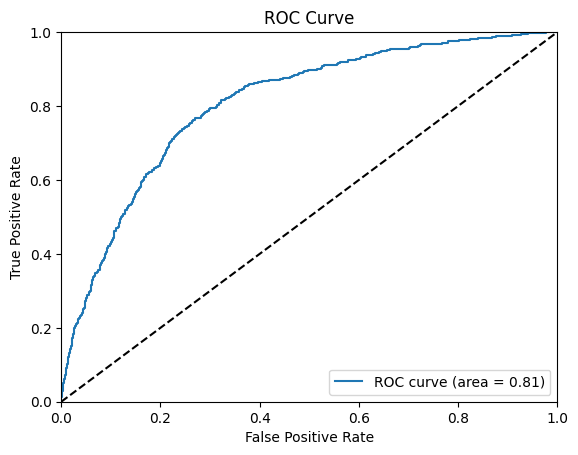

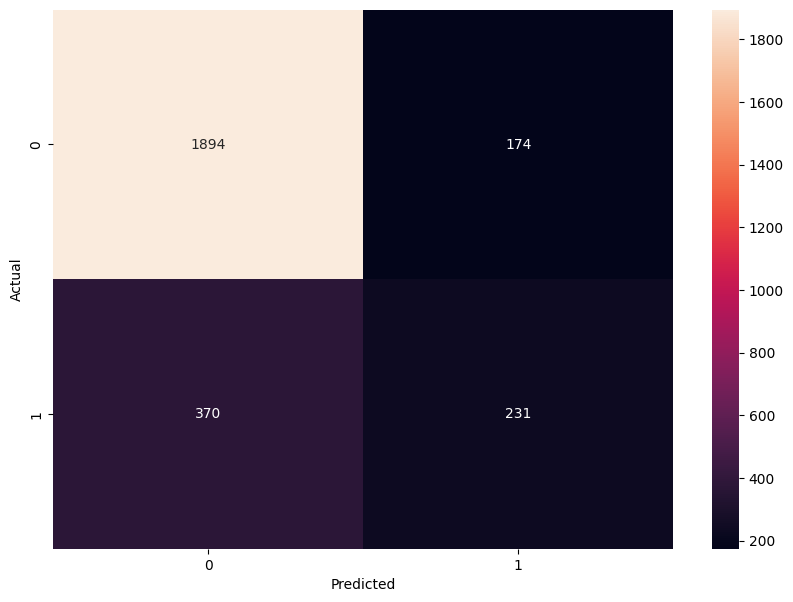

84/84 [==============================] - 14s 166ms/step


In [ ]:
modl_name='defalut_raw_data'
size_to_try = [64,128,192,256,512]
num_filters=[64,32,16]
itr = 1
for sz in size_to_try:
  resize_width = sz
  resize_height = sz
  input_shape = (resize_width,resize_height,1)
  df =runCNN(
        name='IMG_SIZE_TRIALS',
        itr = itr,
        resize_width = resize_width,
        resize_height = resize_height,
        num_filters=num_filters,
        ini_lr = 0.0001,
        kernel_size=(3,3),
        pool_size = (2,2),
        input_shape = input_shape,
        drop_out = 0.5,
        batch_size = 32,
        max_epoch = 5,
        x_train = x_train,
        x_val = x_val,
        x_test = x_test,
        y_train = y_train,
        y_val = y_val,
        y_test = y_test,
        )
  itr = itr + 1


In [ ]:
FINAL_RESULTS_CSV = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/final_result_ver1.csv'
final_results = pd.read_csv(FINAL_RESULTS_CSV)
print(final_results.sort_values(by=['test_recall','test_f1'],ascending=False))

   test_accuracy  test_precision  test_recall   test_f1  test_test_roc_auc  \
3       0.801049        0.565789     0.500832  0.531333           0.810879   
4       0.796178        0.570370     0.384359  0.459245           0.806925   
0       0.799925        0.587013     0.376040  0.458418           0.798975   
1       0.798052        0.582447     0.364393  0.448311           0.804692   
2       0.796553        0.620833     0.247920  0.354340           0.802595   

   val_accuracy  val_precision  val_recall    val_f1  val_test_roc_auc  \
3      0.806597       0.585170    0.485857  0.530909          0.815776   
4      0.808846       0.616967    0.399334  0.484848          0.806261   
0      0.806972       0.614362    0.384359  0.472876          0.805258   
1      0.809970       0.633523    0.371048  0.467996          0.810775   
2      0.808096       0.694323    0.264559  0.383133          0.798911   

                                       model_details             name  
3  3LYR [64, 3


**since this is medical application, recall and F1 score are parameter to select model.
<br>
From the above it can be seen that best test model is when we size the image to 256x256
<br>
so will use that size for few more experiments
 **

Trying over sampleing the minory class to see if the model improves.


In [ ]:
rus = RandomOverSampler()
x_resampled, y_resampled = rus.fit_resample(np.append(x_train,x_val,axis=0).reshape(-1, 1),
                                         np.append(y_train,y_val,axis=0).reshape(-1, 1))


x_train_bal_os, x_val_bal_os, y_train_bal_os, y_val_bal_os = train_test_split(pd.Series(x_resampled.flatten()),y_resampled,test_size=0.1,random_state=SEED_VAL)

gc collectd 20237
*******************************starting training for model name minorty_over_sampled itr no 6*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None,

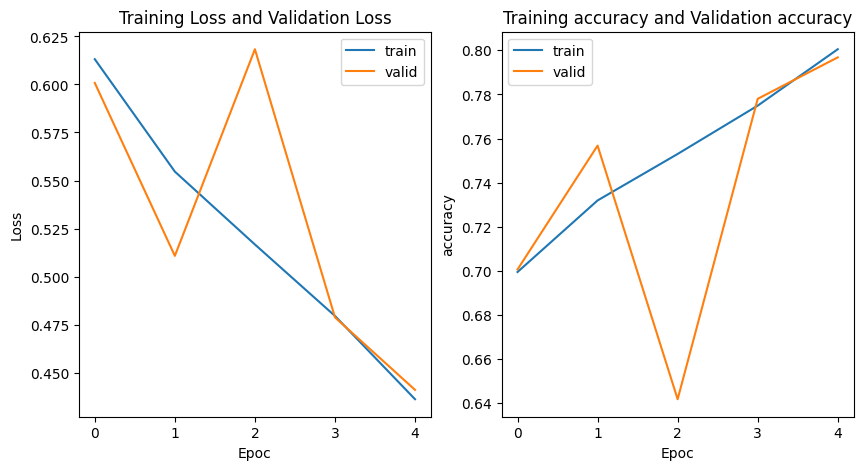

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      2068
           1       0.50      0.65      0.57       601

    accuracy                           0.78      2669
   macro avg       0.70      0.73      0.71      2669
weighted avg       0.80      0.78      0.79      2669



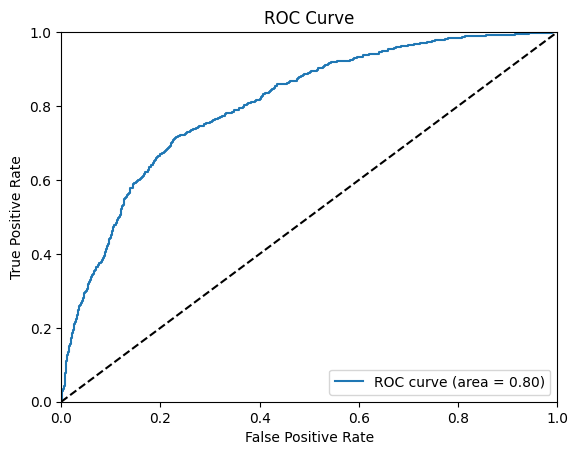

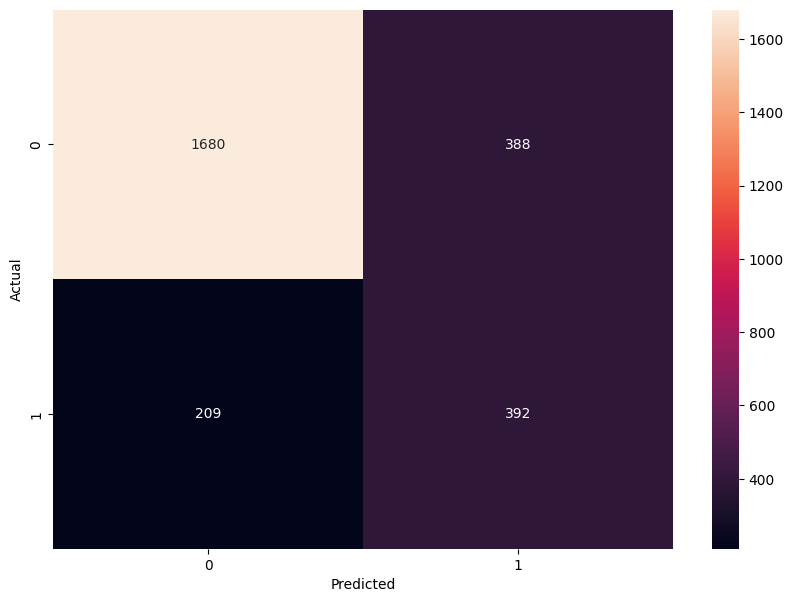

117/117 [==============================] - 13s 114ms/step


In [ ]:
modl_name='minorty_over_sampled'
size_to_try = 256
num_filters=[64,32,16]


resize_width = size_to_try
resize_height = size_to_try
input_shape = (resize_width,resize_height,1)
df =runCNN(
      name=modl_name,
      itr = itr,
      resize_width = resize_width,
      resize_height = resize_height,
      num_filters=num_filters,
      ini_lr = 0.0001,
      kernel_size=(3,3),
      pool_size = (2,2),
      input_shape = input_shape,
      drop_out = 0.5,
      batch_size = 32,
      max_epoch = 5,
      x_train = x_train_bal_os,
      x_val = x_val_bal_os,
      x_test = x_test,
      y_train = y_train_bal_os,
      y_val = y_val_bal_os,
      y_test = y_test,
      )
itr = itr + 1

In [ ]:
FINAL_RESULTS_CSV = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/final_result_ver1.csv'
final_results = pd.read_csv(FINAL_RESULTS_CSV)
print(final_results.sort_values(by=['test_recall','test_f1'],ascending=False))

   test_accuracy  test_precision  test_recall   test_f1  test_test_roc_auc  \
5       0.776321        0.502564     0.652246  0.567705           0.804637   
3       0.801049        0.565789     0.500832  0.531333           0.810879   
4       0.796178        0.570370     0.384359  0.459245           0.806925   
0       0.799925        0.587013     0.376040  0.458418           0.798975   
1       0.798052        0.582447     0.364393  0.448311           0.804692   
2       0.796553        0.620833     0.247920  0.354340           0.802595   

   val_accuracy  val_precision  val_recall    val_f1  val_test_roc_auc  \
5      0.796829       0.815661    0.782473  0.798722          0.878061   
3      0.806597       0.585170    0.485857  0.530909          0.815776   
4      0.808846       0.616967    0.399334  0.484848          0.806261   
0      0.806972       0.614362    0.384359  0.472876          0.805258   
1      0.809970       0.633523    0.371048  0.467996          0.810775   
2      0.

**From the above it can be seen that the minority over sampled model is slighly better then unbalanced model**

**now i will try class weight with unbalanced data**


gc collectd 1175
*******************************starting training for model name class_weight itr no 7*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 

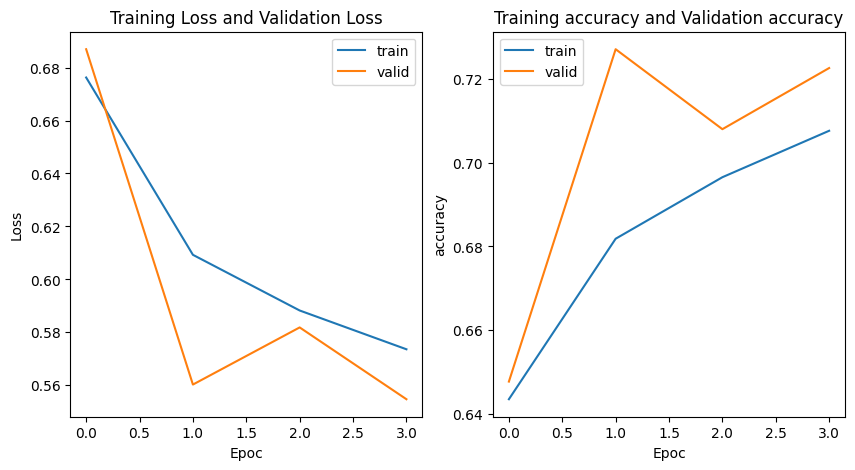

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      2068
           1       0.44      0.76      0.56       601

    accuracy                           0.73      2669
   macro avg       0.68      0.74      0.68      2669
weighted avg       0.81      0.73      0.75      2669



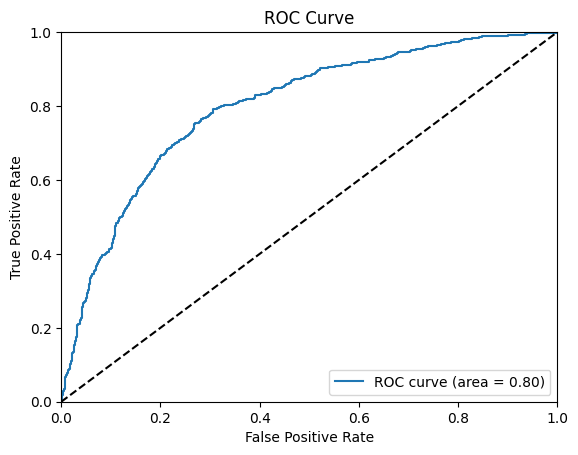

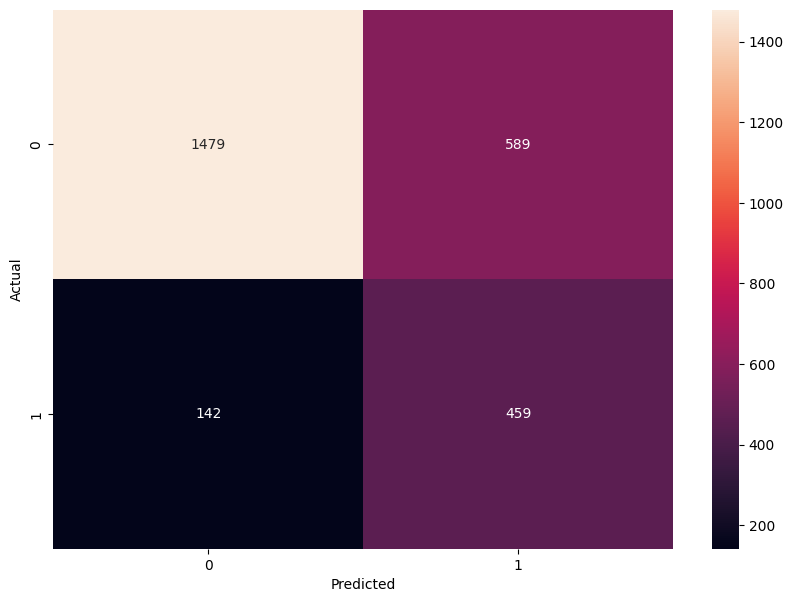

84/84 [==============================] - 12s 145ms/step


In [ ]:
modl_name='class_weight'
size_to_try = 256
num_filters=[64,32,16]

class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
clss_wt_dict = {}
for i,j in enumerate(class_weights):
  clss_wt_dict[i]=j


resize_width = size_to_try
resize_height = size_to_try
input_shape = (resize_width,resize_height,1)
df =runCNN(
      name=modl_name,
      itr = itr,
      resize_width = resize_width,
      resize_height = resize_height,
      num_filters=num_filters,
      ini_lr = 0.0001,
      kernel_size=(3,3),
      pool_size = (2,2),
      input_shape = input_shape,
      drop_out = 0.5,
      batch_size = 32,
      max_epoch = 5,
      x_train = x_train,
      x_val = x_val,
      x_test = x_test,
      y_train = y_train,
      y_val = y_val,
      y_test = y_test,
      cls_wt = clss_wt_dict
      )
itr = itr + 1

In [ ]:
FINAL_RESULTS_CSV = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/final_result_ver1.csv'
final_results = pd.read_csv(FINAL_RESULTS_CSV)
print(final_results.sort_values(by=['test_recall','test_f1'],ascending=False))

   test_accuracy  test_precision  test_recall   test_f1  test_test_roc_auc  \
6       0.726115        0.437977     0.763727  0.556701           0.797998   
5       0.776321        0.502564     0.652246  0.567705           0.804637   
3       0.801049        0.565789     0.500832  0.531333           0.810879   
4       0.796178        0.570370     0.384359  0.459245           0.806925   
0       0.799925        0.587013     0.376040  0.458418           0.798975   
1       0.798052        0.582447     0.364393  0.448311           0.804692   
2       0.796553        0.620833     0.247920  0.354340           0.802595   

   val_accuracy  val_precision  val_recall    val_f1  val_test_roc_auc  \
6      0.727136       0.437806    0.743760  0.551171          0.801449   
5      0.796829       0.815661    0.782473  0.798722          0.878061   
3      0.806597       0.585170    0.485857  0.530909          0.815776   
4      0.808846       0.616967    0.399334  0.484848          0.806261   
0    

Doing some tesing using the best model


In [ ]:
best_mdl = getCNN(num_filters=[64,32,16],
               kernel_size=(3,3),
               pool_size = (2,2),
               input_shape = (256,256,1),
               drop_out = 0.5,
               ini_lr = 0.0001)
best_mdl.load_weights('/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/minorty_over_sampled_6.h5')

1/1 [==============================] - 0s 220ms/step


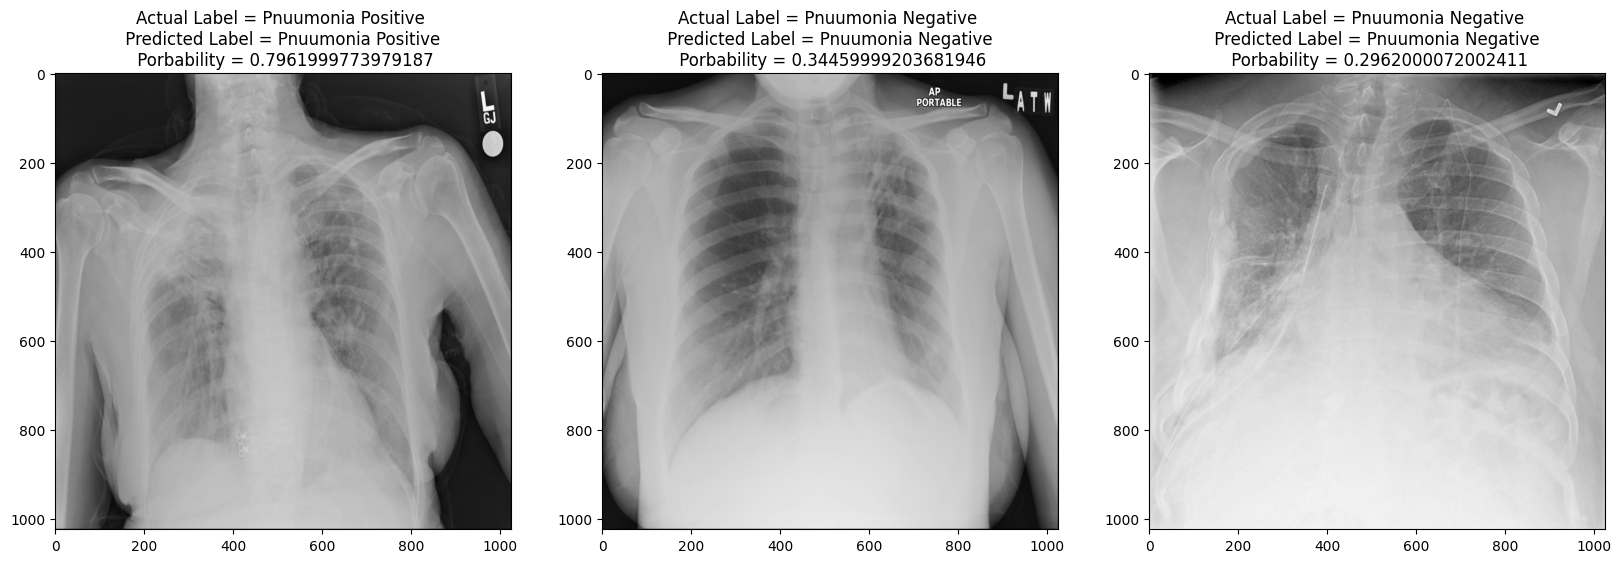

In [ ]:
PROD_THRESHOLD = 0.5
temp = pd.DataFrame({'x_test':x_test,
                     'y_test':y_test}).sample(3)
test_ds = make_dataset_1(temp.x_test,temp.y_test,img_width=256, img_height=256, batch_size = len(temp))


y_test_probs = best_mdl.predict(test_ds)
y_test_pred = (y_test_probs >=PROD_THRESHOLD).astype(int)

temp['y_test_probs'] = y_test_probs.flatten()
temp['y_test_pred'] = y_test_pred.flatten()

fig, ax = plt.subplots(1,3, figsize=(20,10))

for i in range(3):
  pos_patient_img = cv2.imread(temp.iloc[i,0],cv2.IMREAD_GRAYSCALE)
  ax[i].imshow(pos_patient_img,cmap='gray')
  actual_label = 'Pnuumonia Positive' if temp.iloc[i,1]==1 else 'Pnuumonia Negative'
  pred_label = 'Pnuumonia Positive' if temp.iloc[i,3]==1 else 'Pnuumonia Negative'
  lbl_string = f'Actual Label = {actual_label} \n Predicted Label = {pred_label} \n Porbability = {round(temp.iloc[i,2],4)}'
  ax[i].set_title(lbl_string)

plt.show()

Below are few ways to improve the model
* There model is not performing well for the minority class, so data augmentation on minority class can be tried.
* Hyper parameter tuning (like learning rate, dropout, batch size, batch size, etc) to reduce the fluctuation in validation accuracy/loss during training.
* We can identify the optimal probability threshold which can increase the recall for minority class.
* Transfer learning methods can be tried to design better features.

# MILESTONE 2

## Step 1: Fine tune the trained basic CNN models for classification. [ 5 points ]

We will try to improve the custom CNN model using the following 3 techniques

1.	Data augmentation - will attempt to generate random images from the minority class and use it to balance the imbalance of classes.
2.	Parameter optimization – will attempt to fine tune the model by parameter optimization. Will try number of filters, number of hidden CNN layers, batch size.
3.	Finally will try to utilize the best model to calculate best probability threshold which increases the recall.


### 1 Data augmentation - Generating ramdon distortion of minorty classes

In [ ]:
class_1_data_fldr = r'/content/JPG_FILES_TRAIN_CLASS_1'

if os.path.exists(class_1_data_fldr) == False:
  os.mkdir(class_1_data_fldr)

class_0_data_fldr = r'/content/JPG_FILES_TRAIN_CLASS_0'

if os.path.exists(class_0_data_fldr) == False:
  os.mkdir(class_0_data_fldr)


def copyImgFiles(x,y):
  global class_1_data_fldr, class_0_data_fldr

  if y==1:
    flname = x.split('/')[-1]
    path = os.path.join(class_1_data_fldr,flname)
    img = cv2.imread(x)
    cv2.imwrite(path,img)

  else:
    path = os.path.join(class_0_data_fldr,x.split('/')[-1])
    cv2.imwrite(path,cv2.imread(x))

temp = pd.DataFrame({'x_train':x_train,
                     'y_train':y_train})

temp.progress_apply(lambda x : copyImgFiles(x['x_train'],x['y_train']), axis=1)

100%|██████████| 21347/21347 [12:03<00:00, 29.52it/s]


13133    None
37341    None
33506    None
34675    None
25629    None
         ... 
12654    None
10738    None
7898     None
20656    None
14673    None
Length: 21347, dtype: object

In [ ]:
# generatng new data based on ImageDataGenerator on the minority class
img_width = 256
img_height = 256
datagen = ImageDataGenerator(rotation_range =15,
                         width_shift_range = 0.2,
                         height_shift_range = 0.2,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip = True,
                         fill_mode = 'nearest',
                         data_format='channels_last',
                         brightness_range=[0.5, 1.5])


img_dir = r"/content/JPG_FILES_TRAIN_CLASS_1" # Enter Directory of all images
data_path = os.path.join(img_dir,'*jpg')
files = glob(data_path)
data = []
for f1 in files:
  image_raw = tf.io.read_file(f1)
  image = tf.io.decode_jpeg(image_raw, channels=1)
  image = tf.image.resize(image, (img_width,img_height))
  data.append(image)

In [ ]:
if os.path.exists(r'/content/JPG_FILES_TRAIN_CLASS_1_aug') == False:
  os.mkdir(r'/content/JPG_FILES_TRAIN_CLASS_1_aug')

x = np.asarray(data)

i = 0
file_count = len(files) #to find number of files in folder

for batch in datagen.flow (x, batch_size=1, save_to_dir =r"/content/JPG_FILES_TRAIN_CLASS_1_aug",save_prefix="a",save_format='jpg'):
    i+=1
    if i==file_count:
      break

In [ ]:
files = glob(os.path.join(r'/content/JPG_FILES_TRAIN_CLASS_1','*jpg'))
for f1 in files:
  image_raw = cv2.imread(f1,cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image_raw, (img_width,img_height))
  cv2.imwrite(os.path.join(r'/content/JPG_FILES_TRAIN_CLASS_1_aug',f1.split('/')[-1]), image)


In [ ]:
if os.path.exists(r'/content/JPG_FILES_TRAIN_CLASS_0_aug') == False:
  os.mkdir(r'/content/JPG_FILES_TRAIN_CLASS_0_aug')

files = glob(os.path.join(r'/content/JPG_FILES_TRAIN_CLASS_0','*jpg'))
for f1 in files:
  image_raw = cv2.imread(f1,cv2.IMREAD_GRAYSCALE)
  image = cv2.resize(image_raw, (img_width,img_height))
  cv2.imwrite(os.path.join(r'/content/JPG_FILES_TRAIN_CLASS_0_aug',f1.split('/')[-1]), image)

In [ ]:
cls_0 = [os.path.join(r'/content/JPG_FILES_TRAIN_CLASS_0_aug',x) for x in os.listdir(r'/content/JPG_FILES_TRAIN_CLASS_0_aug')]
cls_1 = [os.path.join(r'/content/JPG_FILES_TRAIN_CLASS_1_aug',x) for x in os.listdir(r'/content/JPG_FILES_TRAIN_CLASS_1_aug')]
X = pd.concat([pd.DataFrame({'x_train':cls_0,'y_train':np.zeros(len(cls_0)).astype(int)}),
               pd.DataFrame({'x_train':cls_1,'y_train':np.zeros(len(cls_1)).astype(int)})]).sample(frac = 1)

gc collectd 0
*******************************starting training for model name minorty_image_regenerated itr no 8*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None

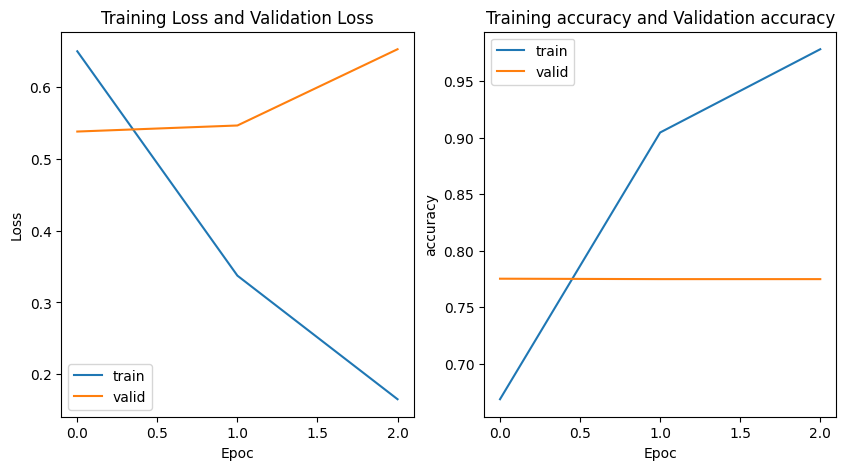

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      2068
           1       0.42      0.01      0.02       601

    accuracy                           0.77      2669
   macro avg       0.60      0.50      0.44      2669
weighted avg       0.69      0.77      0.68      2669



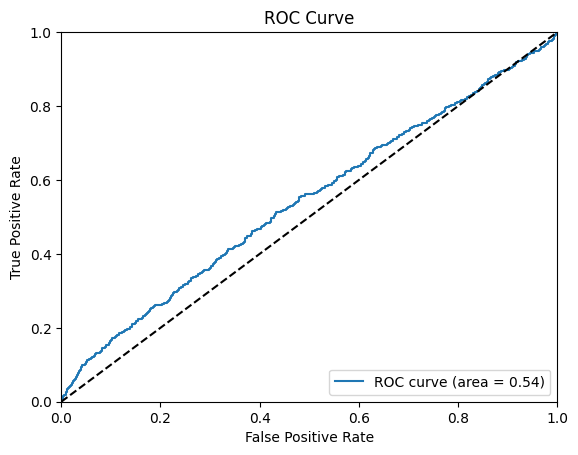

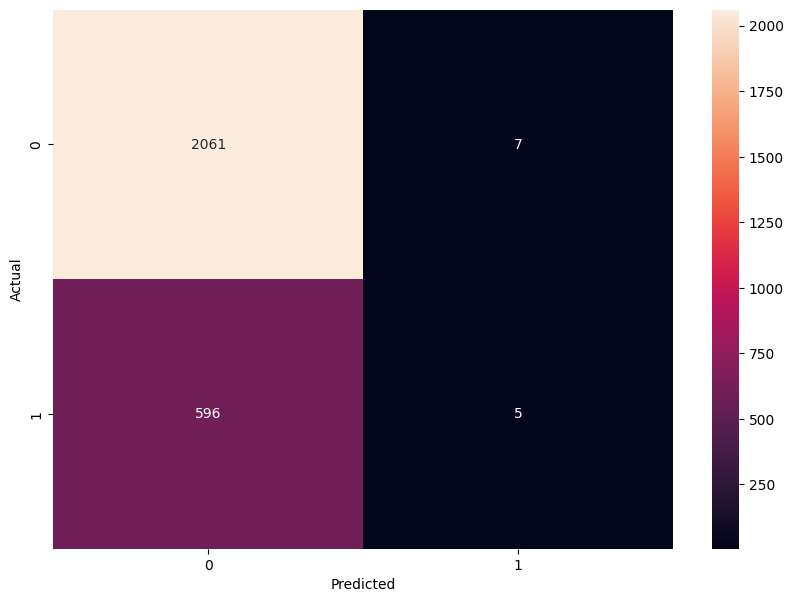

84/84 [==============================] - 11s 126ms/step


In [ ]:
modl_name='minorty_image_regenerated'
size_to_try = 256
num_filters=[64,32,16]

itr = 8
resize_width = size_to_try
resize_height = size_to_try
input_shape = (resize_width,resize_height,1)
df =runCNN(
      name=modl_name,
      itr = itr,
      resize_width = resize_width,
      resize_height = resize_height,
      num_filters=num_filters,
      ini_lr = 0.0001,
      kernel_size=(3,3),
      pool_size = (2,2),
      input_shape = input_shape,
      drop_out = 0.5,
      batch_size = 32,
      max_epoch = 10,
      x_train = X.x_train,
      x_val = x_val,
      x_test = x_test,
      y_train = X.y_train,
      y_val = y_val,
      y_test = y_test,
      do_resize_train = False,
      do_resize_val = True,
      do_resize_test = True
      )
itr = itr + 1

as seen from above the data agumentation is not improving the accuracy of the model. so trying other alternatives to improve the model

### 2. parameter optimization - hyper parameter tuning of number of filters and batch size

In [ ]:
# chaning the previous method to make it compatible for running iterations.
def runCNN_more_conf(name='CNN_VER4',
                     itr = 1,
                     resize_width = 64,
                     resize_height = 64,
                     num_filters=[64,32,16],
                     ini_lr = 0.0001,
                     kernel_size=(3,3),
                     pool_size = (2,2),
                     input_shape = (64,64,1),
                     drop_out = 0.5,
                     batch_size = 32,
                     max_epoch = 5,
                     patience_val = 5,
                     x_train = None,
                     x_val = None,
                     x_test = None,
                     y_train = None,
                     y_val = None,
                     y_test = None,
                     cls_wt = None,
                     do_resize_train = True,
                     do_resize_val = True,
                     do_resize_test = True,
                     load_inital_wts_from = None):
  '''
  this mehod will create a cnn and run a model, plot resutls and store results for validation and test
  '''
  print(f'gc collectd {gc.collect()}')
  print(f'*******************************starting training for model name {name} itr no {itr}*****************************************')
  train_ds = make_dataset_1(x_train, y_train,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = do_resize_train)
  val_ds = make_dataset_1(x_val,y_val,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = do_resize_val)
  test_ds = make_dataset_1(x_test,y_test,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = do_resize_test)
  ver_fl_name = name +'_'+str(itr)+'.h5'
  his_fl_name = name  +'_'+str(itr)+'_history.pkl'
  fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
  ver_fl_name = os.path.join(fldr_name,ver_fl_name)
  his_fl_name = os.path.join(fldr_name,his_fl_name)

  mdl = getCNN(num_filters=num_filters,
                  kernel_size=kernel_size,
                  pool_size = pool_size,
                  input_shape = input_shape,
                  drop_out = drop_out,
                  ini_lr = ini_lr)
  if load_inital_wts_from != None:
    mdl.load_weights(load_inital_wts_from)
  mdl.summary()

  model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ver_fl_name,
                                                      save_best_only=True,
                                                      monitor='val_accuracy',
                                                      save_weights_only= True,
                                                      mode='max',
                                                      verbose=0)
  model_erly_stp = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=patience_val,
                                                  verbose=0)
  if cls_wt !=None:
    print('training with class wt')
    histroy = mdl.fit(train_ds,
                        epochs=max_epoch,
                        validation_data=val_ds,
                        callbacks=[model_checkpoint,model_erly_stp],
                        class_weight=cls_wt)
  else:
    print('training without class wt')
    histroy = mdl.fit(train_ds,
                        epochs=max_epoch,
                        validation_data=val_ds,
                        callbacks=[model_checkpoint,model_erly_stp])

  pickle.dump(histroy, open(his_fl_name,'wb'))
  mdl.load_weights(ver_fl_name)

  PROD_THRESHOLD = 0.5
  y_test = []
  for i, (_, labels) in enumerate(test_ds):
      y_test.append(labels.numpy())
  y_test = np.concatenate(y_test)

  y_test_probs = mdl.predict(test_ds)
  y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)

  plotLossAcc(histroy)
  print(classification_report(y_test, y_test_pred))
  plot_roc_curve(y_test, y_test_probs)
  plot_confusion_matrix(y_test, y_test_pred)
  df1 = evaluate_metrics(y_test, y_test_pred,y_test_probs,col_labl='test')


  y_val = []
  for i, (_, labels) in enumerate(val_ds):
      y_val.append(labels.numpy())
  y_val = np.concatenate(y_val)

  y_val_probs = mdl.predict(val_ds)
  y_val_pred = (y_val_probs >= PROD_THRESHOLD).astype(int)
  df2 = evaluate_metrics(y_val, y_val_pred,y_val_probs,col_labl='val')

  df = pd.concat([df1,df2],axis=1)

  mdl_dtls = f'{len(num_filters)}LYR {num_filters} img_wd {resize_width} img_ht {resize_height} cnn, itr = {itr}, name = {name}'
  df['model_details'] = [mdl_dtls]
  df['name'] = [name]
  writeResults(df)
  return df

----Runnin opn with num_filters = [64, 32, 16] with batch_size 32----------
gc collectd 118
*******************************starting training for model name minorty_over_sampled_param_opt itr no 9*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      18464     
                 

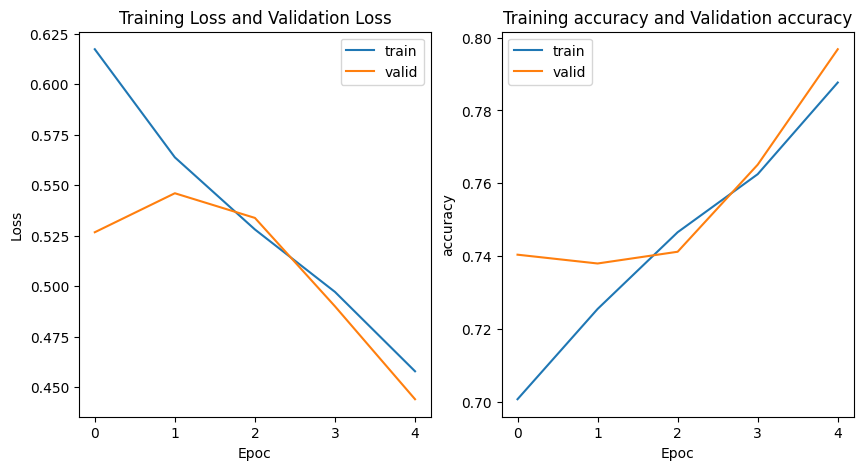

              precision    recall  f1-score   support

           0       0.89      0.81      0.85      2068
           1       0.49      0.65      0.56       601

    accuracy                           0.77      2669
   macro avg       0.69      0.73      0.70      2669
weighted avg       0.80      0.77      0.78      2669



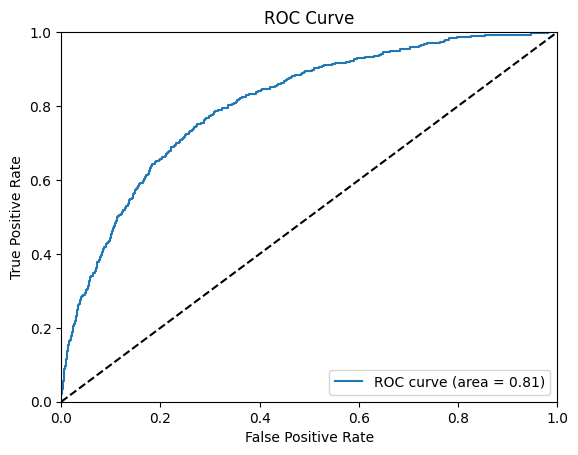

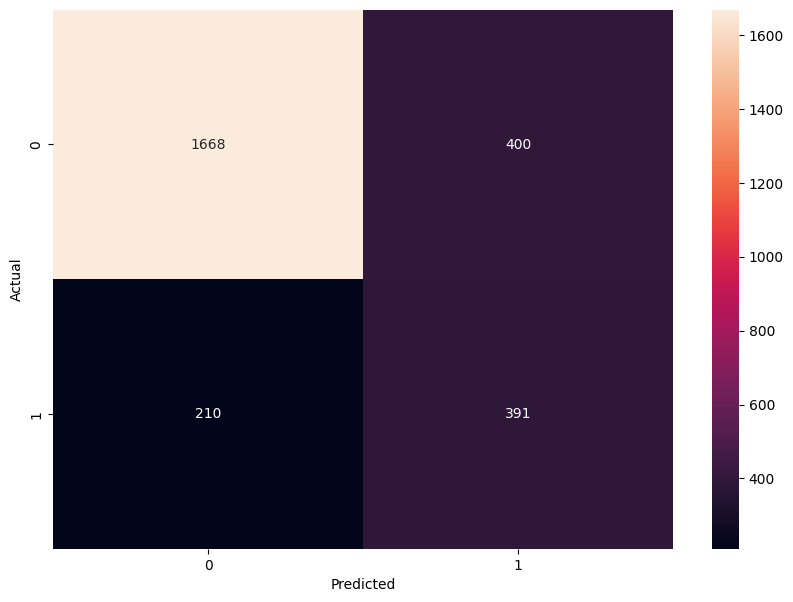

117/117 [==============================] - 13s 112ms/step
----Runnin opn with num_filters = [64, 32, 16] with batch_size 64----------
gc collectd 19431
*******************************starting training for model name minorty_over_sampled_param_opt itr no 10*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)    

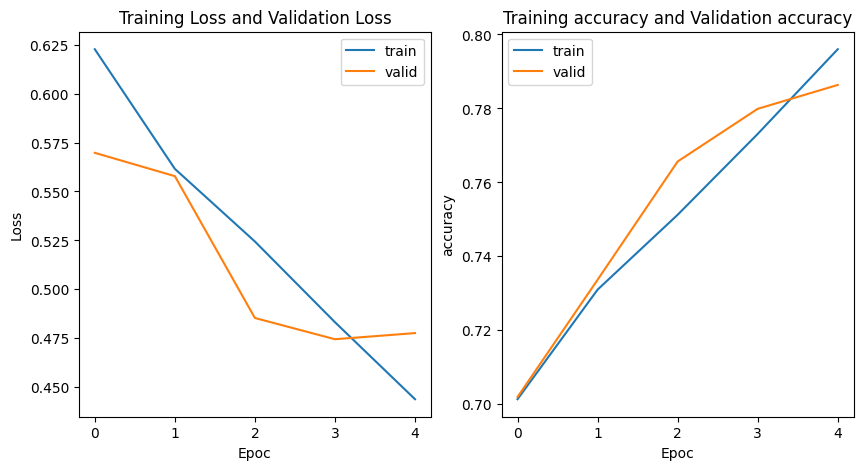

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      2068
           1       0.44      0.72      0.54       601

    accuracy                           0.73      2669
   macro avg       0.67      0.73      0.67      2669
weighted avg       0.80      0.73      0.75      2669



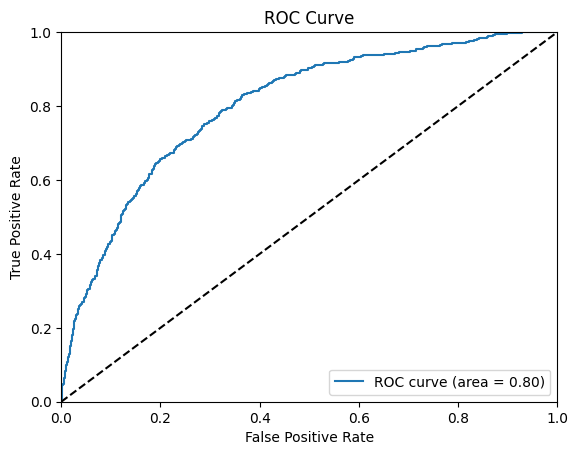

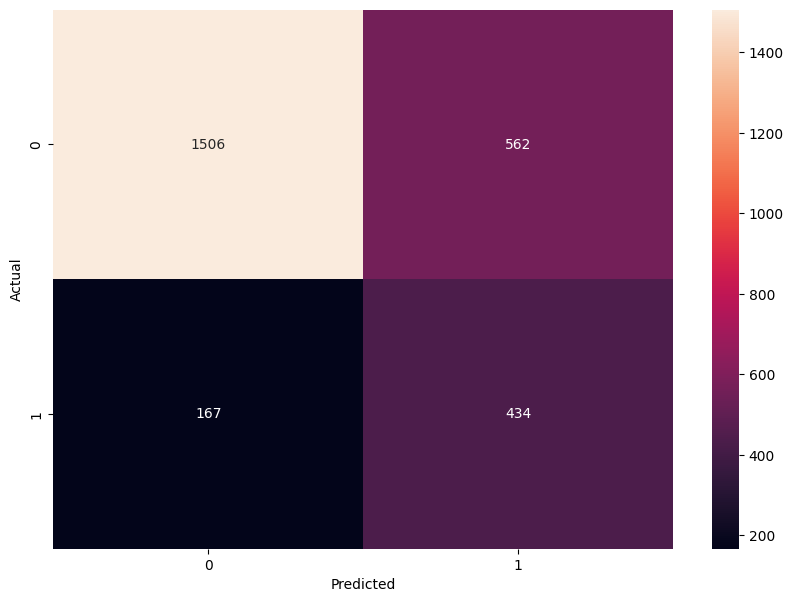

59/59 [==============================] - 13s 211ms/step
----Runnin opn with num_filters = [64, 32, 16] with batch_size 128----------
gc collectd 19440
*******************************starting training for model name minorty_over_sampled_param_opt itr no 11*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)     

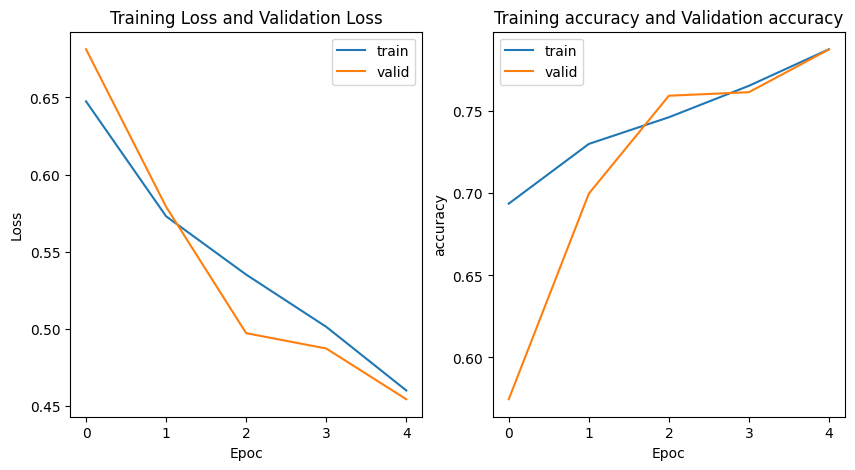

              precision    recall  f1-score   support

           0       0.90      0.76      0.83      2068
           1       0.46      0.71      0.56       601

    accuracy                           0.75      2669
   macro avg       0.68      0.74      0.69      2669
weighted avg       0.80      0.75      0.77      2669



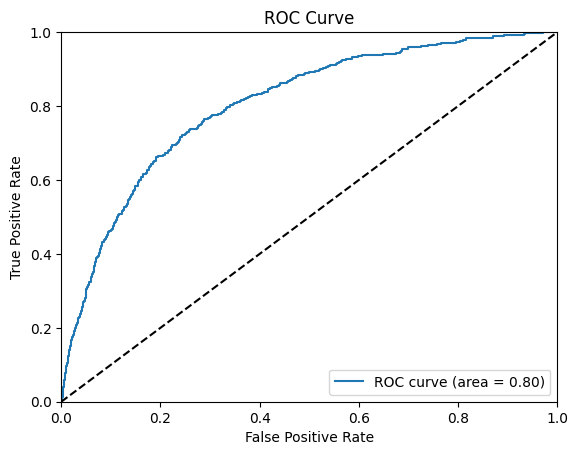

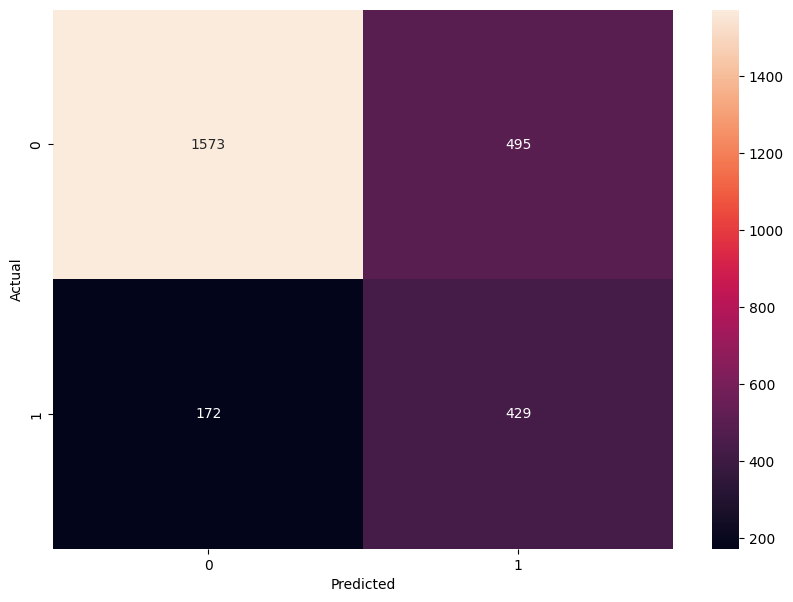

30/30 [==============================] - 13s 425ms/step
----Runnin opn with num_filters = [128, 64, 32, 16] with batch_size 32----------
gc collectd 18946
*******************************starting training for model name minorty_over_sampled_param_opt itr no 12*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 128)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D) 

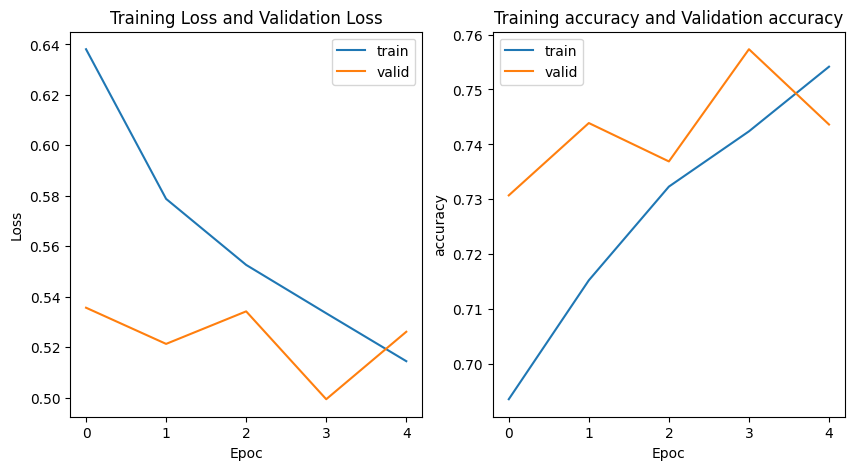

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      2068
           1       0.45      0.76      0.56       601

    accuracy                           0.73      2669
   macro avg       0.68      0.74      0.69      2669
weighted avg       0.81      0.73      0.75      2669



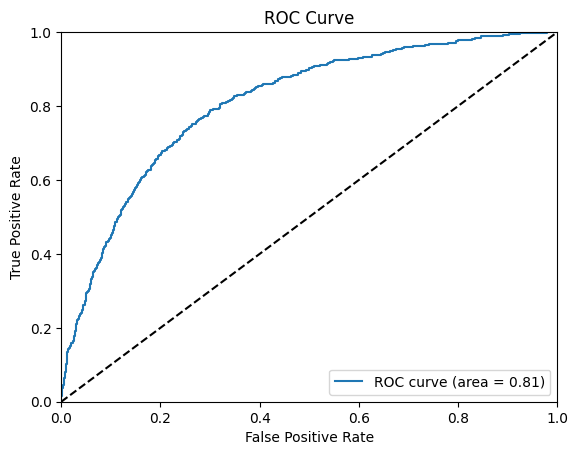

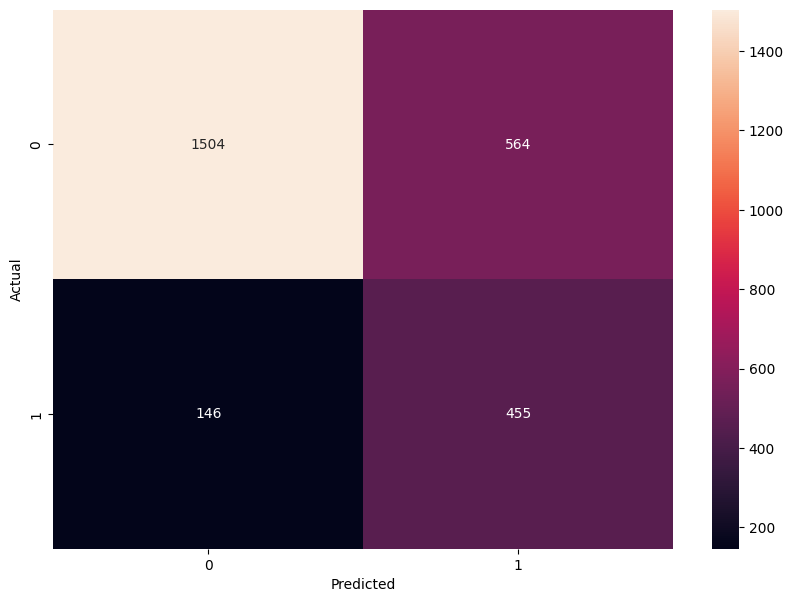

117/117 [==============================] - 14s 120ms/step
----Runnin opn with num_filters = [128, 64, 32, 16] with batch_size 64----------
gc collectd 19857
*******************************starting training for model name minorty_over_sampled_param_opt itr no 13*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 128)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D

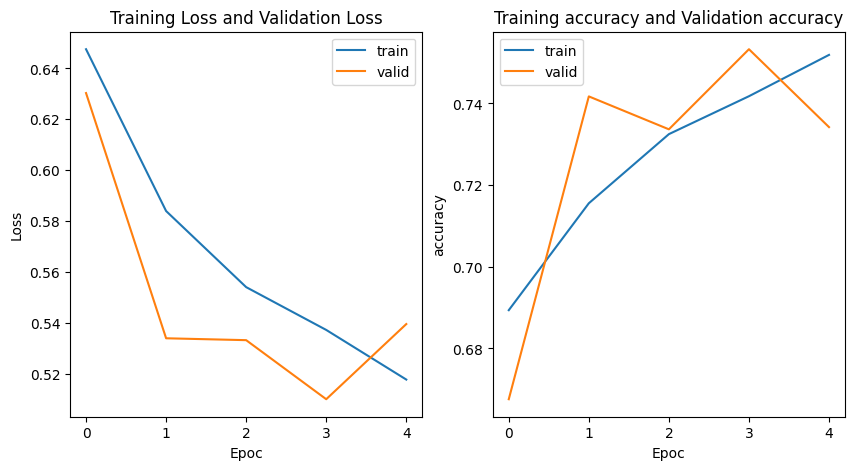

              precision    recall  f1-score   support

           0       0.89      0.79      0.83      2068
           1       0.48      0.67      0.56       601

    accuracy                           0.76      2669
   macro avg       0.68      0.73      0.69      2669
weighted avg       0.80      0.76      0.77      2669



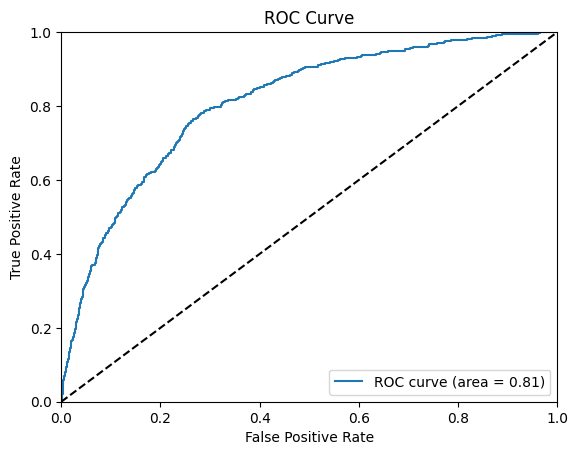

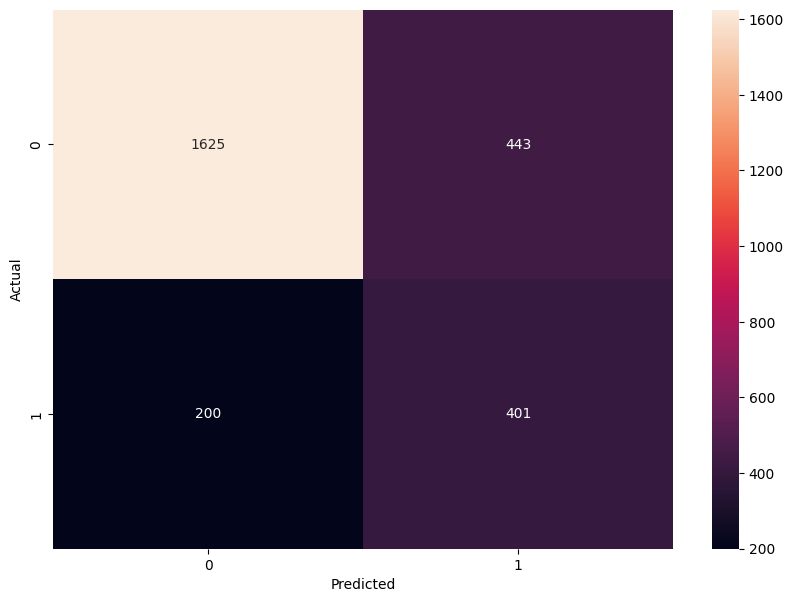

59/59 [==============================] - 14s 236ms/step
----Runnin opn with num_filters = [128, 64, 32, 16] with batch_size 128----------
gc collectd 16363
*******************************starting training for model name minorty_over_sampled_param_opt itr no 14*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 128)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)

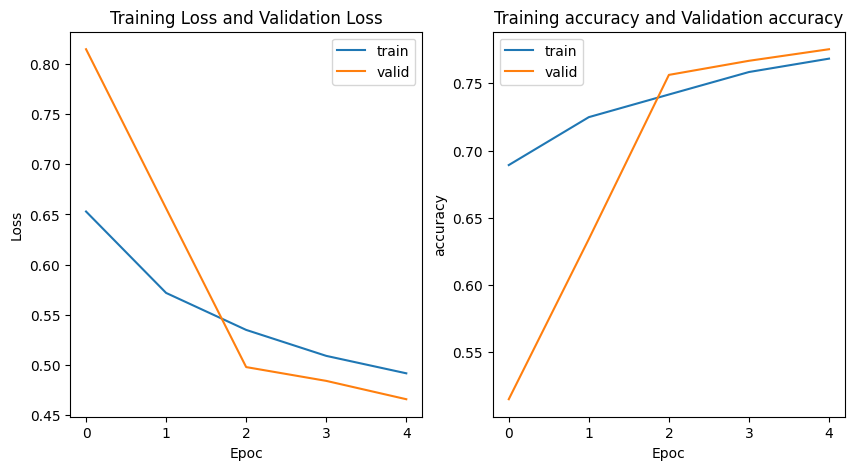

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      2068
           1       0.44      0.78      0.56       601

    accuracy                           0.73      2669
   macro avg       0.68      0.74      0.68      2669
weighted avg       0.81      0.73      0.75      2669



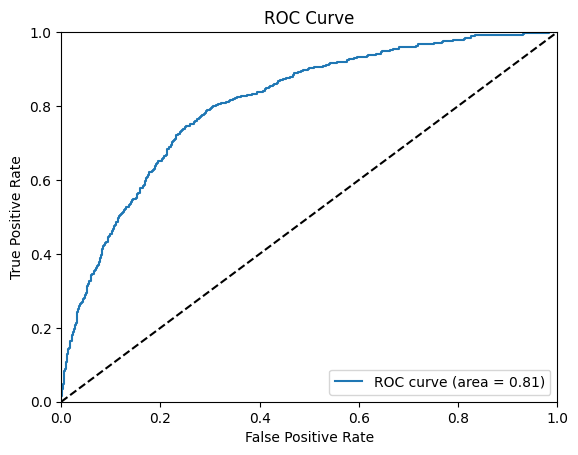

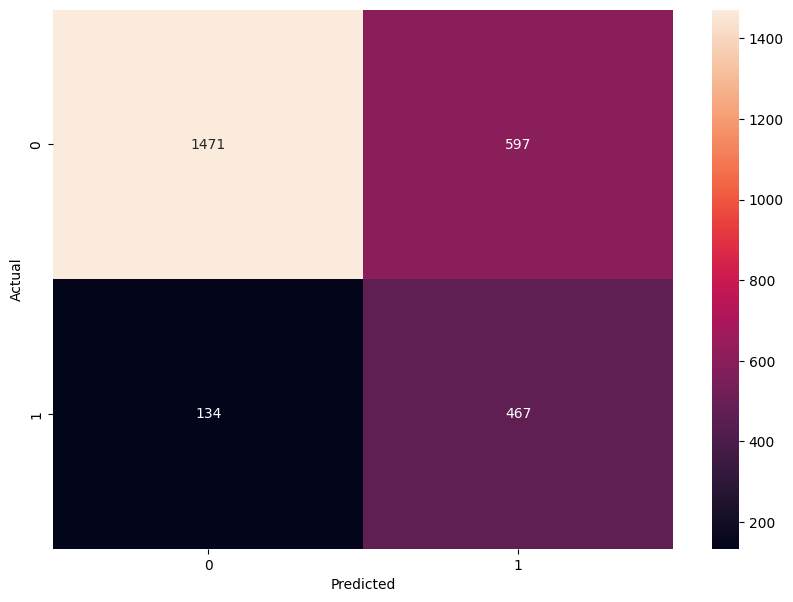

30/30 [==============================] - 13s 444ms/step
----Runnin opn with num_filters = [16, 32, 64] with batch_size 32----------
gc collectd 16517
*******************************starting training for model name minorty_over_sampled_param_opt itr no 15*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)      

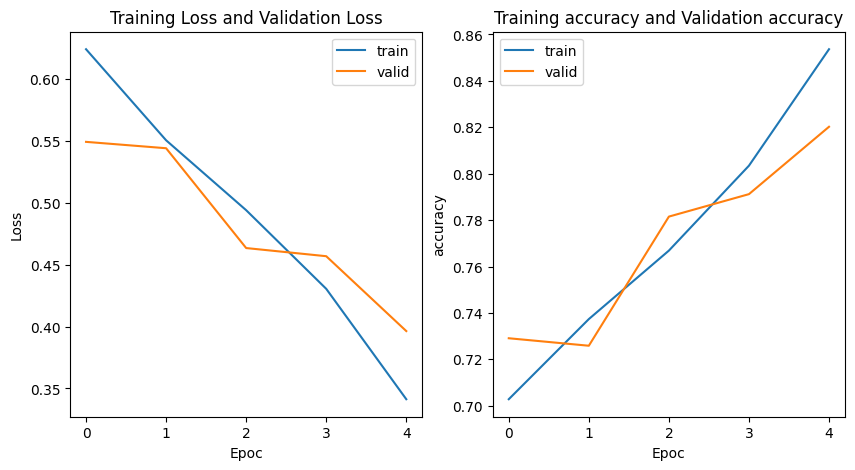

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2068
           1       0.57      0.43      0.49       601

    accuracy                           0.80      2669
   macro avg       0.71      0.67      0.68      2669
weighted avg       0.79      0.80      0.79      2669



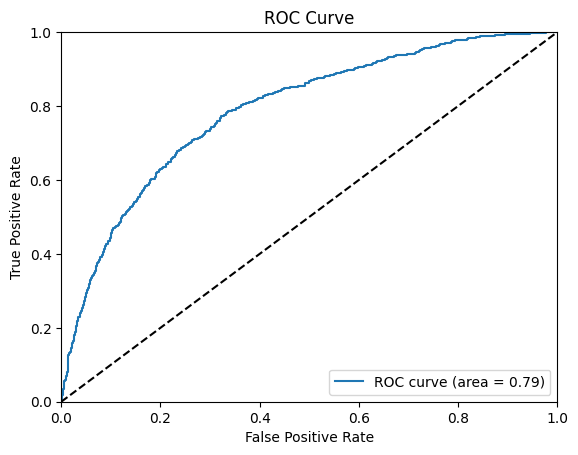

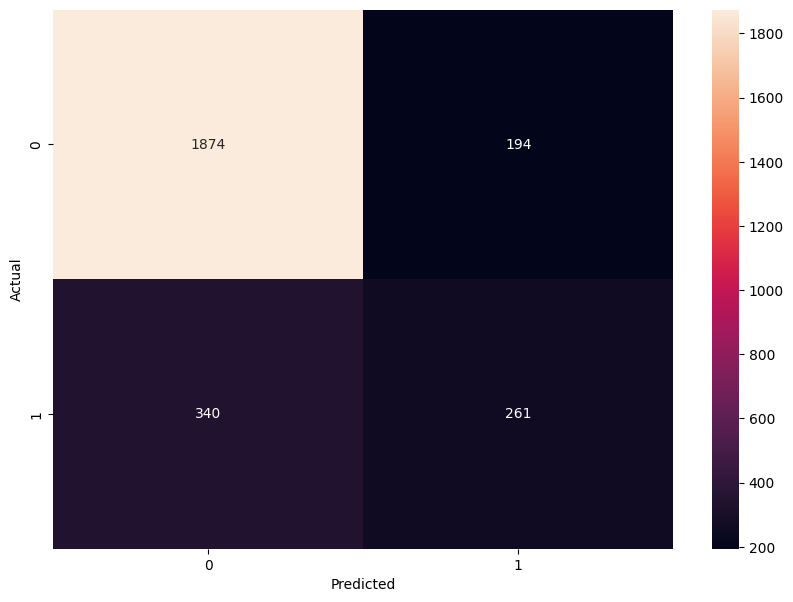

117/117 [==============================] - 14s 118ms/step
----Runnin opn with num_filters = [16, 32, 64] with batch_size 64----------
gc collectd 16560
*******************************starting training for model name minorty_over_sampled_param_opt itr no 16*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)    

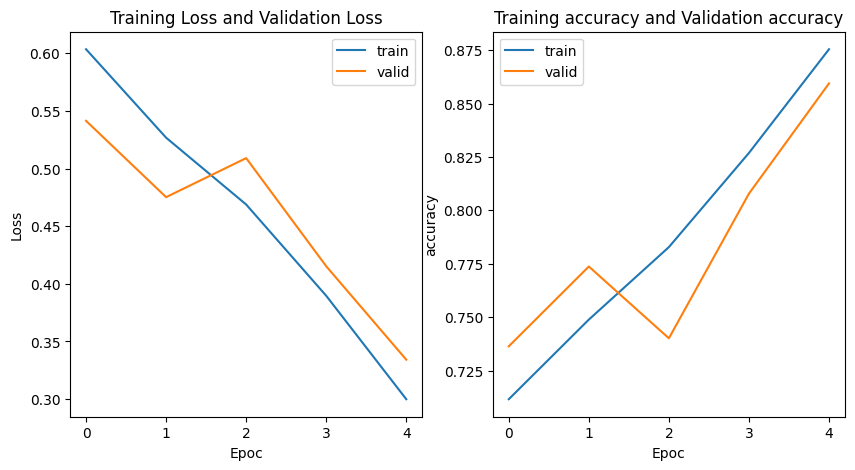

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2068
           1       0.54      0.51      0.53       601

    accuracy                           0.79      2669
   macro avg       0.70      0.69      0.70      2669
weighted avg       0.79      0.79      0.79      2669



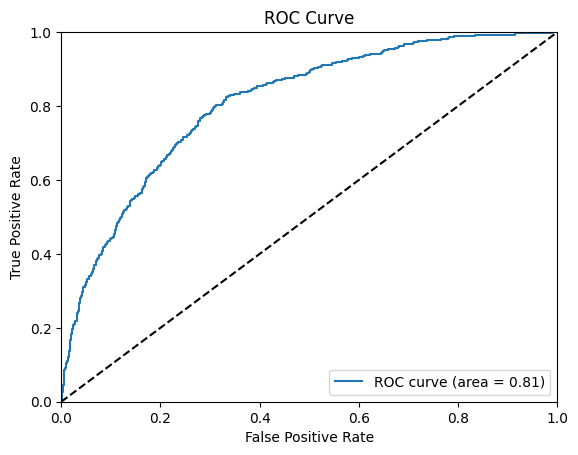

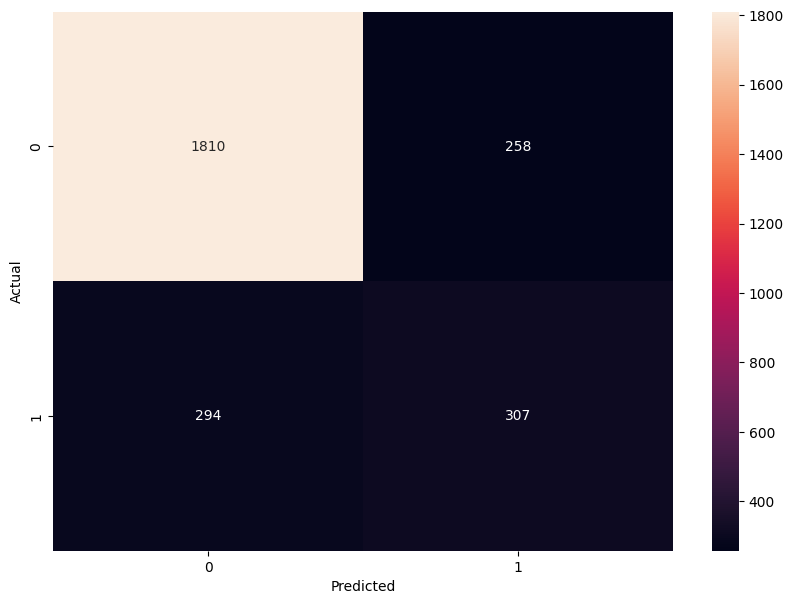

59/59 [==============================] - 13s 213ms/step
----Runnin opn with num_filters = [16, 32, 64] with batch_size 128----------
gc collectd 19529
*******************************starting training for model name minorty_over_sampled_param_opt itr no 17*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)     

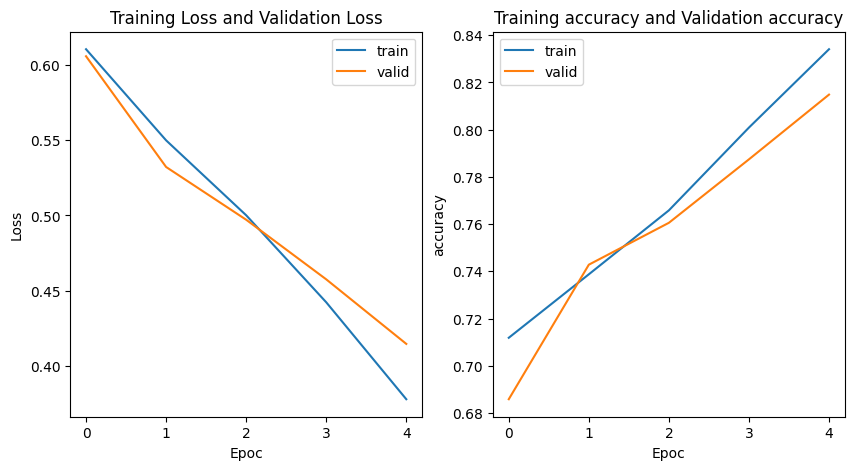

              precision    recall  f1-score   support

           0       0.86      0.89      0.88      2068
           1       0.58      0.50      0.54       601

    accuracy                           0.81      2669
   macro avg       0.72      0.70      0.71      2669
weighted avg       0.80      0.81      0.80      2669



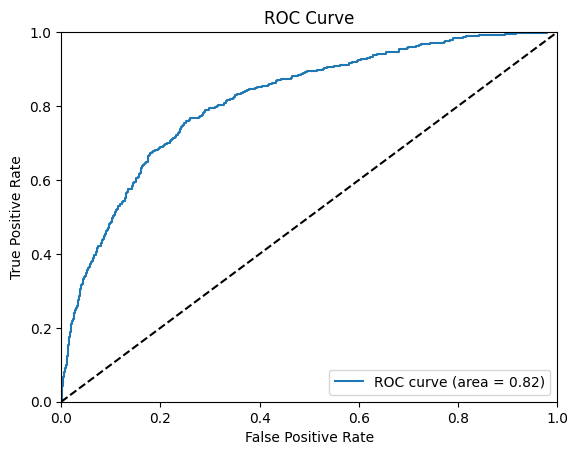

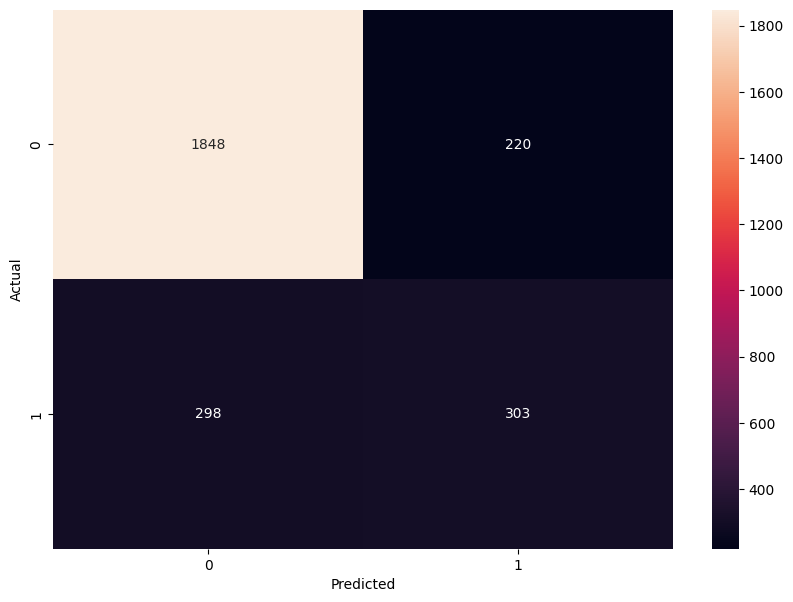

30/30 [==============================] - 13s 419ms/step
----Runnin opn with num_filters = [16, 32, 64, 128] with batch_size 32----------
gc collectd 19504
*******************************starting training for model name minorty_over_sampled_param_opt itr no 18*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D) 

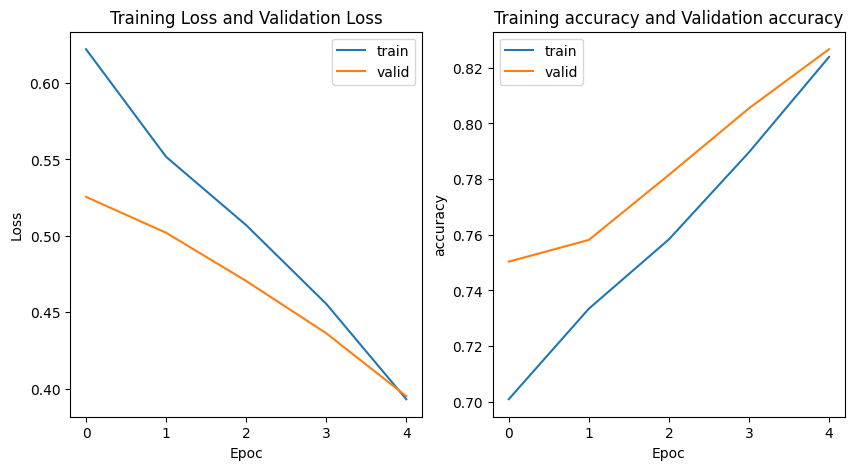

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2068
           1       0.54      0.56      0.55       601

    accuracy                           0.79      2669
   macro avg       0.71      0.71      0.71      2669
weighted avg       0.80      0.79      0.79      2669



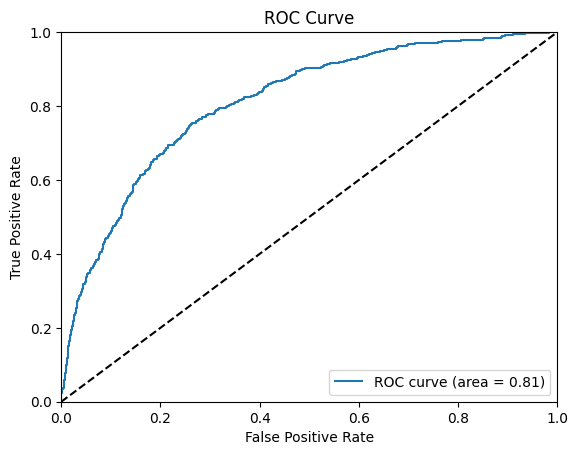

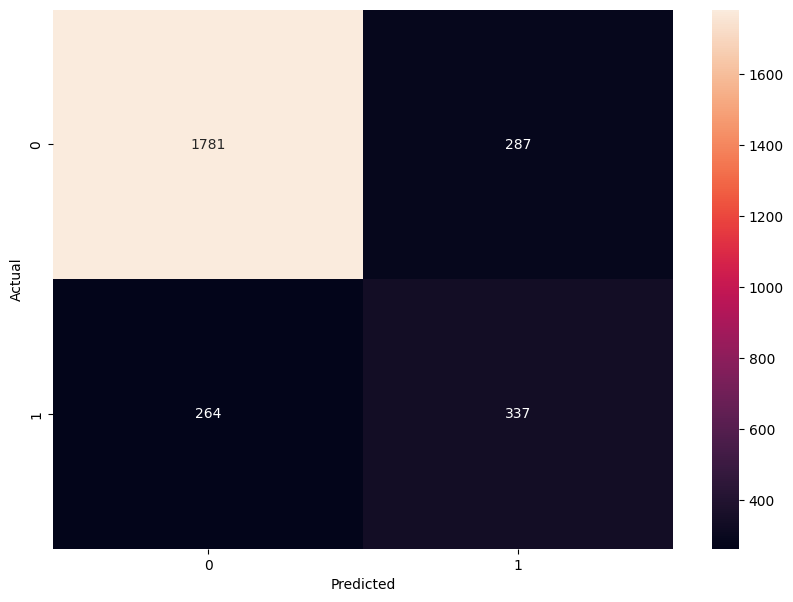

117/117 [==============================] - 14s 120ms/step
----Runnin opn with num_filters = [16, 32, 64, 128] with batch_size 64----------
gc collectd 14380
*******************************starting training for model name minorty_over_sampled_param_opt itr no 19*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D

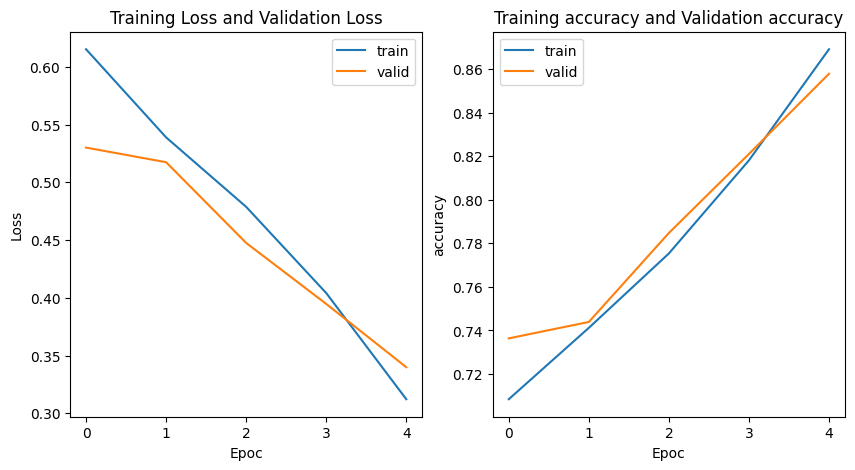

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      2068
           1       0.47      0.68      0.55       601

    accuracy                           0.75      2669
   macro avg       0.68      0.73      0.69      2669
weighted avg       0.80      0.75      0.77      2669



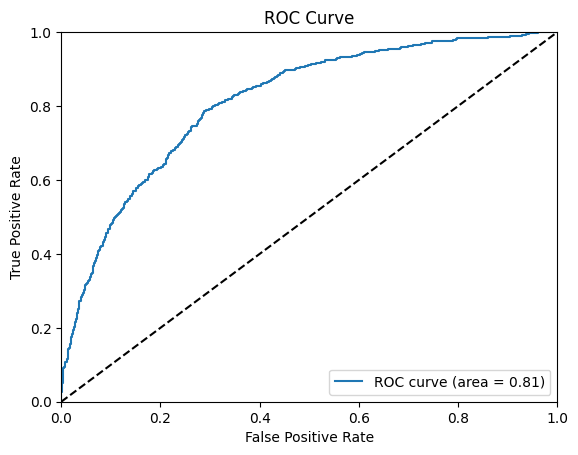

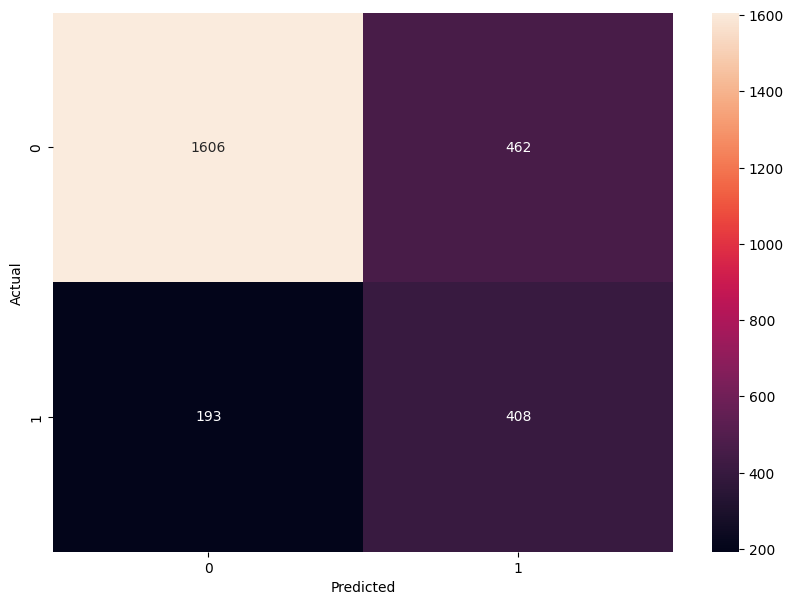

59/59 [==============================] - 13s 218ms/step
----Runnin opn with num_filters = [16, 32, 64, 128] with batch_size 128----------
gc collectd 16834
*******************************starting training for model name minorty_over_sampled_param_opt itr no 20*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)

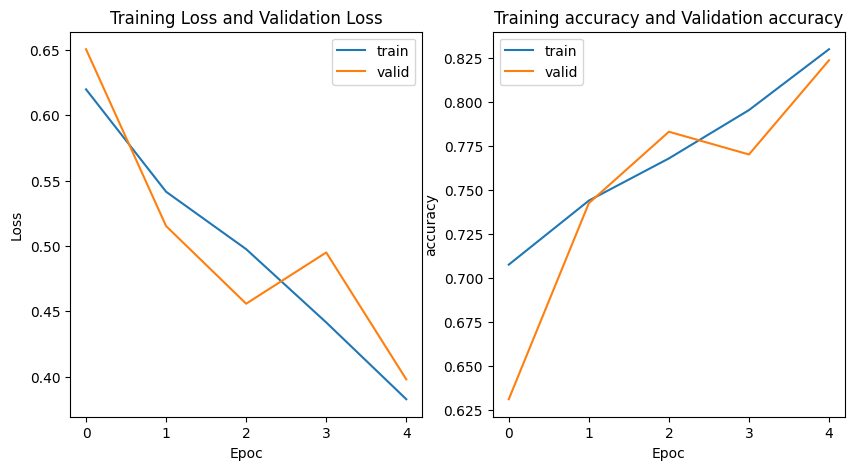

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      2068
           1       0.45      0.71      0.55       601

    accuracy                           0.74      2669
   macro avg       0.67      0.73      0.68      2669
weighted avg       0.80      0.74      0.75      2669



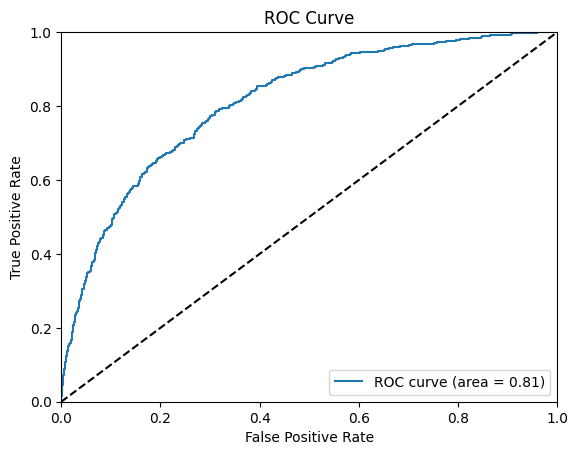

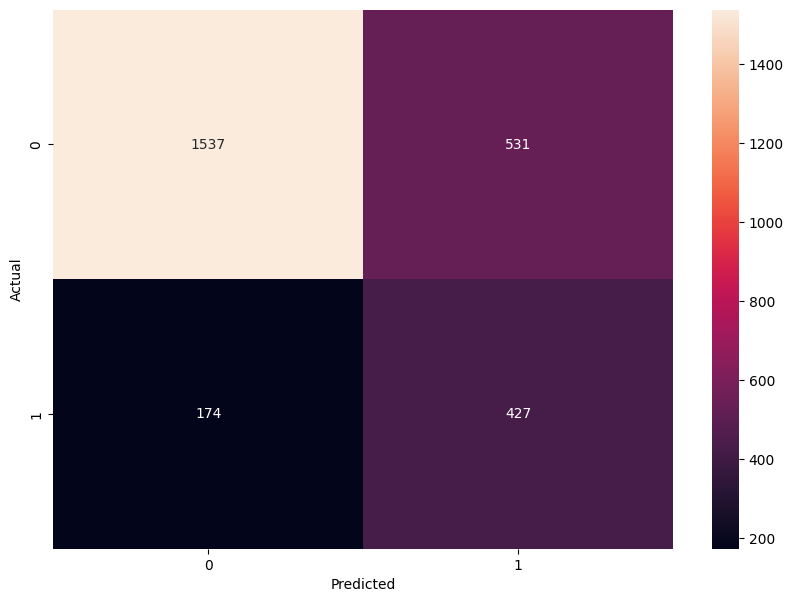

30/30 [==============================] - 13s 423ms/step


In [ ]:
modl_name='minorty_over_sampled_param_opt'
itr = 9
size_to_try = 256
num_filters=[[64,32,16],[128,64,32,16],[16,32,64],[16,32,64,128]]
batch_size = [32,64,128]
optn_lst = list(itertools.product(num_filters,batch_size))
resize_width = size_to_try
resize_height = size_to_try
input_shape = (resize_width,resize_height,1)

for opn in  optn_lst:
  print(f'----Runnin opn with num_filters = {opn[0]} with batch_size {opn[1]}----------')
  df =runCNN_more_conf(
        name=modl_name,
        itr = itr,
        resize_width = resize_width,
        resize_height = resize_height,
        num_filters=opn[0],
        ini_lr = 0.0001,
        kernel_size=(3,3),
        pool_size = (2,2),
        input_shape = input_shape,
        drop_out = 0.5,
        batch_size = opn[1],
        max_epoch = 5,
        patience_val = 2,
        x_train = x_train_bal_os,
        x_val = x_val_bal_os,
        x_test = x_test,
        y_train = y_train_bal_os,
        y_val = y_val_bal_os,
        y_test = y_test
        )
  itr = itr + 1

In [ ]:
FINAL_RESULTS_CSV = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/final_result_ver1.csv'
final_results = pd.read_csv(FINAL_RESULTS_CSV)
print(final_results.sort_values(by=['test_recall','test_f1'],ascending=False).iloc[0:3,:])

    test_accuracy  test_precision  test_recall   test_f1  test_test_roc_auc  val_accuracy  val_precision  val_recall    val_f1  val_test_roc_auc                                      model_details                            name
16       0.726115        0.438910     0.777038  0.560961           0.807815      0.775329       0.757258    0.829943  0.791936          0.858132  4LYR [128, 64, 32, 16] img_wd 256 img_ht 256 c...  minorty_over_sampled_param_opt
6        0.726115        0.437977     0.763727  0.556701           0.797998      0.727136       0.437806    0.743760  0.551171          0.801449  3LYR [64, 32, 16] img_wd 256 img_ht 256 cnn wi...                    class_weight
14       0.733983        0.446516     0.757072  0.561728           0.808133      0.757323       0.752742    0.787689  0.769819          0.835714  4LYR [128, 64, 32, 16] img_wd 256 img_ht 256 c...  minorty_over_sampled_param_opt


In [ ]:
print(final_results.sort_values(by=['test_recall','test_f1'],ascending=False)['model_details'].values[0])

4LYR [128, 64, 32, 16] img_wd 256 img_ht 256 cnn with class weight, itr = 14, name = minorty_over_sampled_param_opt


**From the above it can be seen that the 4 layer model performed best. Below is the best spcification.**

Number of filters = [128, 64, 32, 16]

Batch Size = 128

#### train the best model identified above with few more itrations. and then find optimal probability threshold.

gc collectd 15363
*******************************starting training for model name minorty_over_sampled_best_param itr no 21*****************************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 128)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 128, 128, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPo

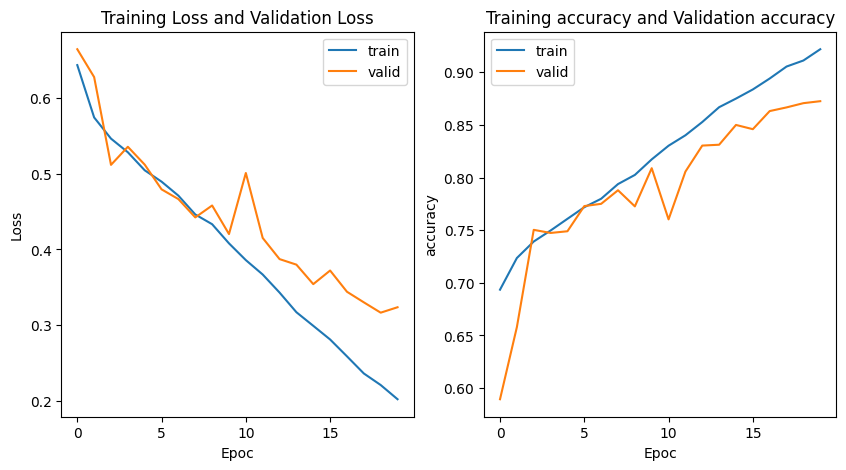

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2068
           1       0.55      0.54      0.54       601

    accuracy                           0.80      2669
   macro avg       0.71      0.71      0.71      2669
weighted avg       0.80      0.80      0.80      2669



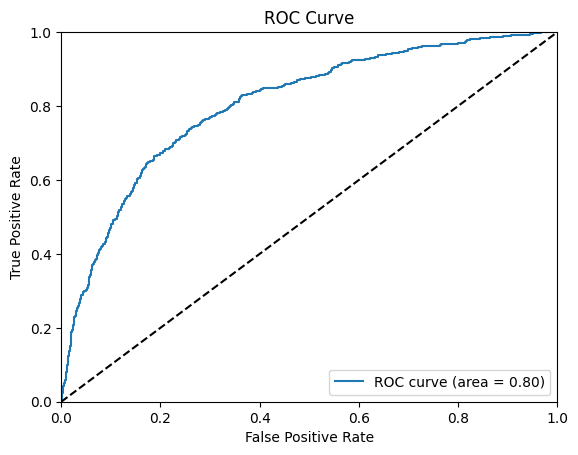

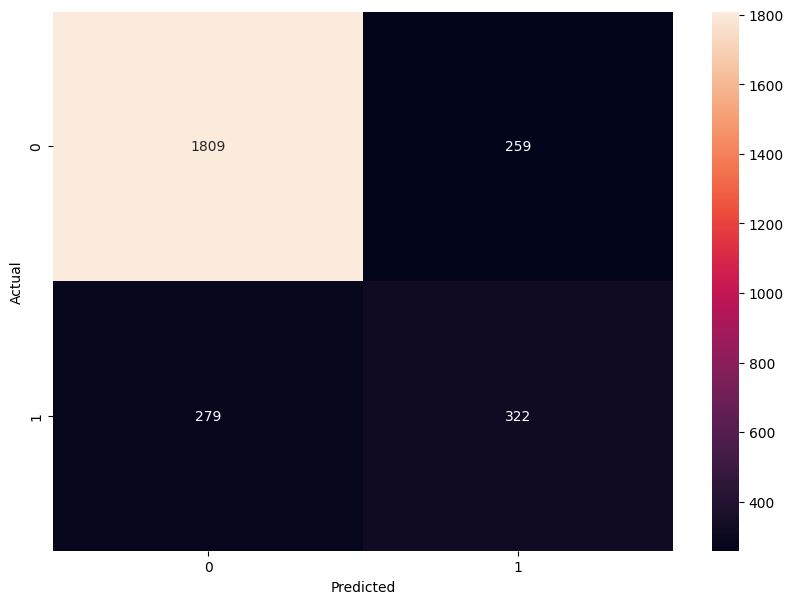

30/30 [==============================] - 14s 452ms/step


In [ ]:
modl_name='minorty_over_sampled_best_param'
itr = 21
size_to_try = 256
num_filters=[128,64,32,16]
batch_size = 128
resize_width = size_to_try
resize_height = size_to_try
input_shape = (resize_width,resize_height,1)

df =runCNN_more_conf(
      name=modl_name,
      itr = itr,
      resize_width = resize_width,
      resize_height = resize_height,
      num_filters=num_filters,
      ini_lr = 0.0001,
      kernel_size=(3,3),
      pool_size = (2,2),
      input_shape = input_shape,
      drop_out = 0.5,
      batch_size = batch_size,
      max_epoch = 20,
      patience_val = 3,
      x_train = x_train_bal_os,
      x_val = x_val_bal_os,
      x_test = x_test,
      y_train = y_train_bal_os,
      y_val = y_val_bal_os,
      y_test = y_test,
      # load_inital_wts_from = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/minorty_over_sampled_param_opt_14.h5' # this is not helping.
      )
itr = itr + 1

In [ ]:
FINAL_RESULTS_CSV = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/final_result_ver1.csv'
final_results = pd.read_csv(FINAL_RESULTS_CSV)
print(final_results.sort_values(by=['test_recall','test_f1'],ascending=False).iloc[0:3,:])

    test_accuracy  test_precision  test_recall   test_f1  test_test_roc_auc  val_accuracy  val_precision  val_recall    val_f1  val_test_roc_auc                                      model_details                            name
16       0.726115        0.438910     0.777038  0.560961           0.807815      0.775329       0.757258    0.829943  0.791936          0.858132  4LYR [128, 64, 32, 16] img_wd 256 img_ht 256 c...  minorty_over_sampled_param_opt
6        0.726115        0.437977     0.763727  0.556701           0.797998      0.727136       0.437806    0.743760  0.551171          0.801449  3LYR [64, 32, 16] img_wd 256 img_ht 256 cnn wi...                    class_weight
14       0.733983        0.446516     0.757072  0.561728           0.808133      0.757323       0.752742    0.787689  0.769819          0.835714  4LYR [128, 64, 32, 16] img_wd 256 img_ht 256 c...  minorty_over_sampled_param_opt


In [ ]:
print(final_results.sort_values(by=['test_recall','test_f1'],ascending=False)['model_details'].values[0])

4LYR [128, 64, 32, 16] img_wd 256 img_ht 256 cnn with class weight, itr = 14, name = minorty_over_sampled_param_opt


 * Looks like trainng for more number of epoch does not imporove the test accuracy/f1 score.
 * so will use the prvious itr # 14 number of model for finding  optimal probability threshold.


### 3. finding best probability threshold  

In [ ]:
mdl = getCNN(num_filters= [128, 64, 32, 16],
                  kernel_size=(3,3),
                  pool_size = (2,2),
                  input_shape = (256,256,1),
                  drop_out = 0.5,
                  ini_lr =  0.0001)
mdl.load_weights(r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/minorty_over_sampled_param_opt_14.h5')
test_ds = make_dataset_1(x_test,y_test,img_width=256, img_height=256, batch_size = 128,do_resize = True)

21/21 [==============================] - 10s 451ms/step


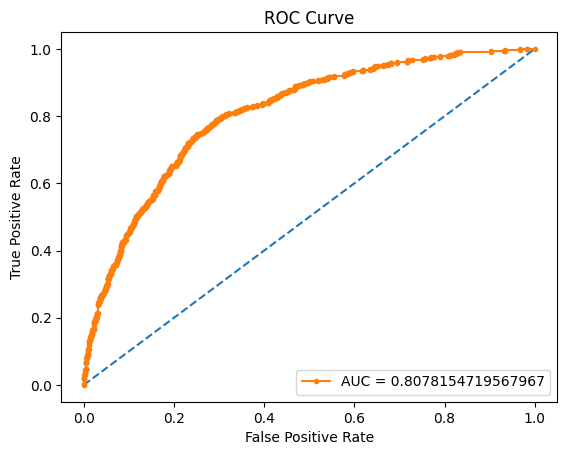

In [ ]:
PROD_THRESHOLD = 0.5
y_test = []
for i, (_, labels) in enumerate(test_ds):
    y_test.append(labels.numpy())
y_test = np.concatenate(y_test)

y_test_probs = mdl.predict(test_ds)
y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)

false_pos_rate, true_pos_rate, proba = roc_curve(y_test, y_test_probs[:, -1])
plt.figure()
plt.plot([0,1], [0,1], linestyle="--") # plot random curve
plt.plot(false_pos_rate, true_pos_rate, marker=".", label=f"AUC = {roc_auc_score(y_test, y_test_probs[:, -1])}")
plt.title("ROC Curve")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [ ]:
optimal_proba_cutoff = sorted(list(zip(np.abs(true_pos_rate - false_pos_rate), proba)), key=lambda i: i[0], reverse=True)[0][1]
roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in y_test_probs[:, -1]]

In [ ]:
print(f'Optimum probability = {optimal_proba_cutoff}')

Optimum probability = 0.5500411987304688


In [ ]:
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(y_test, y_test_pred), accuracy_score(y_test, roc_predictions)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(y_test, y_test_pred), precision_score(y_test, roc_predictions)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(y_test, y_test_pred), recall_score(y_test, roc_predictions)))
print("F1 Score Before and After Thresholding: {}, {}".format(f1_score(y_test, y_test_pred), f1_score(y_test, roc_predictions)))

Accuracy Score Before and After Thresholding: 0.7261146496815286, 0.7485949793930311
Precision Score Before and After Thresholding: 0.43890977443609025, 0.463768115942029
Recall Score Before and After Thresholding: 0.7770382695507487, 0.7454242928452579
F1 Score Before and After Thresholding: 0.5609609609609609, 0.5717932354818124


In [ ]:
PROD_THRESHOLD=0.5500411987304688
y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      2068
           1       0.46      0.75      0.57       601

    accuracy                           0.75      2669
   macro avg       0.69      0.75      0.70      2669
weighted avg       0.81      0.75      0.77      2669



**From the above it can be seen that F1  has improved a little bit with the comparistion with non probability optimized model. Refer classification report using the non optimized model as shown below**

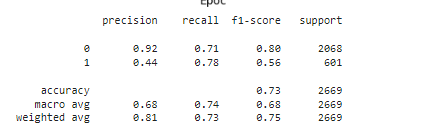

**From the above it can be seen that probability optimization is not helping much to improve the model**  

##  Step 2: Apply Transfer Learning model for classification [4 points]

plan to attempt the following models


1. VGG16 Model
2. VGG19 Model
3. MobilenetV2 Model
4. Inception v3 Model
5. ResNet Model
6. Efficient Net

### Trying VGG16 with minorty over sampled data balanced data set

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
IMG_HEIGHT=224
IMG_WIDTH=224
BATCH_SIZE=16
def make_dataset_vgg16(x_file_list, y_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, batch_size = BATCH_SIZE, do_resize=True, no_channels = 1):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(no_channels))
      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))
      image = preprocess_input(image)
      return image, label

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
itr = 33
max_epoch = 20
lr = 0.0001
drop_out = 0.5
batch_size = 128
resize_width = 224
resize_height = 224
input_shape = (resize_width,resize_height,3)


train_ds = make_dataset_vgg16(x_train_bal_os, y_train_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
val_ds = make_dataset_vgg16(x_val_bal_os,y_val_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
test_ds = make_dataset_vgg16(x_test,y_test,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)

name = 'vgg16_ovr_sampl_using_process_input'
ver_fl_name = name +'_'+str(itr)+'.h5'
his_fl_name = name  +'_'+str(itr)+'_history.pkl'
fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
ver_fl_name = os.path.join(fldr_name,ver_fl_name)
his_fl_name = os.path.join(fldr_name,his_fl_name)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()
base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
base_model.trainable = False


model = Sequential([
    base_model
])

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(BatchNormalization())
model.add(Dropout(drop_out))

model.add(Dense(activation = 'relu', units = 64))
model.add(BatchNormalization())
model.add(Dropout(drop_out/2))

model.add(Dense(activation = 'sigmoid', units = 1))

print(model.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               3211392   
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                      

In [ ]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                               decay_steps=10000,
                                                               decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ver_fl_name,
                                                      save_best_only=True,
                                                      monitor='val_accuracy',
                                                      save_weights_only= True,
                                                      mode='max',
                                                      verbose=0)
model_erly_stp = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=3,
                                                verbose=0)
histroy = model.fit(train_ds,
                    epochs=max_epoch,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint,model_erly_stp])

pickle.dump(histroy, open(his_fl_name,'wb'))

Epoch 1/20
262/262 [==============================] - 319s 1s/step - loss: 0.5545 - accuracy: 0.7446 - val_loss: 0.4600 - val_accuracy: 0.7872
Epoch 2/20
262/262 [==============================] - 304s 1s/step - loss: 0.4429 - accuracy: 0.7974 - val_loss: 0.4096 - val_accuracy: 0.8154
Epoch 3/20
262/262 [==============================] - 343s 1s/step - loss: 0.3738 - accuracy: 0.8323 - val_loss: 0.3676 - val_accuracy: 0.8396
Epoch 4/20
262/262 [==============================] - 347s 1s/step - loss: 0.3108 - accuracy: 0.8699 - val_loss: 0.3342 - val_accuracy: 0.8613
Epoch 5/20
262/262 [==============================] - 338s 1s/step - loss: 0.2578 - accuracy: 0.8945 - val_loss: 0.3237 - val_accuracy: 0.8718
Epoch 6/20
262/262 [==============================] - 330s 1s/step - loss: 0.2195 - accuracy: 0.9143 - val_loss: 0.2870 - val_accuracy: 0.8914
Epoch 7/20
262/262 [==============================] - 286s 1s/step - loss: 0.1803 - accuracy: 0.9316 - val_loss: 0.2886 - val_accuracy: 0.8987

21/21 [==============================] - 37s 2s/step


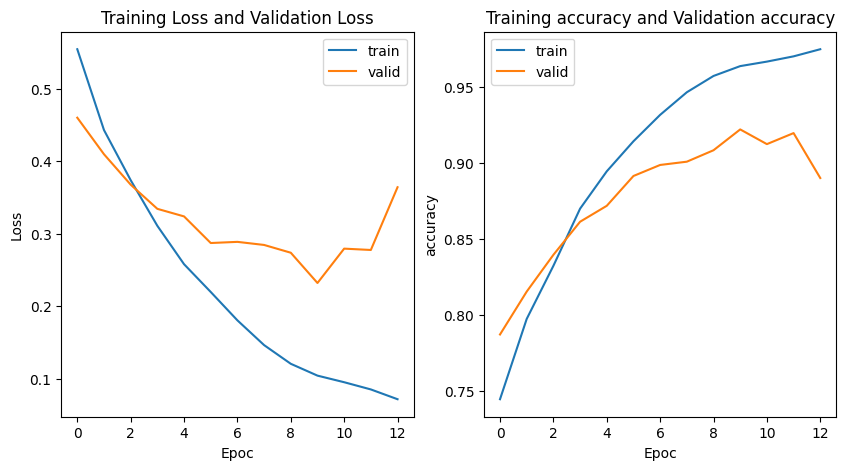

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      2068
           1       0.60      0.54      0.57       601

    accuracy                           0.81      2669
   macro avg       0.73      0.72      0.72      2669
weighted avg       0.81      0.81      0.81      2669



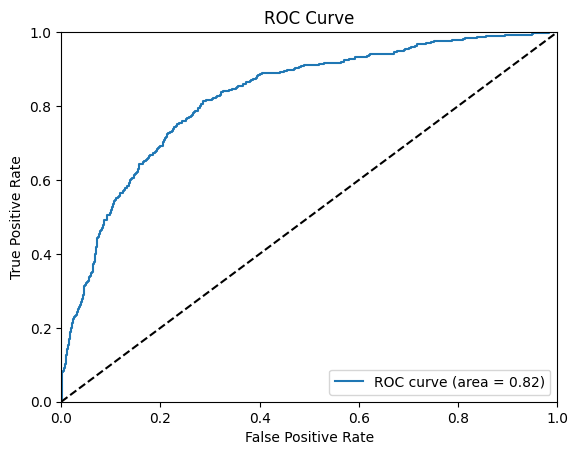

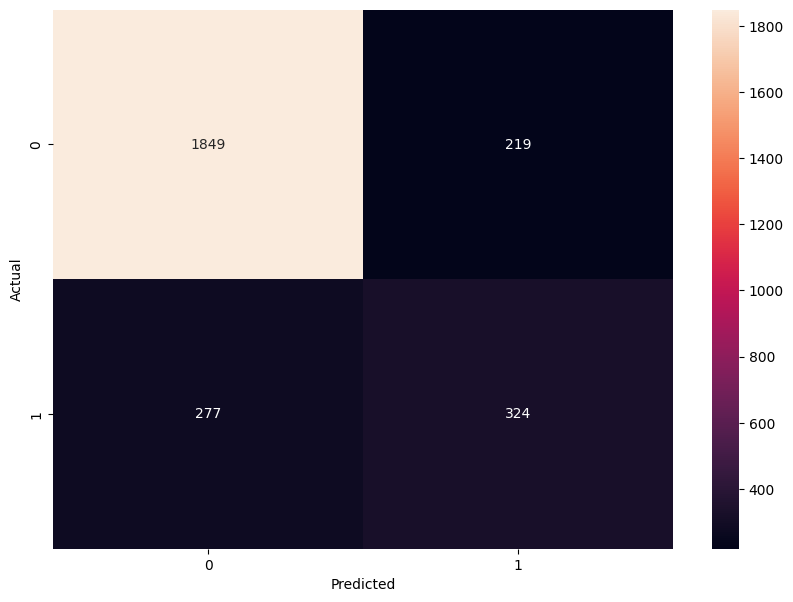

30/30 [==============================] - 29s 949ms/step


In [ ]:
model.load_weights(ver_fl_name)
PROD_THRESHOLD = 0.5
y_test = []
for i, (_, labels) in enumerate(test_ds):
    y_test.append(labels.numpy())
y_test = np.concatenate(y_test)

y_test_probs = model.predict(test_ds)
y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)

plotLossAcc(histroy)
print(classification_report(y_test, y_test_pred))
plot_roc_curve(y_test, y_test_probs)
plot_confusion_matrix(y_test, y_test_pred)
df1 = evaluate_metrics(y_test, y_test_pred,y_test_probs,col_labl='test')


y_val = []
for i, (_, labels) in enumerate(val_ds):
    y_val.append(labels.numpy())
y_val = np.concatenate(y_val)

y_val_probs = model.predict(val_ds)
y_val_pred = (y_val_probs >= PROD_THRESHOLD).astype(int)
df2 = evaluate_metrics(y_val, y_val_pred,y_val_probs,col_labl='val')

df = pd.concat([df1,df2],axis=1)

mdl_dtls = f'itr = {itr}, name = {name}'
df['model_details'] = [mdl_dtls]
df['name'] = [name]
writeResults(df)

In [ ]:
FINAL_RESULTS_CSV = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/final_result_ver1.csv'
final_results = pd.read_csv(FINAL_RESULTS_CSV)
print(final_results.sort_values(by=['test_test_roc_auc'],ascending=False).iloc[0:3,:])

    test_accuracy  test_precision  test_recall   test_f1  test_test_roc_auc  val_accuracy  val_precision  val_recall    val_f1  val_test_roc_auc                                      model_details                                 name
25       0.814163        0.596685     0.539101  0.566434           0.824853      0.922064       0.902922    0.950965  0.926321          0.966499  itr = 33, name = vgg16_ovr_sampl_using_process...  vgg16_ovr_sampl_using_process_input
19       0.805920        0.579350     0.504160  0.539146           0.815794      0.814835       0.877614    0.744392  0.805532          0.910454  3LYR [16, 32, 64] img_wd 256 img_ht 256 cnn wi...       minorty_over_sampled_param_opt
10       0.775571        0.501263     0.660566  0.569993           0.813692      0.782048       0.812077    0.750652  0.780157          0.868393  3LYR [64, 32, 16] img_wd 256 img_ht 256 cnn wi...       minorty_over_sampled_param_opt


* VGG16 seems to perfrom better than the hyper parameter optimized non transfer learning model.
* also there is more overfitting as seen from gap between the training and validation loss.

### Trying VGG19 with minorty over sampled data balanced data set

In [ ]:
from tensorflow.keras.applications.vgg19 import preprocess_input
IMG_HEIGHT=224
IMG_WIDTH=224
BATCH_SIZE=16
def make_dataset_vgg19(x_file_list, y_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, batch_size = BATCH_SIZE, do_resize=True, no_channels = 1):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(no_channels))
      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))
      image = preprocess_input(image)
      return image, label

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
itr = 34
max_epoch = 20
lr = 0.0001
drop_out = 0.5
batch_size = 128
resize_width = 224
resize_height = 224
input_shape = (resize_width,resize_height,3)


train_ds = make_dataset_vgg19(x_train_bal_os, y_train_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
val_ds = make_dataset_vgg19(x_val_bal_os,y_val_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
test_ds = make_dataset_vgg19(x_test,y_test,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)

name = 'vgg19_ovr_sampl_using_process_input'
ver_fl_name = name +'_'+str(itr)+'.h5'
his_fl_name = name  +'_'+str(itr)+'_history.pkl'
fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
ver_fl_name = os.path.join(fldr_name,ver_fl_name)
his_fl_name = os.path.join(fldr_name,his_fl_name)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()
base_model = VGG19(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
base_model.trainable = False


model = Sequential([
    base_model
])

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(BatchNormalization())
model.add(Dropout(drop_out))

model.add(Dense(activation = 'relu', units = 64))
model.add(BatchNormalization())
model.add(Dropout(drop_out/2))

model.add(Dense(activation = 'sigmoid', units = 1))

print(model.summary())

80134624/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                82

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                               decay_steps=10000,
                                                               decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ver_fl_name,
                                                      save_best_only=True,
                                                      monitor='val_accuracy',
                                                      save_weights_only= True,
                                                      mode='max',
                                                      verbose=0)
model_erly_stp = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=3,
                                                verbose=0)
histroy = model.fit(train_ds,
                    epochs=max_epoch,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint,model_erly_stp])

pickle.dump(histroy, open(his_fl_name,'wb'))

Epoch 1/20
262/262 [==============================] - 342s 1s/step - loss: 0.5595 - accuracy: 0.7372 - val_loss: 0.4724 - val_accuracy: 0.7866
Epoch 2/20
262/262 [==============================] - 302s 1s/step - loss: 0.4482 - accuracy: 0.7939 - val_loss: 0.4163 - val_accuracy: 0.8095
Epoch 3/20
262/262 [==============================] - 295s 1s/step - loss: 0.3822 - accuracy: 0.8302 - val_loss: 0.4127 - val_accuracy: 0.8218
Epoch 4/20
262/262 [==============================] - 275s 1s/step - loss: 0.3231 - accuracy: 0.8599 - val_loss: 0.3788 - val_accuracy: 0.8409
Epoch 5/20
262/262 [==============================] - 253s 963ms/step - loss: 0.2753 - accuracy: 0.8873 - val_loss: 0.3349 - val_accuracy: 0.8715
Epoch 6/20
262/262 [==============================] - 269s 1s/step - loss: 0.2332 - accuracy: 0.9084 - val_loss: 0.3586 - val_accuracy: 0.8670
Epoch 7/20
262/262 [==============================] - 268s 1s/step - loss: 0.1949 - accuracy: 0.9249 - val_loss: 0.3245 - val_accuracy: 0.8

21/21 [==============================] - 17s 816ms/step


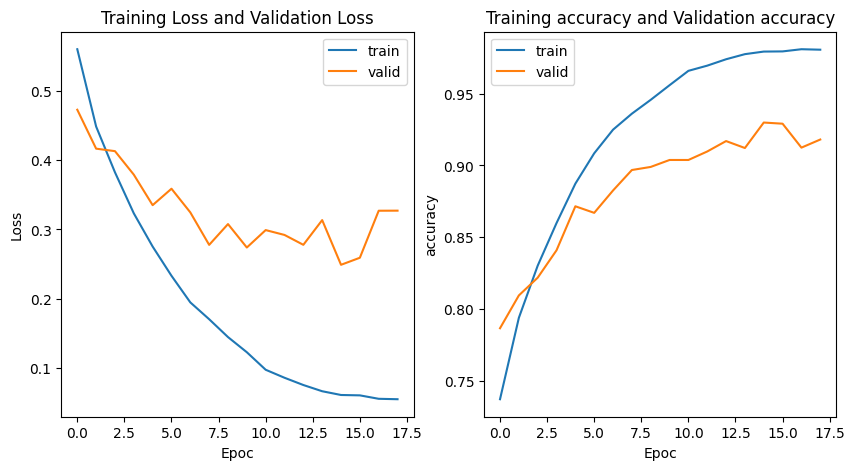

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2068
           1       0.59      0.43      0.50       601

    accuracy                           0.80      2669
   macro avg       0.72      0.67      0.69      2669
weighted avg       0.79      0.80      0.79      2669



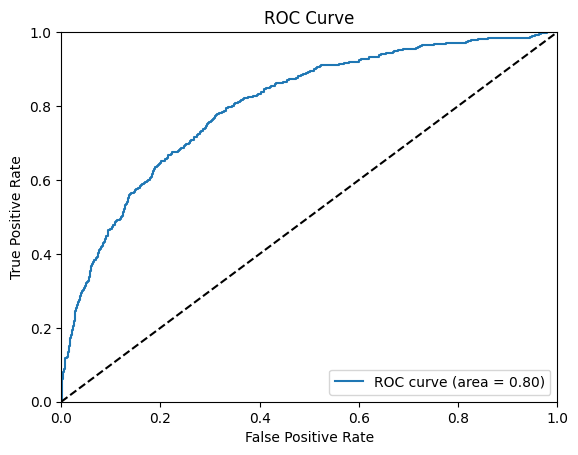

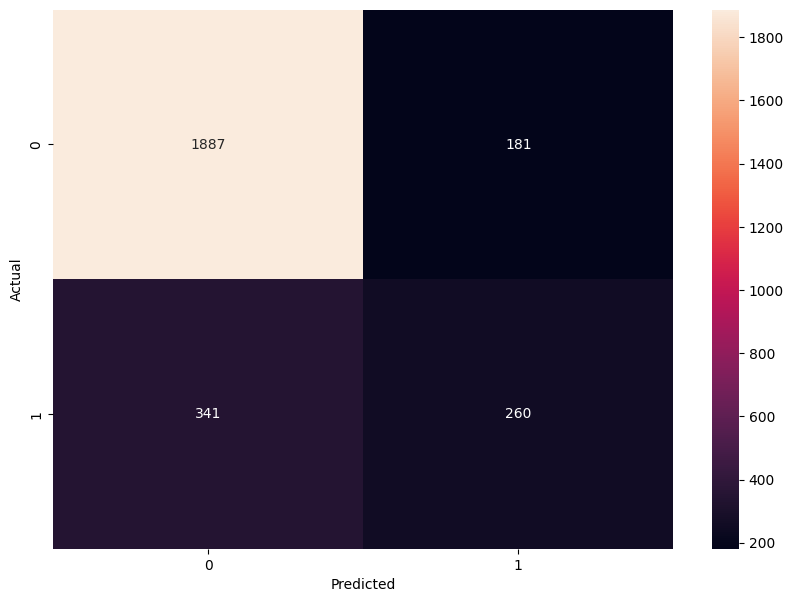

30/30 [==============================] - 26s 858ms/step


In [ ]:
model.load_weights(ver_fl_name)
PROD_THRESHOLD = 0.5
y_test = []
for i, (_, labels) in enumerate(test_ds):
    y_test.append(labels.numpy())
y_test = np.concatenate(y_test)

y_test_probs = model.predict(test_ds)
y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)
histroy = pickle.load(open(his_fl_name,'rb'))
plotLossAcc(histroy)
print(classification_report(y_test, y_test_pred))
plot_roc_curve(y_test, y_test_probs)
plot_confusion_matrix(y_test, y_test_pred)
df1 = evaluate_metrics(y_test, y_test_pred,y_test_probs,col_labl='test')


y_val = []
for i, (_, labels) in enumerate(val_ds):
    y_val.append(labels.numpy())
y_val = np.concatenate(y_val)

y_val_probs = model.predict(val_ds)
y_val_pred = (y_val_probs >= PROD_THRESHOLD).astype(int)
df2 = evaluate_metrics(y_val, y_val_pred,y_val_probs,col_labl='val')

df = pd.concat([df1,df2],axis=1)

mdl_dtls = f'itr = {itr}, name = {name}'
df['model_details'] = [mdl_dtls]
df['name'] = [name]
writeResults(df)

In [ ]:
FINAL_RESULTS_CSV = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/final_result_ver1.csv'
final_results = pd.read_csv(FINAL_RESULTS_CSV)
print(final_results.sort_values(by=['test_test_roc_auc'],ascending=False).iloc[0:3,:])

    test_accuracy  test_precision  test_recall   test_f1  test_test_roc_auc  val_accuracy  val_precision  val_recall    val_f1  val_test_roc_auc                                      model_details                                 name
25       0.814163        0.596685     0.539101  0.566434           0.824853      0.922064       0.902922    0.950965  0.926321          0.966499  itr = 33, name = vgg16_ovr_sampl_using_process...  vgg16_ovr_sampl_using_process_input
19       0.805920        0.579350     0.504160  0.539146           0.815794      0.814835       0.877614    0.744392  0.805532          0.910454  3LYR [16, 32, 64] img_wd 256 img_ht 256 cnn wi...       minorty_over_sampled_param_opt
10       0.775571        0.501263     0.660566  0.569993           0.813692      0.782048       0.812077    0.750652  0.780157          0.868393  3LYR [64, 32, 16] img_wd 256 img_ht 256 cnn wi...       minorty_over_sampled_param_opt


* VGG19 is not performig better in comparision to vgg16.
* there is more overfitting as seen from big gap between the training and validation loss.

### trying mobile net ver 3 NO POOLING

In [ ]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
IMG_HEIGHT=224
IMG_WIDTH=224
BATCH_SIZE=16
def make_dataset_mobileNetv3(x_file_list, y_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, batch_size = BATCH_SIZE, do_resize=True, no_channels = 1):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(no_channels))
      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))
      image = preprocess_input(image)
      return image, label

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
from tensorflow.keras.applications import MobileNetV2
itr = 35
max_epoch = 20
lr = 0.0001
drop_out = 0.5
batch_size = 16
resize_width = 224
resize_height = 224
input_shape = (resize_width,resize_height,3)


train_ds = make_dataset_mobileNetv3(x_train_bal_os, y_train_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
val_ds = make_dataset_mobileNetv3(x_val_bal_os,y_val_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
test_ds = make_dataset_mobileNetv3(x_test,y_test,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)

name = 'MobileNetV2_ovr_sampl_using_process_input'
ver_fl_name = name +'_'+str(itr)+'.h5'
his_fl_name = name  +'_'+str(itr)+'_history.pkl'
fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
ver_fl_name = os.path.join(fldr_name,ver_fl_name)
his_fl_name = os.path.join(fldr_name,his_fl_name)

In [ ]:
base_model = MobileNetV2(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape)
base_model.trainable = False


model = Sequential([
    base_model
])

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(BatchNormalization())
model.add(Dropout(drop_out))

model.add(Dense(activation = 'relu', units = 64))
model.add(BatchNormalization())
model.add(Dropout(drop_out/2))

model.add(Dense(activation = 'sigmoid', units = 1))

print(model.summary())

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                           

In [ ]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                               decay_steps=10000,
                                                               decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ver_fl_name,
                                                      save_best_only=True,
                                                      monitor='val_accuracy',
                                                      save_weights_only= True,
                                                      mode='max',
                                                      verbose=0)
model_erly_stp = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=3,
                                                verbose=0)
histroy = model.fit(train_ds,
                    epochs=max_epoch,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint,model_erly_stp])

pickle.dump(histroy, open(his_fl_name,'wb'))

Epoch 1/20
2093/2093 [==============================] - 236s 106ms/step - loss: 0.6095 - accuracy: 0.7037 - val_loss: 0.5130 - val_accuracy: 0.7501
Epoch 2/20
2093/2093 [==============================] - 221s 106ms/step - loss: 0.5427 - accuracy: 0.7390 - val_loss: 0.4870 - val_accuracy: 0.7702
Epoch 3/20
2093/2093 [==============================] - 228s 109ms/step - loss: 0.4991 - accuracy: 0.7630 - val_loss: 0.4522 - val_accuracy: 0.7888
Epoch 4/20
2093/2093 [==============================] - 253s 121ms/step - loss: 0.4614 - accuracy: 0.7849 - val_loss: 0.4480 - val_accuracy: 0.7915
Epoch 5/20
2093/2093 [==============================] - 200s 96ms/step - loss: 0.4308 - accuracy: 0.8053 - val_loss: 0.4341 - val_accuracy: 0.8041
Epoch 6/20
2093/2093 [==============================] - 198s 94ms/step - loss: 0.3849 - accuracy: 0.8317 - val_loss: 0.4192 - val_accuracy: 0.8210
Epoch 7/20
2093/2093 [==============================] - 194s 93ms/step - loss: 0.3516 - accuracy: 0.8488 - val_los

167/167 [==============================] - 16s 90ms/step


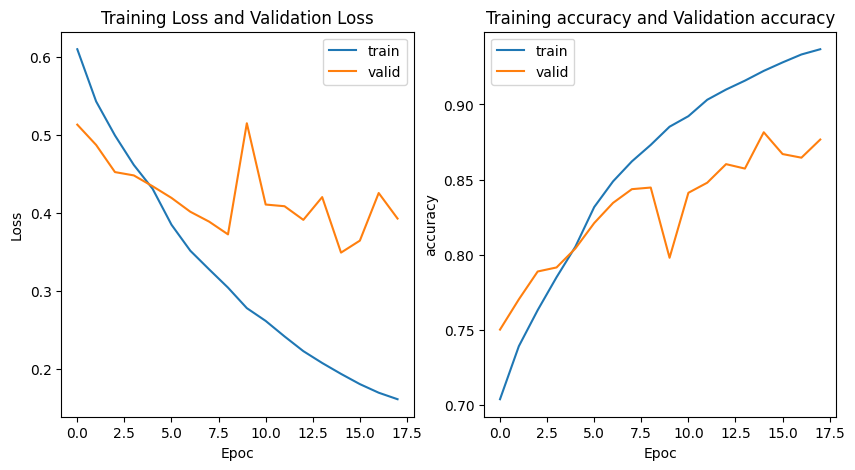

              precision    recall  f1-score   support

           0       0.86      0.83      0.84      2068
           1       0.47      0.52      0.49       601

    accuracy                           0.76      2669
   macro avg       0.66      0.67      0.67      2669
weighted avg       0.77      0.76      0.76      2669



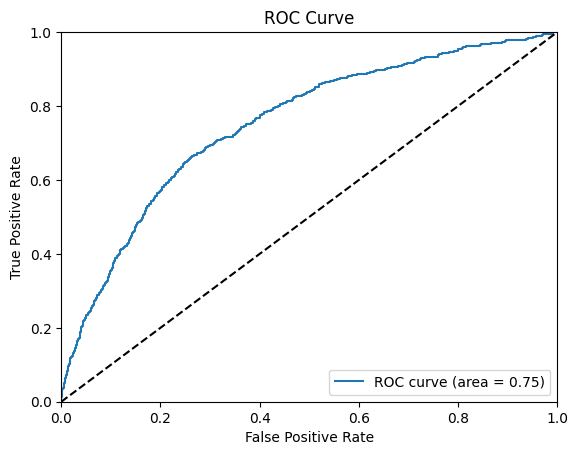

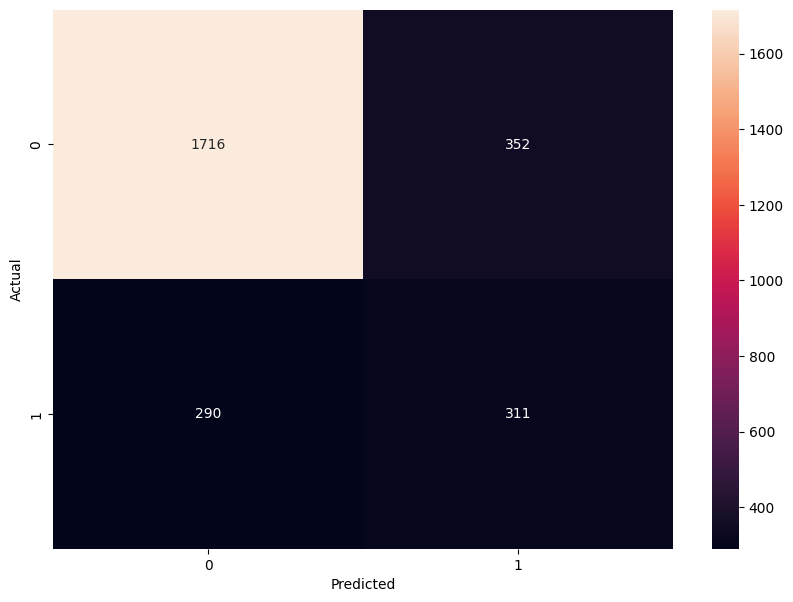

233/233 [==============================] - 19s 81ms/step


In [ ]:
model.load_weights(ver_fl_name)
PROD_THRESHOLD = 0.5
y_test = []
for i, (_, labels) in enumerate(test_ds):
    y_test.append(labels.numpy())
y_test = np.concatenate(y_test)

y_test_probs = model.predict(test_ds)
y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)
histroy = pickle.load(open(his_fl_name,'rb'))
plotLossAcc(histroy)
print(classification_report(y_test, y_test_pred))
plot_roc_curve(y_test, y_test_probs)
plot_confusion_matrix(y_test, y_test_pred)
df1 = evaluate_metrics(y_test, y_test_pred,y_test_probs,col_labl='test')


y_val = []
for i, (_, labels) in enumerate(val_ds):
    y_val.append(labels.numpy())
y_val = np.concatenate(y_val)

y_val_probs = model.predict(val_ds)
y_val_pred = (y_val_probs >= PROD_THRESHOLD).astype(int)
df2 = evaluate_metrics(y_val, y_val_pred,y_val_probs,col_labl='val')

df = pd.concat([df1,df2],axis=1)

mdl_dtls = f'itr = {itr}, name = {name}'
df['model_details'] = [mdl_dtls]
df['name'] = [name]
writeResults(df)

* this mobile net model with no poolling  is not perfroming well. its one of worst model so far

### trying Inception v3 model

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input
def make_dataset_inception_v3(x_file_list, y_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, batch_size = BATCH_SIZE, do_resize=True, no_channels = 1):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(no_channels))
      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))
      image = preprocess_input(image)
      return image, label

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
itr = 36
max_epoch = 20
lr = 0.0001
drop_out = 0.5
batch_size = 16
resize_width = 224
resize_height = 224
input_shape = (resize_width,resize_height,3)


train_ds = make_dataset_inception_v3(x_train_bal_os, y_train_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
val_ds = make_dataset_inception_v3(x_val_bal_os,y_val_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
test_ds = make_dataset_inception_v3(x_test,y_test,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)

name = 'InceptionV3_ovr_sampl_using_process_input'
ver_fl_name = name +'_'+str(itr)+'.h5'
his_fl_name = name  +'_'+str(itr)+'_history.pkl'
fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
ver_fl_name = os.path.join(fldr_name,ver_fl_name)
his_fl_name = os.path.join(fldr_name,his_fl_name)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()
base_model = InceptionV3(include_top=False,
                        weights='imagenet',
                        pooling='max',
                        input_shape=input_shape)
base_model.trainable = False


model = Sequential([
    base_model
])

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(BatchNormalization())
model.add(Dropout(drop_out))

model.add(Dense(activation = 'relu', units = 64))
model.add(BatchNormalization())
model.add(Dropout(drop_out/2))

model.add(Dense(activation = 'sigmoid', units = 1))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization_94 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                        

In [ ]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                               decay_steps=10000,
                                                               decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ver_fl_name,
                                                      save_best_only=True,
                                                      monitor='val_accuracy',
                                                      save_weights_only= True,
                                                      mode='max',
                                                      verbose=0)
model_erly_stp = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=3,
                                                verbose=0)
histroy = model.fit(train_ds,
                    epochs=max_epoch,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint,model_erly_stp])

pickle.dump(histroy, open(his_fl_name,'wb'))

Epoch 1/20
2093/2093 [==============================] - 230s 105ms/step - loss: 0.6286 - accuracy: 0.6908 - val_loss: 0.5205 - val_accuracy: 0.7431
Epoch 2/20
2093/2093 [==============================] - 205s 98ms/step - loss: 0.5587 - accuracy: 0.7268 - val_loss: 0.4996 - val_accuracy: 0.7541
Epoch 3/20
2093/2093 [==============================] - 203s 97ms/step - loss: 0.5330 - accuracy: 0.7431 - val_loss: 0.4889 - val_accuracy: 0.7619
Epoch 4/20
2093/2093 [==============================] - 208s 99ms/step - loss: 0.5202 - accuracy: 0.7507 - val_loss: 0.4837 - val_accuracy: 0.7624
Epoch 5/20
2093/2093 [==============================] - 204s 97ms/step - loss: 0.5091 - accuracy: 0.7570 - val_loss: 0.4819 - val_accuracy: 0.7673
Epoch 6/20
2093/2093 [==============================] - 200s 95ms/step - loss: 0.5008 - accuracy: 0.7618 - val_loss: 0.4816 - val_accuracy: 0.7659
Epoch 7/20
2093/2093 [==============================] - 201s 96ms/step - loss: 0.4942 - accuracy: 0.7650 - val_loss: 

167/167 [==============================] - 18s 95ms/step


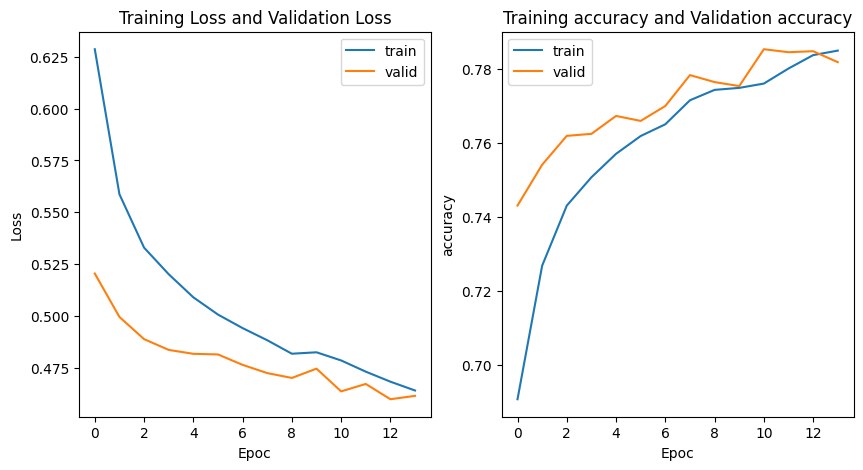

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      2068
           1       0.45      0.80      0.58       601

    accuracy                           0.74      2669
   macro avg       0.69      0.76      0.69      2669
weighted avg       0.82      0.74      0.76      2669



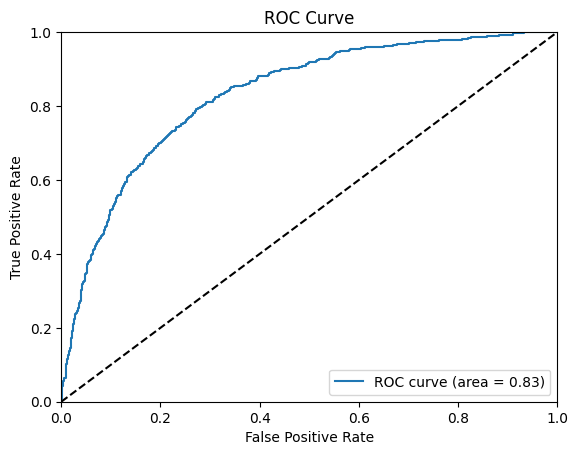

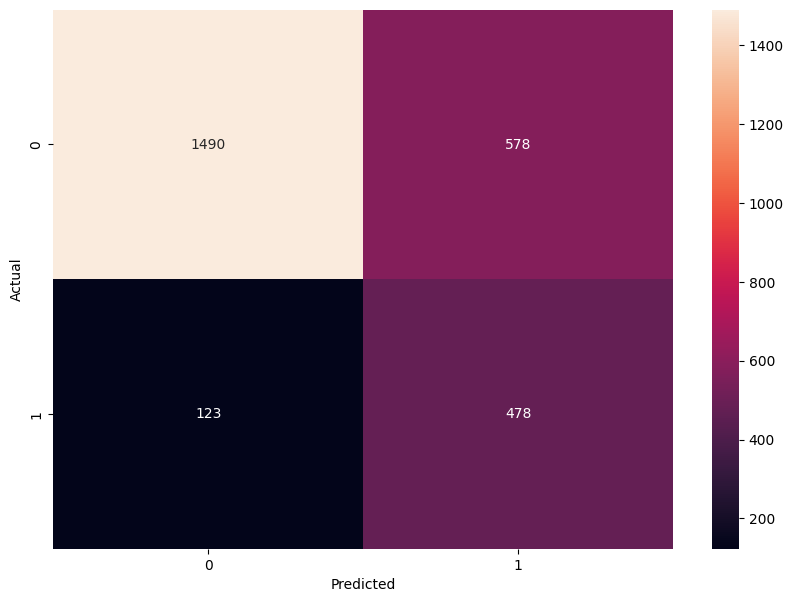

233/233 [==============================] - 19s 83ms/step


In [ ]:
model.load_weights(ver_fl_name)
PROD_THRESHOLD = 0.5
y_test = []
for i, (_, labels) in enumerate(test_ds):
    y_test.append(labels.numpy())
y_test = np.concatenate(y_test)

y_test_probs = model.predict(test_ds)
y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)
histroy = pickle.load(open(his_fl_name,'rb'))
plotLossAcc(histroy)
print(classification_report(y_test, y_test_pred))
plot_roc_curve(y_test, y_test_probs)
plot_confusion_matrix(y_test, y_test_pred)
df1 = evaluate_metrics(y_test, y_test_pred,y_test_probs,col_labl='test')


y_val = []
for i, (_, labels) in enumerate(val_ds):
    y_val.append(labels.numpy())
y_val = np.concatenate(y_val)

y_val_probs = model.predict(val_ds)
y_val_pred = (y_val_probs >= PROD_THRESHOLD).astype(int)
df2 = evaluate_metrics(y_val, y_val_pred,y_val_probs,col_labl='val')

df = pd.concat([df1,df2],axis=1)

mdl_dtls = f'itr = {itr}, name = {name}'
df['model_details'] = [mdl_dtls]
df['name'] = [name]
writeResults(df)

* inception model is one of the best model so far.
* the training and validation loss are also close to each other so there is less overfitting.

###Trying resnet model

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
def make_dataset_resnet50(x_file_list, y_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, batch_size = BATCH_SIZE, do_resize=True, no_channels = 1):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(no_channels))
      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))
      image = preprocess_input(image)
      return image, label

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
itr = 37
max_epoch = 20
lr = 0.0001
drop_out = 0.5
batch_size = 16
resize_width = 224
resize_height = 224
input_shape = (resize_width,resize_height,3)


train_ds = make_dataset_resnet50(x_train_bal_os, y_train_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
val_ds = make_dataset_resnet50(x_val_bal_os,y_val_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
test_ds = make_dataset_resnet50(x_test,y_test,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)

name = 'ResNet50_ovr_sampl_process_input'
ver_fl_name = name +'_'+str(itr)+'.h5'
his_fl_name = name  +'_'+str(itr)+'_history.pkl'
fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
ver_fl_name = os.path.join(fldr_name,ver_fl_name)
his_fl_name = os.path.join(fldr_name,his_fl_name)

In [ ]:
base_model = ResNet50(include_top=False,
                   weights='imagenet',
                   input_shape=input_shape,
                      pooling='max')
base_model.trainable = False


model = Sequential([
    base_model
])

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(BatchNormalization())
model.add(Dropout(drop_out))

model.add(Dense(activation = 'relu', units = 64))
model.add(BatchNormalization())
model.add(Dropout(drop_out/2))

model.add(Dense(activation = 'sigmoid', units = 1))

print(model.summary())

94765736/94765736 [==============================] - 5s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               262272    
                                                                 
 batch_normalization_96 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                

In [ ]:
# model.load_weights(ver_fl_name)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                               decay_steps=10000,
                                                               decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ver_fl_name,
                                                      save_best_only=True,
                                                      monitor='val_accuracy',
                                                      save_weights_only= True,
                                                      mode='max',
                                                      verbose=0)
model_erly_stp = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=3,
                                                verbose=0)
histroy = model.fit(train_ds,
                    epochs=max_epoch,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint,model_erly_stp])

pickle.dump(histroy, open(his_fl_name,'wb'))

Epoch 1/20
2093/2093 [==============================] - 298s 139ms/step - loss: 0.6263 - accuracy: 0.7042 - val_loss: 0.5165 - val_accuracy: 0.7498
Epoch 2/20
2093/2093 [==============================] - 272s 130ms/step - loss: 0.5426 - accuracy: 0.7381 - val_loss: 0.4894 - val_accuracy: 0.7651
Epoch 3/20
2093/2093 [==============================] - 282s 135ms/step - loss: 0.5131 - accuracy: 0.7547 - val_loss: 0.4770 - val_accuracy: 0.7737
Epoch 4/20
2093/2093 [==============================] - 263s 126ms/step - loss: 0.4990 - accuracy: 0.7640 - val_loss: 0.4762 - val_accuracy: 0.7737
Epoch 5/20
2093/2093 [==============================] - 288s 137ms/step - loss: 0.4870 - accuracy: 0.7699 - val_loss: 0.4673 - val_accuracy: 0.7807
Epoch 6/20
2093/2093 [==============================] - 285s 136ms/step - loss: 0.4739 - accuracy: 0.7781 - val_loss: 0.4997 - val_accuracy: 0.7654
Epoch 7/20
2093/2093 [==============================] - 267s 127ms/step - loss: 0.4631 - accuracy: 0.7859 - val_

167/167 [==============================] - 23s 134ms/step


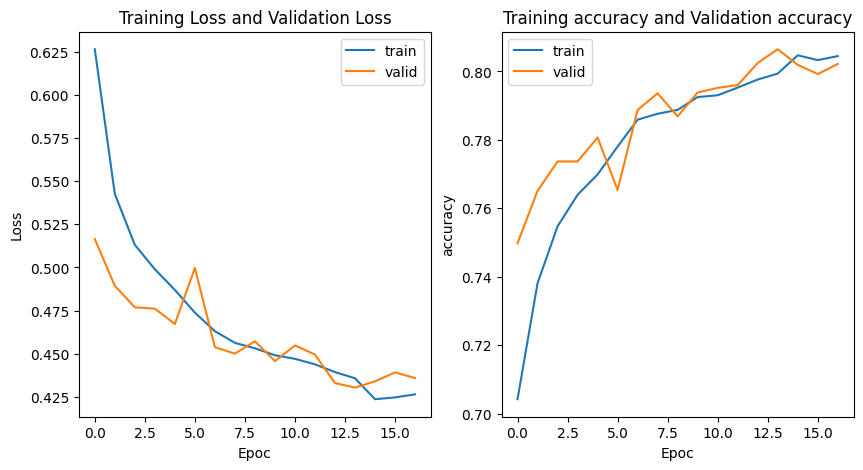

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      2068
           1       0.45      0.77      0.57       601

    accuracy                           0.73      2669
   macro avg       0.68      0.75      0.69      2669
weighted avg       0.81      0.73      0.75      2669



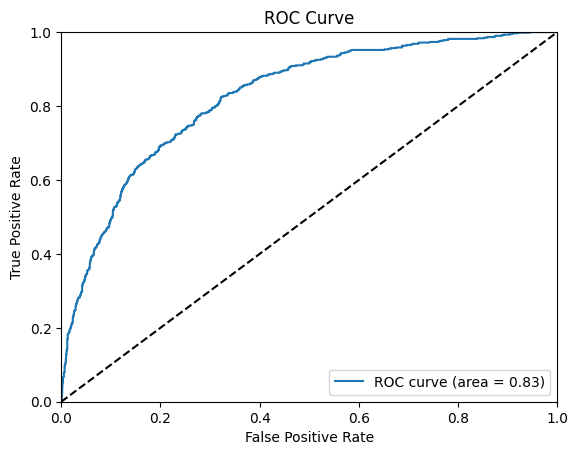

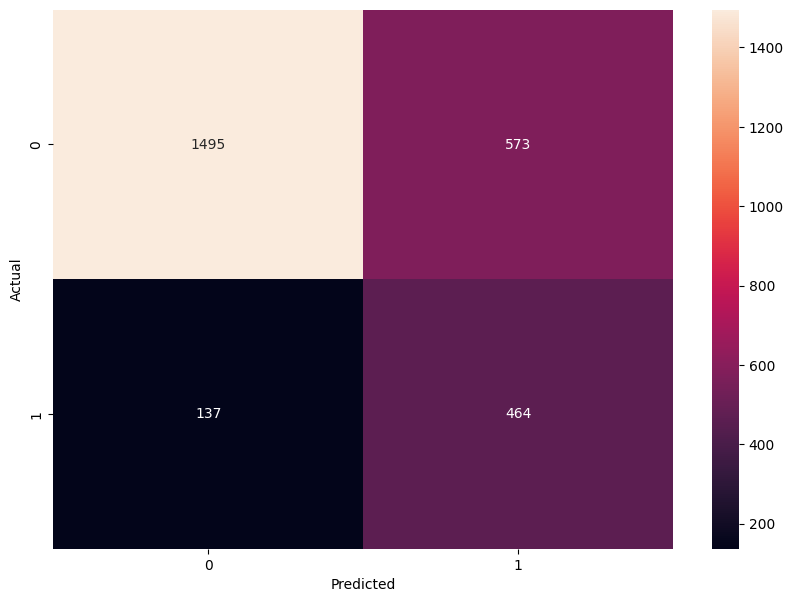

233/233 [==============================] - 28s 122ms/step


In [ ]:
model.load_weights(ver_fl_name)
PROD_THRESHOLD = 0.5
y_test = []
for i, (_, labels) in enumerate(test_ds):
    y_test.append(labels.numpy())
y_test = np.concatenate(y_test)

y_test_probs = model.predict(test_ds)
y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)
histroy = pickle.load(open(his_fl_name,'rb'))
plotLossAcc(histroy)
print(classification_report(y_test, y_test_pred))
plot_roc_curve(y_test, y_test_probs)
plot_confusion_matrix(y_test, y_test_pred)
df1 = evaluate_metrics(y_test, y_test_pred,y_test_probs,col_labl='test')


y_val = []
for i, (_, labels) in enumerate(val_ds):
    y_val.append(labels.numpy())
y_val = np.concatenate(y_val)

y_val_probs = model.predict(val_ds)
y_val_pred = (y_val_probs >= PROD_THRESHOLD).astype(int)
df2 = evaluate_metrics(y_val, y_val_pred,y_val_probs,col_labl='val')

df = pd.concat([df1,df2],axis=1)

mdl_dtls = f'itr = {itr}, name = {name}'
df['model_details'] = [mdl_dtls]
df['name'] = [name]
writeResults(df)

* resnet model is one of the best models so far
* the training and validation loss are near to each other, so it there is less overfitting

### Trying EfficientNet


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
def make_dataset_efficientnet(x_file_list, y_list, img_width=224, img_height=224, batch_size = 16, do_resize=True, no_channels = 1):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(no_channels))
      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))
      image = preprocess_input(image)
      return image, label

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
itr = 38
max_epoch = 20
lr = 0.0001
drop_out = 0.5
batch_size = 16
resize_width = 224
resize_height = 224
input_shape = (resize_width,resize_height,3)


train_ds = make_dataset_efficientnet(x_train_bal_os, y_train_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
val_ds = make_dataset_efficientnet(x_val_bal_os,y_val_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
test_ds = make_dataset_efficientnet(x_test,y_test,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)

name = 'EfficientNetB0_ovr_sampl_prc_input'
ver_fl_name = name +'_'+str(itr)+'.h5'
his_fl_name = name  +'_'+str(itr)+'_history.pkl'
fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
ver_fl_name = os.path.join(fldr_name,ver_fl_name)
his_fl_name = os.path.join(fldr_name,his_fl_name)

In [ ]:
base_model = EfficientNetB0(include_top=False,
                   weights='imagenet',pooling='max',
                   input_shape=input_shape)
base_model.trainable = False


model = Sequential([
    base_model
])

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(BatchNormalization())
model.add(Dropout(drop_out))

model.add(Dense(activation = 'relu', units = 64))
model.add(BatchNormalization())
model.add(Dropout(drop_out/2))

model.add(Dense(activation = 'sigmoid', units = 1))

print(model.summary())

16705208/16705208 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                         

In [ ]:
# model.load_weights(ver_fl_name)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                               decay_steps=10000,
                                                               decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ver_fl_name,
                                                      save_best_only=True,
                                                      monitor='val_accuracy',
                                                      save_weights_only= True,
                                                      mode='max',
                                                      verbose=0)
model_erly_stp = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=3,
                                                verbose=0)
histroy = model.fit(train_ds,
                    epochs=max_epoch,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint,model_erly_stp])

pickle.dump(histroy, open(his_fl_name,'wb'))

Epoch 1/20
2093/2093 [==============================] - 267s 118ms/step - loss: 0.6620 - accuracy: 0.6750 - val_loss: 0.5339 - val_accuracy: 0.7460
Epoch 2/20
2093/2093 [==============================] - 239s 114ms/step - loss: 0.5827 - accuracy: 0.7159 - val_loss: 0.5973 - val_accuracy: 0.7218
Epoch 3/20
2093/2093 [==============================] - 206s 98ms/step - loss: 0.5552 - accuracy: 0.7293 - val_loss: 0.5040 - val_accuracy: 0.7509
Epoch 4/20
2093/2093 [==============================] - 202s 96ms/step - loss: 0.5408 - accuracy: 0.7363 - val_loss: 0.4963 - val_accuracy: 0.7622
Epoch 5/20
2093/2093 [==============================] - 198s 94ms/step - loss: 0.5282 - accuracy: 0.7432 - val_loss: 0.4973 - val_accuracy: 0.7616
Epoch 6/20
2093/2093 [==============================] - 195s 93ms/step - loss: 0.5204 - accuracy: 0.7527 - val_loss: 0.4884 - val_accuracy: 0.7670
Epoch 7/20
2093/2093 [==============================] - 196s 93ms/step - loss: 0.5113 - accuracy: 0.7552 - val_loss:

167/167 [==============================] - 17s 90ms/step


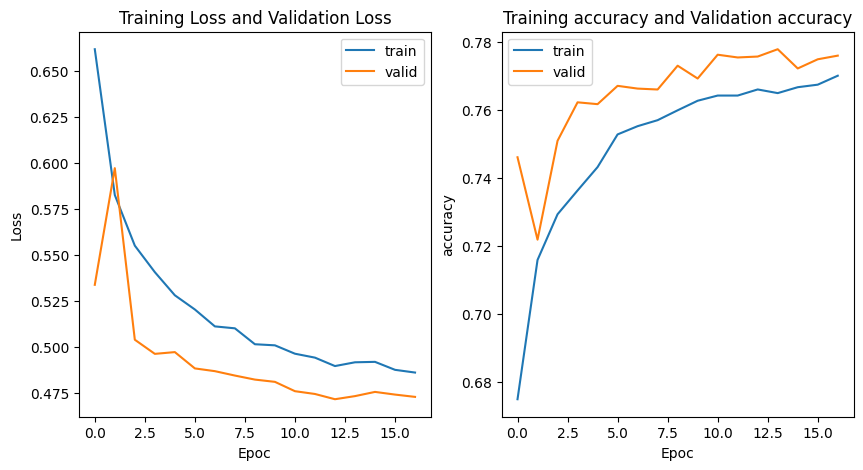

              precision    recall  f1-score   support

           0       0.92      0.73      0.81      2068
           1       0.45      0.78      0.57       601

    accuracy                           0.74      2669
   macro avg       0.69      0.75      0.69      2669
weighted avg       0.81      0.74      0.76      2669



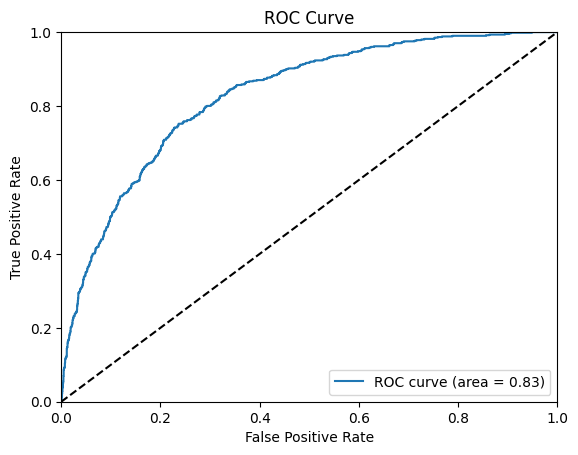

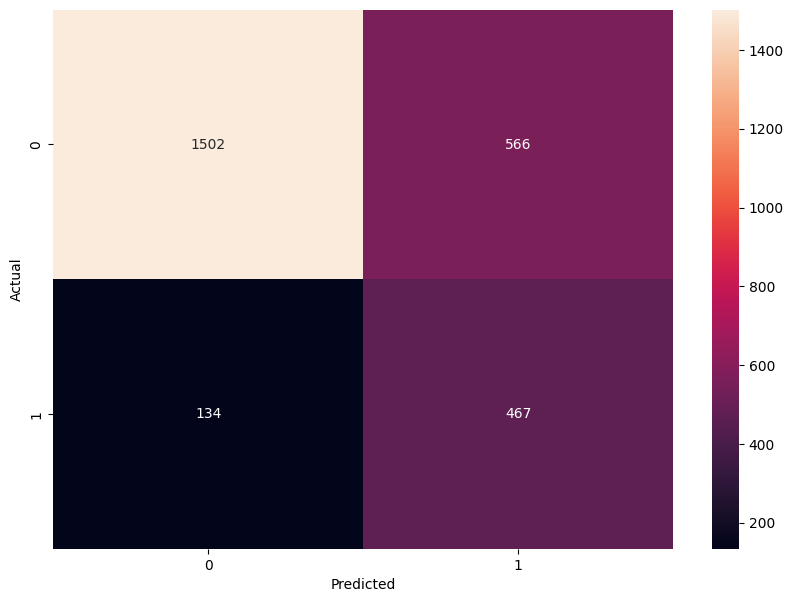

233/233 [==============================] - 32s 136ms/step


In [ ]:
model.load_weights(ver_fl_name)
PROD_THRESHOLD = 0.5
y_test = []
for i, (_, labels) in enumerate(test_ds):
    y_test.append(labels.numpy())
y_test = np.concatenate(y_test)

y_test_probs = model.predict(test_ds)
y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)
histroy = pickle.load(open(his_fl_name,'rb'))
plotLossAcc(histroy)
print(classification_report(y_test, y_test_pred))
plot_roc_curve(y_test, y_test_probs)
plot_confusion_matrix(y_test, y_test_pred)
df1 = evaluate_metrics(y_test, y_test_pred,y_test_probs,col_labl='test')


y_val = []
for i, (_, labels) in enumerate(val_ds):
    y_val.append(labels.numpy())
y_val = np.concatenate(y_val)

y_val_probs = model.predict(val_ds)
y_val_pred = (y_val_probs >= PROD_THRESHOLD).astype(int)
df2 = evaluate_metrics(y_val, y_val_pred,y_val_probs,col_labl='val')

df = pd.concat([df1,df2],axis=1)

mdl_dtls = f'itr = {itr}, name = {name}'
df['model_details'] = [mdl_dtls]
df['name'] = [name]
writeResults(df)

* The efficient net model is also one of the best model
* there is less over fitting as seen by closeness of training and validation loss curves

### Trying MOBILE NET V2 WITH AVG POOLING

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
IMG_HEIGHT=224
IMG_WIDTH=224
BATCH_SIZE=16
def make_dataset_mobileNetv2(x_file_list, y_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, batch_size = BATCH_SIZE, do_resize=True, no_channels = 1):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(no_channels))
      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))
      image = preprocess_input(image)
      return image, label

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
from tensorflow.keras.applications import MobileNetV2
itr = 39
max_epoch = 20
lr = 0.0001
drop_out = 0.5
batch_size = 16
resize_width = 224
resize_height = 224
input_shape = (resize_width,resize_height,3)


train_ds = make_dataset_mobileNetv2(x_train_bal_os, y_train_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
val_ds = make_dataset_mobileNetv2(x_val_bal_os,y_val_bal_os,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
test_ds = make_dataset_mobileNetv2(x_test,y_test,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)

name = 'MobileNetV2_ovr_sampl_using_process_input_WITH_AVG_POOLING'
ver_fl_name = name +'_'+str(itr)+'.h5'
his_fl_name = name  +'_'+str(itr)+'_history.pkl'
fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
ver_fl_name = os.path.join(fldr_name,ver_fl_name)
his_fl_name = os.path.join(fldr_name,his_fl_name)

In [ ]:
base_model = MobileNetV2(include_top=False,
                   weights='imagenet',
                         pooling='avg',
                   input_shape=input_shape)
base_model.trainable = False


model = Sequential([
    base_model
])

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(BatchNormalization())
model.add(Dropout(drop_out))

model.add(Dense(activation = 'relu', units = 64))
model.add(BatchNormalization())
model.add(Dropout(drop_out/2))

model.add(Dense(activation = 'sigmoid', units = 1))

print(model.summary())

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                         

In [ ]:

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                               decay_steps=10000,
                                                               decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ver_fl_name,
                                                      save_best_only=True,
                                                      monitor='val_accuracy',
                                                      save_weights_only= True,
                                                      mode='max',
                                                      verbose=0)
model_erly_stp = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=3,
                                                verbose=0)
histroy = model.fit(train_ds,
                    epochs=max_epoch,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint,model_erly_stp])

pickle.dump(histroy, open(his_fl_name,'wb'))

Epoch 1/20
2093/2093 [==============================] - 220s 102ms/step - loss: 0.6228 - accuracy: 0.7017 - val_loss: 0.5039 - val_accuracy: 0.7557
Epoch 2/20
2093/2093 [==============================] - 191s 91ms/step - loss: 0.5517 - accuracy: 0.7332 - val_loss: 0.4906 - val_accuracy: 0.7640
Epoch 3/20
2093/2093 [==============================] - 194s 93ms/step - loss: 0.5286 - accuracy: 0.7466 - val_loss: 0.4845 - val_accuracy: 0.7721
Epoch 4/20
2093/2093 [==============================] - 194s 93ms/step - loss: 0.5108 - accuracy: 0.7561 - val_loss: 0.4772 - val_accuracy: 0.7721
Epoch 5/20
2093/2093 [==============================] - 192s 92ms/step - loss: 0.4997 - accuracy: 0.7625 - val_loss: 0.4729 - val_accuracy: 0.7788
Epoch 6/20
2093/2093 [==============================] - 195s 93ms/step - loss: 0.4913 - accuracy: 0.7667 - val_loss: 0.4673 - val_accuracy: 0.7853
Epoch 7/20
2093/2093 [==============================] - 195s 93ms/step - loss: 0.4855 - accuracy: 0.7719 - val_loss: 

167/167 [==============================] - 15s 86ms/step


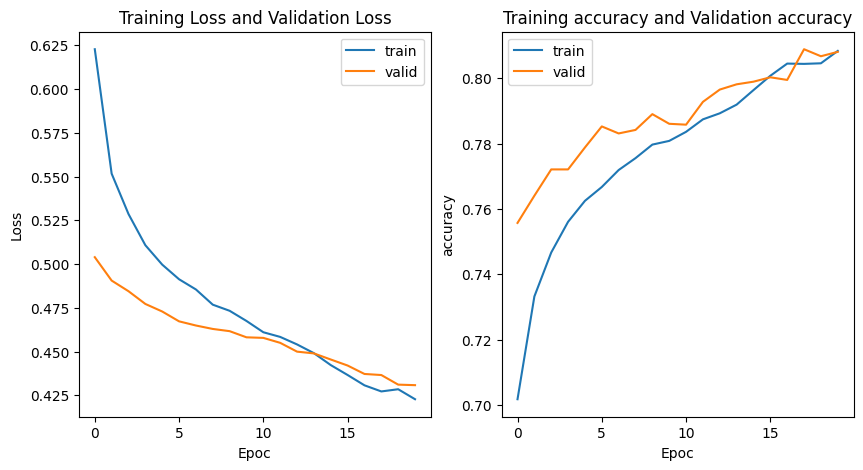

              precision    recall  f1-score   support

           0       0.91      0.76      0.83      2068
           1       0.47      0.73      0.57       601

    accuracy                           0.75      2669
   macro avg       0.69      0.74      0.70      2669
weighted avg       0.81      0.75      0.77      2669



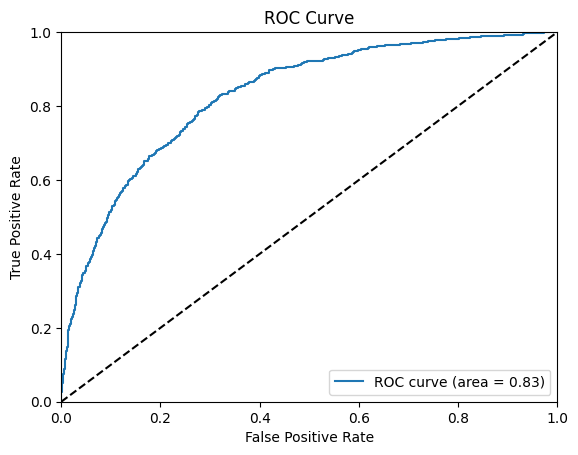

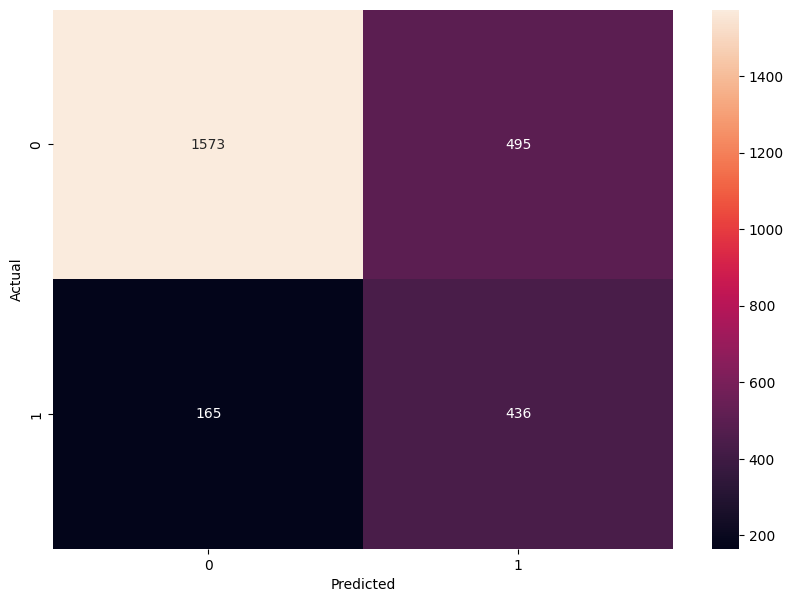

233/233 [==============================] - 21s 90ms/step


In [ ]:
model.load_weights(ver_fl_name)
PROD_THRESHOLD = 0.5
y_test = []
for i, (_, labels) in enumerate(test_ds):
    y_test.append(labels.numpy())
y_test = np.concatenate(y_test)

y_test_probs = model.predict(test_ds)
y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)
histroy = pickle.load(open(his_fl_name,'rb'))
plotLossAcc(histroy)
print(classification_report(y_test, y_test_pred))
plot_roc_curve(y_test, y_test_probs)
plot_confusion_matrix(y_test, y_test_pred)
df1 = evaluate_metrics(y_test, y_test_pred,y_test_probs,col_labl='test')


y_val = []
for i, (_, labels) in enumerate(val_ds):
    y_val.append(labels.numpy())
y_val = np.concatenate(y_val)

y_val_probs = model.predict(val_ds)
y_val_pred = (y_val_probs >= PROD_THRESHOLD).astype(int)
df2 = evaluate_metrics(y_val, y_val_pred,y_val_probs,col_labl='val')

df = pd.concat([df1,df2],axis=1)

mdl_dtls = f'itr = {itr}, name = {name}'
df['model_details'] = [mdl_dtls]
df['name'] = [name]
writeResults(df)

* mobile net with avg pooling works well and the results shows its one of the best model
* the overfitting is also less, as seen from closeness of training and validation error

### Summarizing results from transfer learning models

In [ ]:
FINAL_RESULTS_CSV = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/final_result_ver1.csv'
final_results = pd.read_csv(FINAL_RESULTS_CSV)
print(final_results.sort_values(by=['test_test_roc_auc','test_f1'],ascending=False).iloc[0:5,:])

    test_accuracy  test_precision  test_recall   test_f1  test_test_roc_auc  val_accuracy  val_precision  val_recall    val_f1  val_test_roc_auc                                      model_details                                               name
28       0.737355        0.452652     0.795341  0.576946           0.830293      0.785273       0.768234    0.835159  0.800300          0.861115  itr = 36, name = InceptionV3_ovr_sampl_using_p...          InceptionV3_ovr_sampl_using_process_input
31       0.752716        0.468314     0.725458  0.569191           0.829196      0.808922       0.800898    0.837246  0.818669          0.878573  itr = 39, name = MobileNetV2_ovr_sampl_using_p...  MobileNetV2_ovr_sampl_using_process_input_WITH...
30       0.737729        0.452081     0.777038  0.571603           0.827911      0.777748       0.763795    0.823161  0.792368          0.854123  itr = 38, name = EfficientNetB0_ovr_sampl_prc_...                 EfficientNetB0_ovr_sampl_prc_input
29       0.7

In [ ]:
print(f'mean test recall of all models {final_results.test_recall.median()} and mean test f1 score {final_results.test_f1.median()}')

mean test recall of all models 0.584858569 and mean test f1 score 0.5463131489999999


* From above it can be seen that transfer learning models are overall better.
* The best model is Inception V3 model, closely followed by mobilenet v2 model with avg poollng.
* few intial models we tried did not have pooling, so it also shows importance of pooling step in CNN models.
* there is less overfitting in efficient net and mobile net models as can be seen from closeness of trainning, validation and test scores



##  Step 3: Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or mask over the area of interest. [ 8 points ]

There are two ways to appoach RCNN
1. Region proposal and then CNN to classify the region
2. RCNN - using UNET masking

#### Region proposal and then CNN to classify the region

This will be done the following steps
1. will use Selective search process to generate most probable image regions.
2. then calculate IOU w.r.t the ground truth bounding boxes. Select only those proposed bounding boxes which have IOU >0.3 as positive and rest as negative.
3. will then crop the image regions and resize them to 224 * 224 size and store them as positive or negative samples.
4. since this will generate more number of negative samples then positive samples we will store only 30 negative sample and all positive samples.
5. from the samples will then build a balanced dataset and train a CNN to binary classify the regions
6. while predicting will use the same process to first generate regions of interest and then classify them into positive and negative.



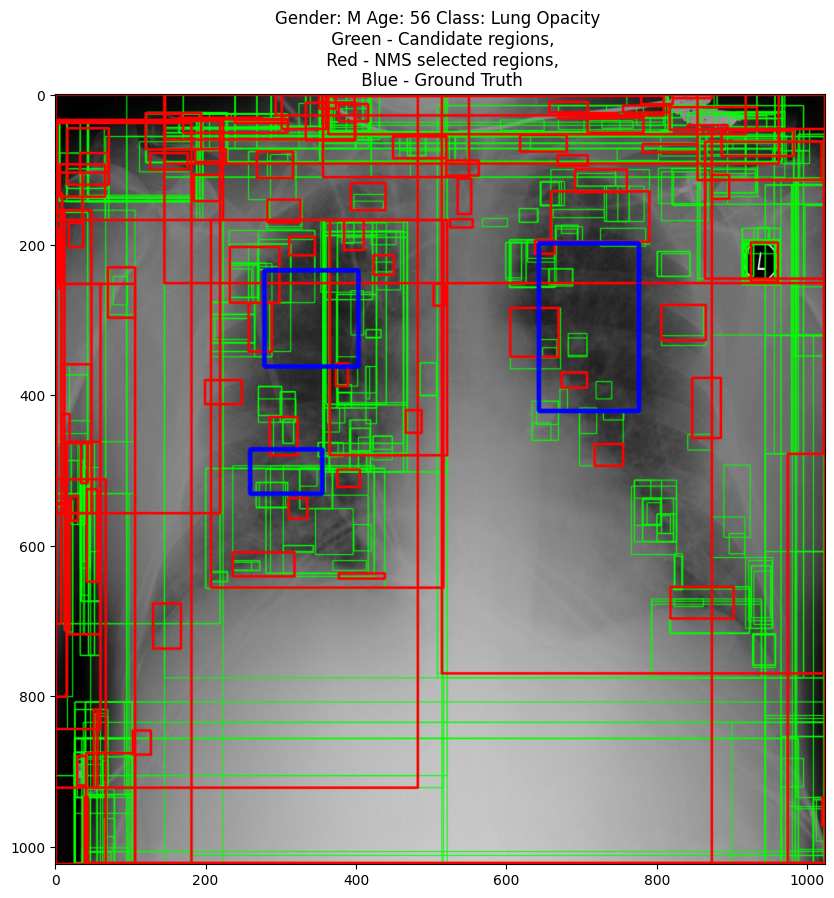

In [ ]:
# generating candidate regions and displaing them for a randomly selected image
rndm_sample = df_train_data.loc[df_train_data.Target==1,:].sample(1)

cv2.setUseOptimized(True);
ss_object = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

input_image = cv2.imread(rndm_sample['jpg_file_path'].values[0])
ss_object.setBaseImage(input_image)
ss_object.switchToSelectiveSearchFast()  #this method of createSelectiveSearchSegmentation()
rects = ss_object.process()    # The output of the process is a set of a potential ROI’s, depending on the size of the base image
new_input_image = input_image.copy() # create copy of the base image

fig,ax = plt.subplots(1,1,figsize=(10,10))
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(new_input_image, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)


boxes = [[x, y, x+w, y+h] for (x, y, w, h) in rects]

# applying Non Maximum Suppression to reduce the number of candidate images.

nms_threshold = 0.5
nms_boxes_indx = cv2.dnn.NMSBoxes(boxes, [1]*len(boxes), score_threshold=0, nms_threshold=nms_threshold)
nms_boxes = np.asarray(boxes)[nms_boxes_indx]
for i, rect in (enumerate(nms_boxes)):
   cv2.rectangle(new_input_image, (rect[0], rect[1]), (rect[2], rect[3]), (255, 0, 0), 2, cv2.LINE_AA)



boundBoxes = df_train_data.loc[df_train_data.patientId == rndm_sample['patientId'].values[0],['x','y','width','height']]
for _,box in boundBoxes.iterrows():
  x1 = int(box['x'])
  y1 = int(box['y'])
  x2 = x1 + int(box['width'])
  y2 = y1 + int(box['height'])
  cv2.rectangle(new_input_image,(x1,y1),(x2,y2),(0,0,255), 3, cv2.LINE_AA)

ax.imshow(new_input_image, cmap = plt.cm.bone)

ax.set_title(f"Gender: {rndm_sample['sex'].values[0]} Age: {rndm_sample['age'].values[0]} Class: {rndm_sample['class'].values[0]} \n Green - Candidate regions,\n Red - NMS selected regions,\n Blue - Ground Truth")
plt.show()

above image show various regions generated by selective search. it can be seen that though not all regions are within the ground truth, many regions are partially within ground truth.

In [ ]:
# this function calculate IOU when provided with bounding box dimensions.
def calculate_iou(bb_1, bb_2):
    x_left = max(bb_1['x1'], bb_2['x1'])
    y_top = max(bb_1['y1'], bb_2['y1'])
    x_right = min(bb_1['x2'], bb_2['x2'])
    y_bottom = min(bb_1['y2'], bb_2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection = (x_right - x_left) * (y_bottom - y_top)

    bb_1_area = (bb_1['x2'] - bb_1['x1']) * (bb_1['y2'] - bb_1['y1'])
    bb_2_area = (bb_2['x2'] - bb_2['x1']) * (bb_2['y2'] - bb_2['y1'])

    iou_value = intersection / float(bb_1_area + bb_2_area - intersection)
    return iou_value

In [ ]:
# This method will generate positive and negative images regions based on regions proposed by the selective search algorithm
mask_dir_pos = r'/content/SEGMENT_PROPOSAL_POS'
if os.path.exists(mask_dir_pos)==False:
  os.mkdir(mask_dir_pos)

proposal_df_dir = r'/content/proposal_df_dir'
if os.path.exists(proposal_df_dir)==False:
  os.mkdir(proposal_df_dir)

mask_dir_neg = r'/content/SEGMENT_PROPOSAL_NEG'
if os.path.exists(mask_dir_neg)==False:
  os.mkdir(mask_dir_neg)



def generateSampleBB(patentId = None, threshold = 0.3, imgWidth = 224, imgHeight = 224,
                     maskFldrPos = mask_dir_pos, maskFldrNeg = mask_dir_neg,
                     proposal_df_dir = proposal_df_dir, maxNegImgeCnt = 30):
  dfPrpsdRegion = pd.DataFrame()
  negCnt = 0
  posCnt = 0
  jpg_file_path = df_train_data.loc[df_train_data.patientId == patentId,'jpg_file_path'].values[0]
  input_image = cv2.imread(jpg_file_path)
  cv2.setUseOptimized(True);
  ss_object = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

  input_image = cv2.imread(rndm_sample['jpg_file_path'].values[0])
  ss_object.setBaseImage(input_image)
  ss_object.switchToSelectiveSearchFast()
  ss_results = ss_object.process()

  boxes = [{'x1':x,'y1':y,'x2':x+w,'y2':y+h} for (x, y, w, h) in rects]

  boundBoxes = df_train_data.loc[df_train_data.patientId == patentId,['x','y','width','height']]
  truth_bound_boxes = []
  for _,box in boundBoxes.iterrows():
    x1 = int(box['x'])
    y1 = int(box['y'])
    x2 = x1 + int(box['width'])
    y2 = y1 + int(box['height'])
    truth_bound_boxes.append({'x1':x1,'x2':x2,'y1':y1,'y2':y2})
  cnt = 0
  for bb_tr in truth_bound_boxes:
    for bb_cand in boxes:
      cnt += 1
      if calculate_iou(bb_tr, bb_cand) >= threshold:
        region_img = input_image[bb_cand['y1']:bb_cand['y2'],bb_cand['x1']:bb_cand['x2']]
        resized_image = cv2.resize(region_img, (imgWidth,imgHeight), interpolation = cv2.INTER_AREA)
        file_path = os.path.join(mask_dir_pos,patentId+'_pos_'+str(cnt)+'.jpg')
        cv2.imwrite(file_path, resized_image)

        dfPrpsdRegion = pd.concat([dfPrpsdRegion,
                        pd.DataFrame({'patentId':patentId,
                                      'file_path':file_path,
                                      'y1':bb_cand['y1'],
                                      'y2':bb_cand['y2'],
                                      'x1':bb_cand['x1'],
                                      'x2':bb_cand['x2'],
                                      'Target':[1]})])
        posCnt += 1
      else:
        if negCnt < maxNegImgeCnt:
          region_img = input_image[bb_cand['y1']:bb_cand['y2'],bb_cand['x1']:bb_cand['x2']]
          resized_image = cv2.resize(region_img, (imgWidth,imgHeight), interpolation = cv2.INTER_AREA)
          file_path = os.path.join(maskFldrNeg,patentId+'_neg_'+str(cnt)+'.jpg')
          cv2.imwrite(file_path, resized_image)

          dfPrpsdRegion = pd.concat([dfPrpsdRegion,
                          pd.DataFrame({'patentId':patentId,
                                        'file_path':file_path,
                                        'y1':bb_cand['y1'],
                                        'y2':bb_cand['y2'],
                                        'x1':bb_cand['x1'],
                                        'x2':bb_cand['x2'],
                                        'Target':[0]})])
          negCnt +=1
        else:
          continue
      if posCnt >=30 and negCnt >=30:
        break
  dfPrpsdRegion.to_csv(os.path.join(proposal_df_dir,patentId+'.csv'),index=False)

In [ ]:
patientIds = df_train_data.loc[df_train_data.Target==1,'patientId'].drop_duplicates()
# _ = patientIds.parallel_apply(lambda x : generateSampleBB(x))
results = Parallel(n_jobs=-1)(delayed(generateSampleBB)(x) for x in tqdm(patientIds))


  7%|▋         | 404/6012 [1:29:41<20:40:48, 13.28s/it]

In google collab we gets CPUs which have only 2 cores, so if we run this code here, it takes lot of time.

i have run the above code in my local machine as it takes lot of time run and generate region proposals. i have created zip file containing the positive image regions, negative image regions and a list of data frames which has record of all the image segments. i will now read them in google cola and process the reminder here.


In [ ]:
proposal_df_dir_zip = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/proposal_df_dir.zip'
with zipfile.ZipFile(proposal_df_dir_zip,"r") as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
SEGMENT_PROPOSAL_NEG_zip = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/SEGMENT_PROPOSAL_NEG.zip'
with zipfile.ZipFile(SEGMENT_PROPOSAL_NEG_zip,"r") as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
SEGMENT_PROPOSAL_POS_zip = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/SEGMENT_PROPOSAL_POS.zip'
with zipfile.ZipFile(SEGMENT_PROPOSAL_POS_zip,"r") as zip_ref:
    zip_ref.extractall('/content/')

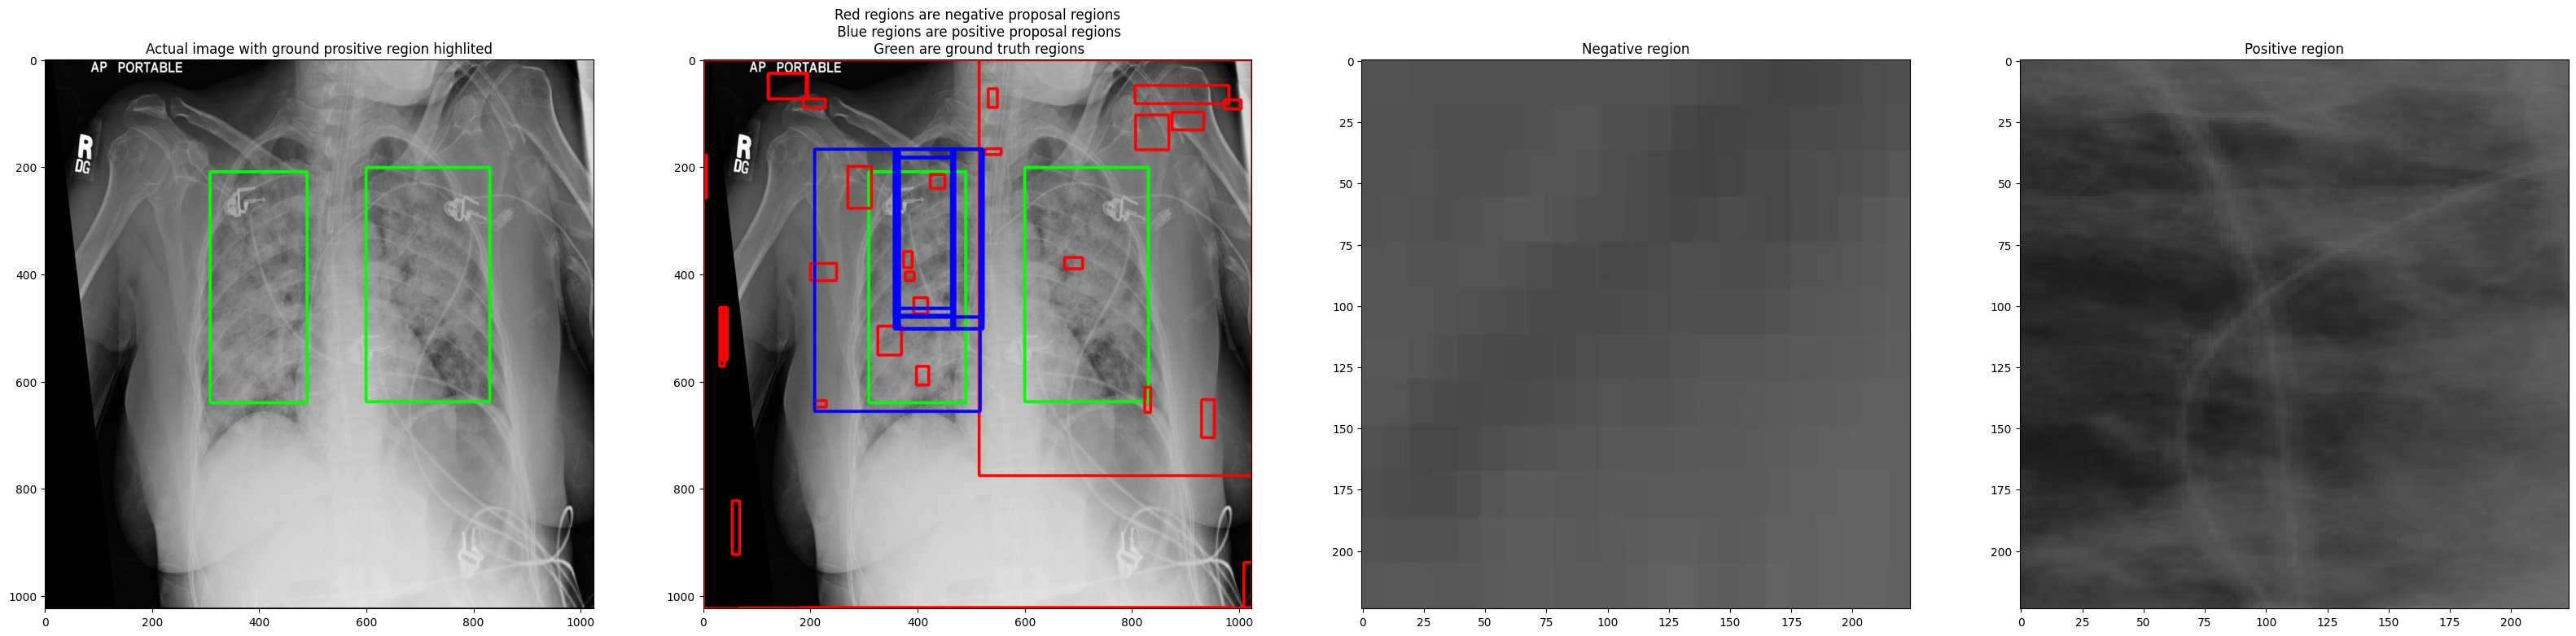

In [ ]:
# reading the images and displaying the proposals
proposal_df_dir = r'/content/proposal_df_dir'
fl = random.choice(os.listdir(proposal_df_dir))
df = pd.read_csv(os.path.join(proposal_df_dir,fl))

temp = df_train_data.loc[df_train_data.patientId==df.patentId.values[0],:]

fig,ax = plt.subplots(1,4,figsize=(40,10))
img = cv2.imread(temp.jpg_file_path.values[0])

for _,box in temp.iterrows():
  x1 = int(box['x'])
  y1 = int(box['y'])
  x2 = x1 + int(box['width'])
  y2 = y1 + int(box['height'])
  cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0), 3, cv2.LINE_AA)

ax[0].imshow(img, cmap = plt.cm.bone)
ax[0].set_title(f"Actual image with ground prositive region highlited")


img1 = img.copy()
for _,row in df.iterrows():
  if row['Target']==0:
    cv2.rectangle(img1,(row['x1'],row['y1']),(row['x2'],row['y2']),(255,0,0), 3, cv2.LINE_AA)
  else:
    cv2.rectangle(img1,(row['x1'],row['y1']),(row['x2'],row['y2']),(0,0,255), 3, cv2.LINE_AA)

ax[1].imshow(img1, cmap = plt.cm.bone)
ax[1].set_title(f'Red regions are negative proposal regions\n Blue regions are positive proposal regions\n Green are ground truth regions')

ax[2].imshow(cv2.imread(df.loc[df.Target==0,'file_path'].sample(1).values[0]))
ax[2].set_title(f'Negative region')

if df.loc[df.Target==1,'file_path'].shape[0]>0:
  ax[3].imshow(cv2.imread(df.loc[df.Target==1,'file_path'].sample(1).values[0]))
  ax[3].set_title(f'Positive region')
else:
  ax[3].set_title(f'No Positive proposals')

plt.show()

In [ ]:
# reading all regions
region_proposal_df = pd.DataFrame()
proposal_df_dir = r'/content/proposal_df_dir'
for fl in os.listdir(proposal_df_dir):
  region_proposal_df = pd.concat([region_proposal_df,
                                  pd.read_csv(os.path.join(proposal_df_dir,fl))])

In [ ]:
# sampling positive and negative regions to train CNN
pos_regions = region_proposal_df.loc[region_proposal_df.Target==1,['file_path','Target','patentId']]
neg_regions = region_proposal_df.loc[region_proposal_df.Target==0,['file_path','Target','patentId']].sample(pos_regions.shape[0])

all_regions = pd.concat([pos_regions,neg_regions]).sample(frac = 1)
print(all_regions.Target.value_counts())

0    13106
1    13106
Name: Target, dtype: int64


we generated a balanced dataset as seen above

In [ ]:
# splting between train, test and validation
X = all_regions['file_path']
y = all_regions['Target'].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED_VAL)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, stratify= y_test, random_state= SEED_VAL)

**Mobile net was one of the best model so will train that model on this data set**

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
IMG_HEIGHT=224
IMG_WIDTH=224
BATCH_SIZE=16
def make_dataset_mobileNetv2(x_file_list, y_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, batch_size = BATCH_SIZE, do_resize=True, no_channels = 1):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(no_channels))
      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))
      image = preprocess_input(image)
      return image, label

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset

In [ ]:
from tensorflow.keras.applications import MobileNetV2
itr = 41
max_epoch = 20
lr = 0.0001
drop_out = 0.5
batch_size = 16
resize_width = 224
resize_height = 224
input_shape = (resize_width,resize_height,3)


train_ds = make_dataset_mobileNetv2(x_train, y_train,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
val_ds = make_dataset_mobileNetv2(x_val,y_val,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
test_ds = make_dataset_mobileNetv2(x_test,y_test,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)

name = 'MobileNetV2_rcnn_without_img_proposal'
ver_fl_name = name +'_'+str(itr)+'.h5'
his_fl_name = name  +'_'+str(itr)+'_history.pkl'
fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
ver_fl_name = os.path.join(fldr_name,ver_fl_name)
his_fl_name = os.path.join(fldr_name,his_fl_name)

In [ ]:
base_model = MobileNetV2(include_top=False,
                   weights='imagenet',
                         pooling='avg',
                   input_shape=input_shape)
base_model.trainable = False


model = Sequential([
    base_model
])

model.add(Flatten())

model.add(Dense(activation = 'relu', units = 128))
model.add(BatchNormalization())
model.add(Dropout(drop_out))

model.add(Dense(activation = 'relu', units = 64))
model.add(BatchNormalization())
model.add(Dropout(drop_out/2))

model.add(Dense(activation = 'sigmoid', units = 1))

print(model.summary())

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                           

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr,
                                                               decay_steps=10000,
                                                               decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(ver_fl_name,
                                                      save_best_only=True,
                                                      monitor='val_accuracy',
                                                      save_weights_only= True,
                                                      mode='max',
                                                      verbose=0)
model_erly_stp = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=3,
                                                verbose=0)
histroy = model.fit(train_ds,
                    epochs=max_epoch,
                    validation_data=val_ds,
                    callbacks=[model_checkpoint,model_erly_stp])

pickle.dump(histroy, open(his_fl_name,'wb'))

Epoch 1/20
1311/1311 [==============================] - 65s 36ms/step - loss: 0.1028 - accuracy: 0.9649 - val_loss: 0.0431 - val_accuracy: 0.9832
Epoch 2/20
1311/1311 [==============================] - 39s 30ms/step - loss: 0.0633 - accuracy: 0.9776 - val_loss: 0.0393 - val_accuracy: 0.9836
Epoch 3/20
1311/1311 [==============================] - 43s 33ms/step - loss: 0.0598 - accuracy: 0.9780 - val_loss: 0.0379 - val_accuracy: 0.9836
Epoch 4/20
1311/1311 [==============================] - 39s 29ms/step - loss: 0.0566 - accuracy: 0.9785 - val_loss: 0.0308 - val_accuracy: 0.9836
Epoch 5/20
1311/1311 [==============================] - 39s 29ms/step - loss: 0.0548 - accuracy: 0.9773 - val_loss: 0.0313 - val_accuracy: 0.9836


164/164 [==============================] - 3s 20ms/step


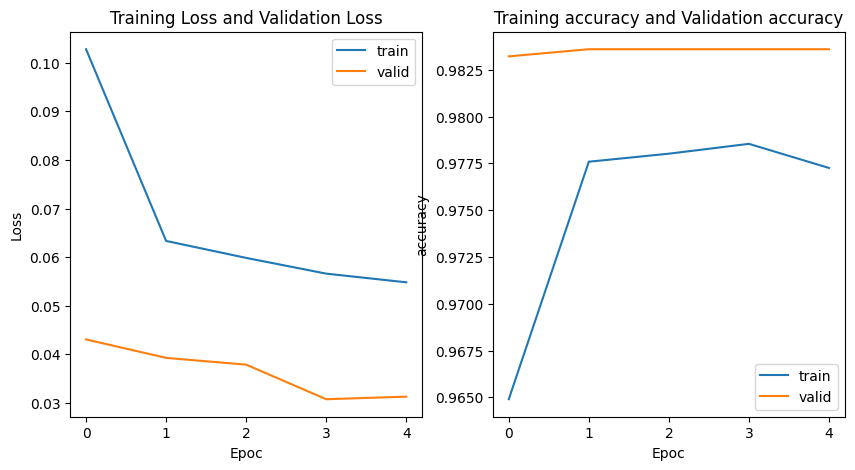

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      1311
           1       0.98      1.00      0.99      1311

    accuracy                           0.99      2622
   macro avg       0.99      0.99      0.99      2622
weighted avg       0.99      0.99      0.99      2622



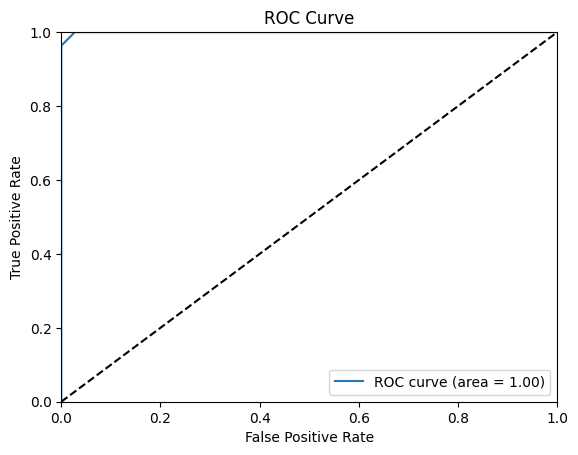

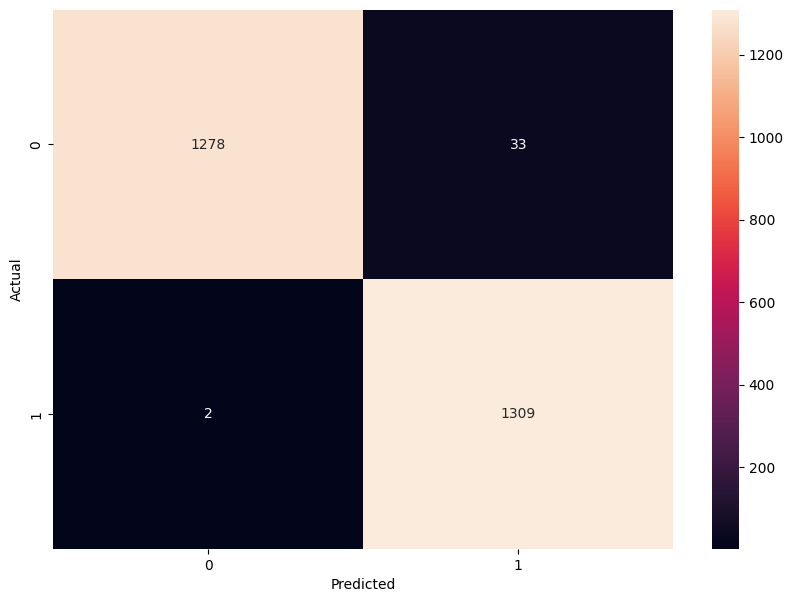

164/164 [==============================] - 3s 21ms/step
   test_accuracy  test_precision  test_recall   test_f1  test_test_roc_auc  val_accuracy  val_precision  val_recall    val_f1  val_test_roc_auc                                      model_details                                   name
0       0.986651         0.97541     0.998474  0.986807           0.999501      0.983594       0.968912    0.999237  0.983841          0.999213  itr = 41, name = MobileNetV2_rcnn_without_img_...  MobileNetV2_rcnn_without_img_proposal


In [ ]:
model.load_weights(ver_fl_name)
PROD_THRESHOLD = 0.5
y_test = []
for i, (_, labels) in enumerate(test_ds):
    y_test.append(labels.numpy())
y_test = np.concatenate(y_test)

y_test_probs = model.predict(test_ds)
y_test_pred = (y_test_probs >= PROD_THRESHOLD).astype(int)
histroy = pickle.load(open(his_fl_name,'rb'))
plotLossAcc(histroy)
print(classification_report(y_test, y_test_pred))
plot_roc_curve(y_test, y_test_probs)
plot_confusion_matrix(y_test, y_test_pred)
df1 = evaluate_metrics(y_test, y_test_pred,y_test_probs,col_labl='test')


y_val = []
for i, (_, labels) in enumerate(val_ds):
    y_val.append(labels.numpy())
y_val = np.concatenate(y_val)

y_val_probs = model.predict(val_ds)
y_val_pred = (y_val_probs >= PROD_THRESHOLD).astype(int)
df2 = evaluate_metrics(y_val, y_val_pred,y_val_probs,col_labl='val')

df = pd.concat([df1,df2],axis=1)

mdl_dtls = f'itr = {itr}, name = {name}'
df['model_details'] = [mdl_dtls]
df['name'] = [name]
print(df)

**From the above it can be seen that model is very good model, we get ROC AUC and F1 score, which is consistent within train, validation and test. So the model has generalized well.**

##### Testing the model on Test data
**Will test this model on random sample of test data**

**Process of prediction is as follows**



1.   Predict if the image is pneumonia postive using the best model developed in step 2 of this milestone above.
2.   if positive use the above RCCN model to predict the region with the higest porobability



In [16]:
# building the CNN model as the base binary classifier. and loading the best training weights
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
itr = 36
batch_size = 16
resize_width = 224
resize_height = 224
drop_out = 0.5
input_shape = (resize_width,resize_height,3)


def make_dataset_inception_v3(x_file_list, y_list, img_width=resize_width, img_height=resize_height, batch_size = batch_size, do_resize=True, no_channels = 1):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(no_channels))
      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))
      image = preprocess_input(image)
      return image, label

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset



name = 'InceptionV3_ovr_sampl_using_process_input'
ver_fl_name = name +'_'+str(itr)+'.h5'
fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
ver_fl_name = os.path.join(fldr_name,ver_fl_name)

tf.keras.backend.clear_session()
gc.collect()
base_model_bin_cls = InceptionV3(include_top=False,
                        weights='imagenet',
                        pooling='max',
                        input_shape=input_shape)
base_model_bin_cls.trainable = False


model_bin_cls = Sequential([
    base_model_bin_cls
])

model_bin_cls.add(Flatten())

model_bin_cls.add(Dense(activation = 'relu', units = 128))
model_bin_cls.add(BatchNormalization())
model_bin_cls.add(Dropout(drop_out))

model_bin_cls.add(Dense(activation = 'relu', units = 64))
model_bin_cls.add(BatchNormalization())
model_bin_cls.add(Dropout(drop_out/2))

model_bin_cls.add(Dense(activation = 'sigmoid', units = 1))

print(model_bin_cls.summary())
model_bin_cls.load_weights(ver_fl_name)

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization_94 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                82

In [17]:
# building the R CNN model as the base binary classifier. and loading the best training weights
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2

def make_dataset_mobileNetv2_rcnn(x_file_list, y_list, img_width=resize_width, img_height=resize_height, batch_size = batch_size, do_resize=True, no_channels = 1):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(no_channels))
      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))
      image = preprocess_input(image)
      return image, label

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset

itr = 41
name = 'MobileNetV2_rcnn_without_img_proposal'
ver_fl_name_rcnn = name +'_'+str(itr)+'.h5'
fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
ver_fl_name_rcnn = os.path.join(fldr_name,ver_fl_name_rcnn)

base_model = MobileNetV2(include_top=False,
                   weights='imagenet',
                         pooling='avg',
                   input_shape=input_shape)
base_model.trainable = False


model_rcnn = Sequential([
    base_model
])

model_rcnn.add(Flatten())

model_rcnn.add(Dense(activation = 'relu', units = 128))
model_rcnn.add(BatchNormalization())
model_rcnn.add(Dropout(drop_out))

model_rcnn.add(Dense(activation = 'relu', units = 64))
model_rcnn.add(BatchNormalization())
model_rcnn.add(Dropout(drop_out/2))

model_rcnn.add(Dense(activation = 'sigmoid', units = 1))

print(model_rcnn.summary())

model_rcnn.load_weights(ver_fl_name_rcnn)

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_96 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                         

In [18]:
# selecting one positive and negative image
temp = df_train_data.loc[df_train_data.patientId.isin(x_test.apply(lambda x: x.split('/')[-1].split('.')[0])),:].drop_duplicates('patientId')
list_patientId = [temp.loc[temp.Target==0,'patientId'].sample(1).values[0],
                  temp.loc[temp.Target==1,'patientId'].sample(1).values[0]]

68/68 [==============================] - 42s 624ms/step


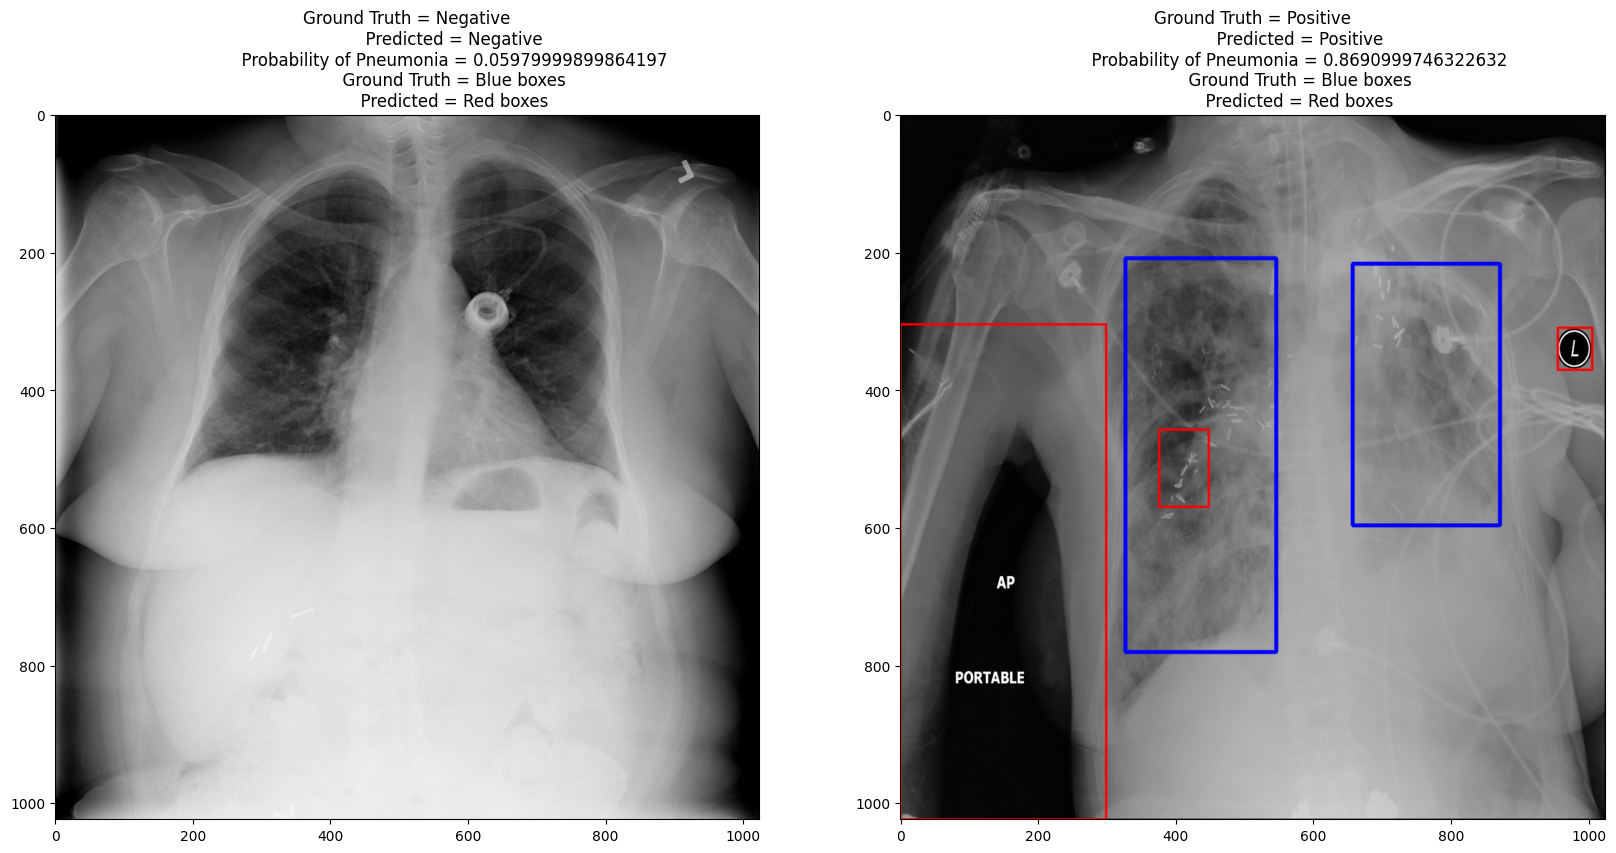

In [ ]:
# selecting a random image to test
test_img_dir = r'test_img_dir'
if os.path.exists(test_img_dir)==False:
  os.mkdir(test_img_dir)
threshold_rcnn = 0.98
PROD_THRESHOLD = 0.5
fig, ax = plt.subplots(1,2,figsize=(20,10))

for ax_cnt,patientId in enumerate(list_patientId):
  actual_target = df_train_data.loc[df_train_data.patientId==patientId,'Target'].values[0]
  jpg_file_path = df_train_data.loc[df_train_data.patientId==patientId,'jpg_file_path'].values[0]

  test_ds = make_dataset_inception_v3(df_train_data.loc[df_train_data.patientId==patientId,'jpg_file_path'].values,
                                      np.zeros(1),img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)




  y_test_probs_img = model_bin_cls.predict(test_ds)
  y_test_pred_img = (y_test_probs_img >= PROD_THRESHOLD).astype(int)

  input_image = cv2.imread(jpg_file_path)



  if y_test_pred_img[0][0] == 1:

    cv2.setUseOptimized(True);
    ss_object = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    ss_object.setBaseImage(input_image)
    ss_object.switchToSelectiveSearchFast()
    rects = ss_object.process()

    boxes = [{'x1':x,'y1':y,'x2':x+w,'y2':y+h} for (x, y, w, h) in rects]

    test_regions_img = []
    for i,bb_cand in enumerate(boxes):
      region_img = input_image[bb_cand['y1']:bb_cand['y2'],bb_cand['x1']:bb_cand['x2']]
      resized_image = cv2.resize(region_img, (resize_width,resize_height), interpolation = cv2.INTER_AREA)
      file_path = os.path.join(test_img_dir,patientId+'_'+str(i)+'.jpg')
      test_regions_img.append(file_path)
      cv2.imwrite(file_path, resized_image)

    test_ds_1 = make_dataset_mobileNetv2_rcnn(test_regions_img,np.zeros(len(test_regions_img)),img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
    y_test = []
    for _, (_, labels) in enumerate(test_ds_1):
        y_test.append(labels.numpy())
    y_test = np.concatenate(y_test)

    y_test_probs = model_rcnn.predict(test_ds_1)

    test_prd_df = pd.DataFrame({'box':boxes,
                                'y_test_prob':y_test_probs.flatten()})
    predicted_boxes = test_prd_df.loc[test_prd_df.y_test_prob>threshold_rcnn,:].sort_values(by=['y_test_prob'],ascending=False).head(20).loc[:,'box']

    cand_boxes = [[bx['x1'], bx['y1'], bx['x2'], bx['y2']] for bx in predicted_boxes]

    nms_boxes_indx = cv2.dnn.NMSBoxes(cand_boxes, [1]*len(cand_boxes), score_threshold=0, nms_threshold=0.5)

    nms_boxes = np.asarray(cand_boxes)[nms_boxes_indx]
    for _, rect in (enumerate(nms_boxes)):
      cv2.rectangle(input_image, (rect[0], rect[1]), (rect[2], rect[3]), (255, 0, 0), 2, cv2.LINE_AA)


  if actual_target == 1:
    boundBoxes = df_train_data.loc[df_train_data.patientId ==patientId ,['x','y','width','height']]
    for _,box in boundBoxes.iterrows():
      x1 = int(box['x'])
      y1 = int(box['y'])
      x2 = x1 + int(box['width'])
      y2 = y1 + int(box['height'])
      cv2.rectangle(input_image,(x1,y1),(x2,y2),(0,0,255), 3, cv2.LINE_AA)


  ax[ax_cnt].imshow(input_image, cmap = plt.cm.bone)
  ax[ax_cnt].set_title(f"Ground Truth = {'Positive' if actual_target==1 else 'Negative'}\n\
                  Predicted = {'Positive' if y_test_pred_img[0][0]==1 else 'Negative'}\n\
                  Probability of Pneumonia = {round(y_test_probs_img[0][0],4)}\n\
                  Ground Truth = Blue boxes\n\
                  Predicted = Red boxes")

plt.show()



1/1 [==============================] - 0s 43ms/step


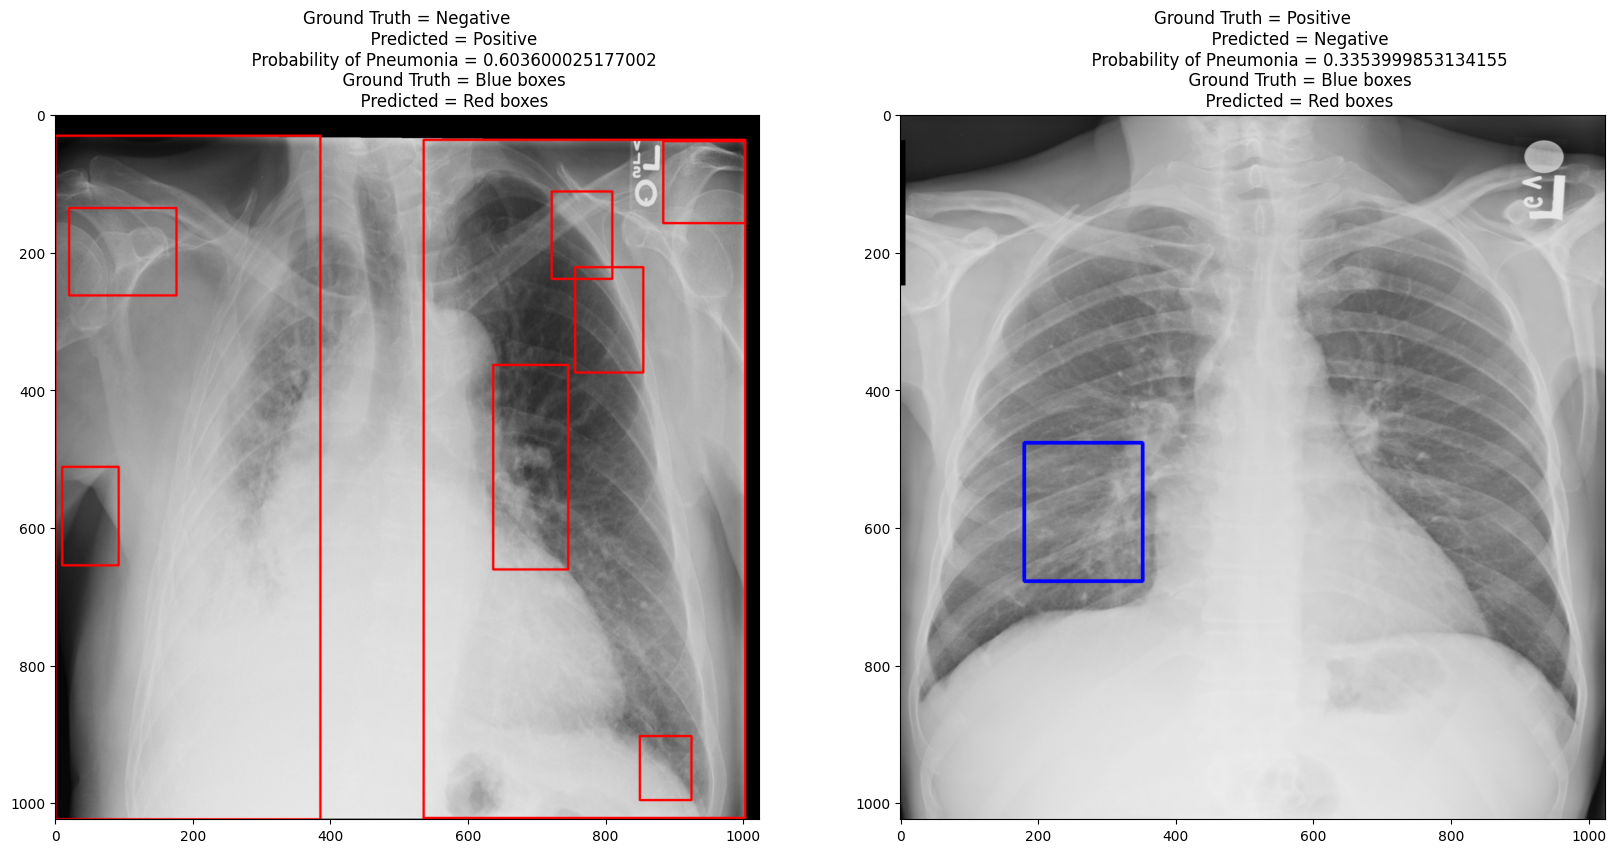

In [19]:
temp = df_train_data.loc[df_train_data.patientId.isin(x_test.apply(lambda x: x.split('/')[-1].split('.')[0])),:].drop_duplicates('patientId')
list_patientId = [temp.loc[temp.Target==0,'patientId'].sample(1).values[0],
                  temp.loc[temp.Target==1,'patientId'].sample(1).values[0]]
# selecting a random image to test
test_img_dir = r'test_img_dir'
if os.path.exists(test_img_dir)==False:
  os.mkdir(test_img_dir)
threshold_rcnn = 0.98
PROD_THRESHOLD = 0.5
fig, ax = plt.subplots(1,2,figsize=(20,10))

for ax_cnt,patientId in enumerate(list_patientId):
  actual_target = df_train_data.loc[df_train_data.patientId==patientId,'Target'].values[0]
  jpg_file_path = df_train_data.loc[df_train_data.patientId==patientId,'jpg_file_path'].values[0]

  test_ds = make_dataset_inception_v3(df_train_data.loc[df_train_data.patientId==patientId,'jpg_file_path'].values,
                                      np.zeros(1),img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)




  y_test_probs_img = model_bin_cls.predict(test_ds)
  y_test_pred_img = (y_test_probs_img >= PROD_THRESHOLD).astype(int)

  input_image = cv2.imread(jpg_file_path)



  if y_test_pred_img[0][0] == 1:

    cv2.setUseOptimized(True);
    ss_object = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    ss_object.setBaseImage(input_image)
    ss_object.switchToSelectiveSearchFast()
    rects = ss_object.process()

    boxes = [{'x1':x,'y1':y,'x2':x+w,'y2':y+h} for (x, y, w, h) in rects]

    test_regions_img = []
    for i,bb_cand in enumerate(boxes):
      region_img = input_image[bb_cand['y1']:bb_cand['y2'],bb_cand['x1']:bb_cand['x2']]
      resized_image = cv2.resize(region_img, (resize_width,resize_height), interpolation = cv2.INTER_AREA)
      file_path = os.path.join(test_img_dir,patientId+'_'+str(i)+'.jpg')
      test_regions_img.append(file_path)
      cv2.imwrite(file_path, resized_image)

    test_ds_1 = make_dataset_mobileNetv2_rcnn(test_regions_img,np.zeros(len(test_regions_img)),img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True, no_channels=3)
    y_test = []
    for _, (_, labels) in enumerate(test_ds_1):
        y_test.append(labels.numpy())
    y_test = np.concatenate(y_test)

    y_test_probs = model_rcnn.predict(test_ds_1)

    test_prd_df = pd.DataFrame({'box':boxes,
                                'y_test_prob':y_test_probs.flatten()})
    predicted_boxes = test_prd_df.loc[test_prd_df.y_test_prob>threshold_rcnn,:].sort_values(by=['y_test_prob'],ascending=False).head(20).loc[:,'box']

    cand_boxes = [[bx['x1'], bx['y1'], bx['x2'], bx['y2']] for bx in predicted_boxes]

    nms_boxes_indx = cv2.dnn.NMSBoxes(cand_boxes, [1]*len(cand_boxes), score_threshold=0, nms_threshold=0.5)

    nms_boxes = np.asarray(cand_boxes)[nms_boxes_indx]
    for _, rect in (enumerate(nms_boxes)):
      cv2.rectangle(input_image, (rect[0], rect[1]), (rect[2], rect[3]), (255, 0, 0), 2, cv2.LINE_AA)


  if actual_target == 1:
    boundBoxes = df_train_data.loc[df_train_data.patientId ==patientId ,['x','y','width','height']]
    for _,box in boundBoxes.iterrows():
      x1 = int(box['x'])
      y1 = int(box['y'])
      x2 = x1 + int(box['width'])
      y2 = y1 + int(box['height'])
      cv2.rectangle(input_image,(x1,y1),(x2,y2),(0,0,255), 3, cv2.LINE_AA)


  ax[ax_cnt].imshow(input_image, cmap = plt.cm.bone)
  ax[ax_cnt].set_title(f"Ground Truth = {'Positive' if actual_target==1 else 'Negative'}\n\
                  Predicted = {'Positive' if y_test_pred_img[0][0]==1 else 'Negative'}\n\
                  Probability of Pneumonia = {round(y_test_probs_img[0][0],4)}\n\
                  Ground Truth = Blue boxes\n\
                  Predicted = Red boxes")

plt.show()

#### Mask RCNN using UNET

We will generate Mask RCNN using the following steps
1.	Generate ground truth mask.
2.	Develop a UNET architecture – using pretrained encoder of mobile net, decoder of mobile net and followed by a fully connected NN.
3.	Will use this UNET to build classifier will a loss function of DICE loss.



In [22]:
mask_fldr = r'JPG_FILES_GRAY_MASK'
os.mkdir(mask_fldr)

In [23]:
# create mask for all images
mask_fldr = r'/content/JPG_FILES_GRAY_MASK'
def createMask(patientId):
  global df_train_data
  df = df_train_data.loc[df_train_data.patientId==patientId, ['x','y','width','height','Target','jpg_file_path']].copy(deep=True)
  if df.Target.values[0] == 0:
     img = cv2.imread(df.jpg_file_path.values[0], cv2.IMREAD_GRAYSCALE)
     mask = np.zeros((img.shape[0], img.shape[1]), np.float32)

  else:
    img = cv2.imread(df.jpg_file_path.values[0], cv2.IMREAD_GRAYSCALE)
    mask = np.zeros((img.shape[0], img.shape[1]), np.float32)

    for _,box in df.iterrows():
      x1 = int(box['x'])
      y1 = int(box['y'])
      x2 = x1 + int(box['width'])
      y2 = y1 + int(box['height'])
      mask[y1:y2,x1:x2] = np.float32(1)

  # imgMask = img*mask
  msk_file = os.path.join(mask_fldr,patientId+'.jpg')
  cv2.imwrite(msk_file,mask)
  return msk_file

df_train_data['mask_jpg_file'] = df_train_data.patientId.drop_duplicates().progress_apply(lambda x: createMask(x))

100%|██████████| 26684/26684 [09:55<00:00, 44.78it/s]


In [24]:
# creating a UNET with encoder network as pre trained Mobile net
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import UpSampling2D, Concatenate
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
def create_model(trainable=False,IMAGE_HEIGHT=224,IMAGE_WIDTH=224 ):
  global ALPHA
  tf.keras.backend.clear_session()
  gc.collect()
  # getting the left hand side of the UNet as the Mobilenet pre trained encoder
  inputs = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name="input_image")
  encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=ALPHA)

  for layer in encoder.layers:
        layer.trainable = trainable


  # getting the
  encoder_output = encoder.get_layer('block_13_expand_relu').output # 14*14

  skip_connection_28 = encoder.get_layer('block_6_expand_relu').output # 28*28
  skip_connection_56 = encoder.get_layer('block_3_expand_relu').output # 56*56
  skip_connection_112 = encoder.get_layer('block_1_expand_relu').output # 112*112
  skip_connection_224 = encoder.get_layer('input_image').output # 224*244

  # bridge layer
  x = UpSampling2D((2,2))(encoder_output)
  x = Concatenate()([x, skip_connection_28])

  x = Conv2D(64,(3,3),padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(64,(3,3),padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  # 1st from bottom skip connection layer
  x = UpSampling2D((2,2))(x)
  x = Concatenate()([x, skip_connection_56])

  x = Conv2D(48,(3,3),padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(48,(3,3),padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  # 2nd from bottom skip connection layer
  x = UpSampling2D((2,2))(x)
  x = Concatenate()([x, skip_connection_112])

  x = Conv2D(32,(3,3),padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(32,(3,3),padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  # top  skip connection layer
  x = UpSampling2D((2,2))(x)
  x = Concatenate()([x, skip_connection_224])

  x = Conv2D(16,(3,3),padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(16,(3,3),padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  # final layer.
  x = Conv2D(1,(1,1),padding="same")(x)
  x = Activation("sigmoid")(x)

  model = Model(inputs, x)

  return model

model = create_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_image[0][0]']         
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [25]:
# defining dice coff and loss function
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    numerator = tf.reduce_sum(y_true * y_pred)
    return (2. * numerator ) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [26]:
# defining data set creation function
def make_dataset_rcnn(x_file_list, y_file_list, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, batch_size = BATCH_SIZE, do_resize=True):
  '''
  this method will make the dataset from file path list.
  '''
  def preprocess_image(fl_path, label):
      # print(fl_path)
      image_raw = tf.io.read_file(fl_path)
      image = tf.io.decode_jpeg(image_raw, channels=int(3))

      if do_resize:
        image = tf.image.resize(image, (img_width,img_height))

      image = preprocess_input(image)

      label_img = tf.io.read_file(label)
      label_img = tf.io.decode_jpeg(label_img, channels=int(1))

      if do_resize:
        label_img = tf.image.resize(label_img, (img_width,img_height))

      return image, label_img

  file_list_dataset = tf.data.Dataset.from_tensor_slices(x_file_list)
  y_dataset = tf.data.Dataset.from_tensor_slices(y_file_list)
  dataset = tf.data.Dataset.zip((file_list_dataset, y_dataset))
  dataset = dataset.map(preprocess_image)
  dataset = dataset.batch(batch_size)
  return dataset

In [27]:
#dividing dataset into train, test and validation
data = df_train_data.drop_duplicates(subset=['patientId'])[['jpg_file_path','Target','patientId','mask_jpg_file']]
y = data.Target
train_data, test_data, y_train, y_test = train_test_split(data, y, test_size=0.2, stratify=y, random_state=SEED_VAL)
val_data, test_data, y_val, y_test = train_test_split(test_data, y_test, test_size=0.5, stratify= y_test, random_state= SEED_VAL)

In [28]:
x_train = train_data.jpg_file_path
y_train = train_data.mask_jpg_file

x_val = val_data.jpg_file_path
y_val = val_data.mask_jpg_file

x_test = test_data.jpg_file_path
y_test = test_data.mask_jpg_file

In [29]:
#creating configuration params
itr = 40
max_epoch = 20
lr = 0.0001
batch_size = 16
resize_width = 224
resize_height = 224
input_shape = (resize_width,resize_height,3)


train_ds = make_dataset_rcnn(x_train, y_train,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True)
val_ds = make_dataset_rcnn(x_val,y_val,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True)
test_ds = make_dataset_rcnn(x_test,y_test,img_width=resize_width, img_height=resize_height, batch_size = batch_size,do_resize = True)

name = 'rcnn_model'
ver_fl_name = name +'_'+str(itr)+'.h5'
his_fl_name = name  +'_'+str(itr)+'_history.pkl'
fldr_name = r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/'
ver_fl_name = os.path.join(fldr_name,ver_fl_name)
his_fl_name = os.path.join(fldr_name,his_fl_name)

In [ ]:
#training model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

model = create_model(trainable=False,IMAGE_HEIGHT=resize_height,IMAGE_WIDTH=resize_width)

optimizer = Adam(learning_rate=lr)
model.compile(loss=dice_loss,
              optimizer=optimizer,
              metrics=[dice_coef])


callbacks = [
    ModelCheckpoint(ver_fl_name, monitor="val_loss", verbose=0, save_best_only=True, save_weights_only=True),
    EarlyStopping(monitor="val_loss", patience=3,verbose=0),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=0)
]

history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs=max_epoch,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/20
1335/1335 [==============================] - 266s 182ms/step - loss: 0.8402 - dice_coef: 0.1597 - val_loss: 0.7881 - val_dice_coef: 0.2120 - lr: 1.0000e-04
Epoch 2/20
1335/1335 [==============================] - 242s 181ms/step - loss: 0.7237 - dice_coef: 0.2761 - val_loss: 0.6744 - val_dice_coef: 0.3258 - lr: 1.0000e-04
Epoch 3/20
1335/1335 [==============================] - 265s 199ms/step - loss: 0.6154 - dice_coef: 0.3844 - val_loss: 0.6041 - val_dice_coef: 0.3961 - lr: 1.0000e-04
Epoch 4/20
1335/1335 [==============================] - 253s 189ms/step - loss: 0.5553 - dice_coef: 0.4445 - val_loss: 0.5907 - val_dice_coef: 0.4095 - lr: 1.0000e-04
Epoch 5/20
1335/1335 [==============================] - 224s 168ms/step - loss: 0.5254 - dice_coef: 0.4743 - val_loss: 0.5717 - val_dice_coef: 0.4285 - lr: 1.0000e-04
Epoch 6/20
1335/1335 [==============================] - 223s 167ms/step - loss: 0.5082 - dice_coef: 0.4915 - val_loss: 0.5658 - val_dice_coef: 0.4344 - lr: 1.0000e-0

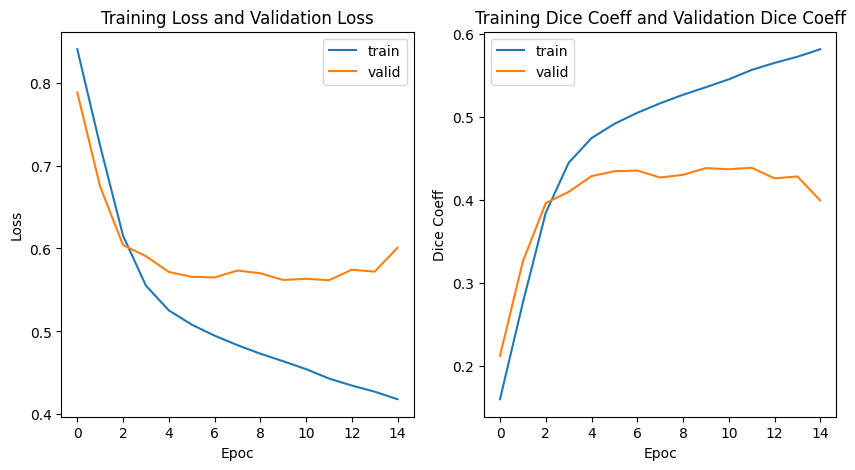

In [ ]:
# ploting history
def plotLoss(history):
  hist  = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig,ax = plt.subplots(1,2, figsize=(10,5), sharex=True)

  # Plotting accuracy at different epochs

  ax[0].plot(hist['loss'])
  ax[0].plot(hist['val_loss'])
  ax[0].legend(("train" , "valid") , loc =0)
  ax[0].set_title('Training Loss and Validation Loss')
  ax[0].set_xlabel('Epoc')
  ax[0].set_ylabel('Loss')


  ax[1].plot(hist['dice_coef'])
  ax[1].plot(hist['val_dice_coef'])
  ax[1].legend(("train" , "valid") , loc =0)
  ax[1].set_title('Training Dice Coeff and Validation Dice Coeff')
  ax[1].set_xlabel('Epoc')
  ax[1].set_ylabel('Dice Coeff')

  plt.show()
plotLoss(history)
pickle.dump(history, open(his_fl_name,'wb'))

* From the above it can be seen that model is stabiling and insignificant variation in validation and training losses.
* there gap between training and validation loss is stabilizing so the overfitting is minimal.


In [30]:
# performing prediction on test data
model.load_weights(ver_fl_name)
y_test_pred = model.predict(test_ds)
mask_pred = np.where(y_test_pred[:,:,:,:]>0.5,1,0)

167/167 [==============================] - 30s 169ms/step


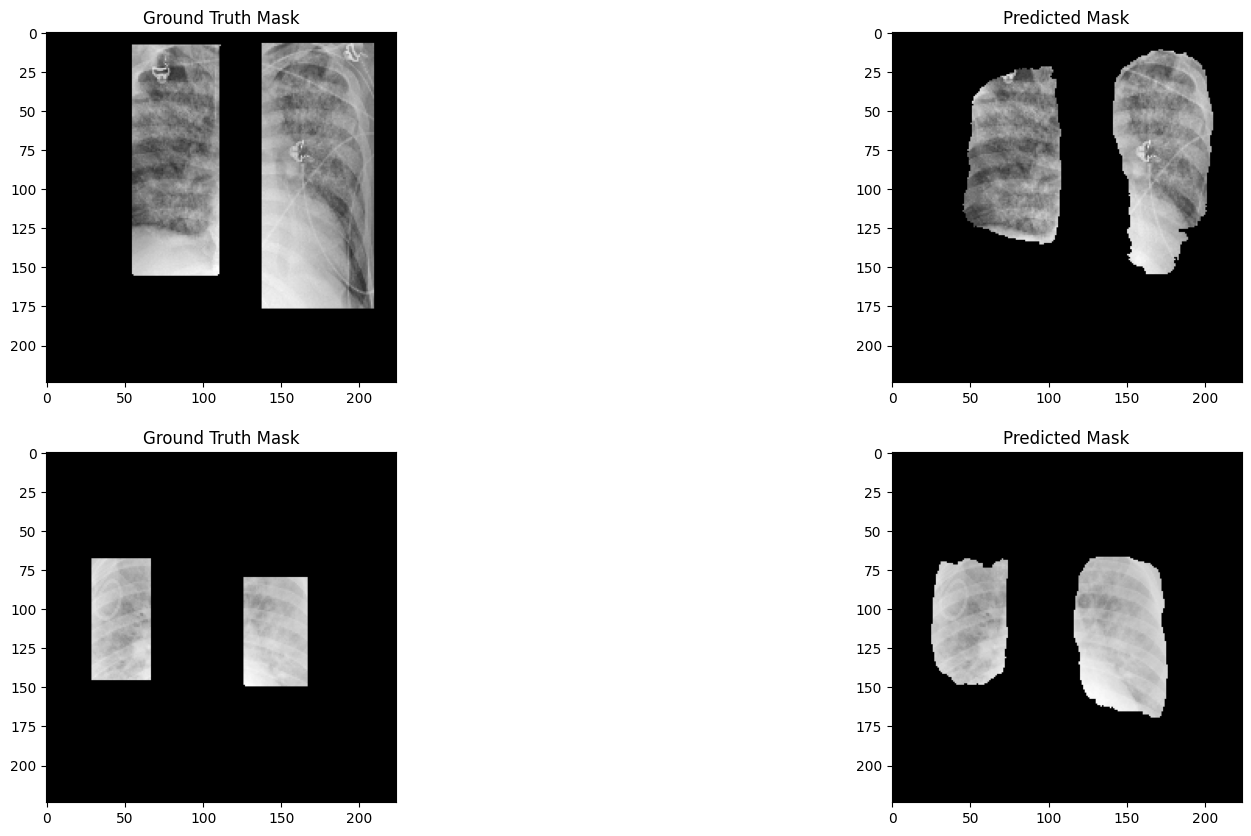

In [ ]:
# doing prediction on +ve samples
patientIdList = [test_data.loc[test_data.Target==1,'patientId'].sample(1).values[0],
            test_data.loc[test_data.Target==1,'patientId'].sample(1).values[0]]
fig,ax = plt.subplots(2,2,figsize=(20,10))

for ax_indx, patientId in enumerate(patientIdList):
  test_data.patientId
  img = cv2.resize(cv2.imread(test_data.loc[test_data.patientId==patientId,'jpg_file_path'].values[0],cv2.IMREAD_GRAYSCALE), (IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_LINEAR)
  mask = cv2.resize(cv2.imread(test_data.loc[test_data.patientId==patientId,'mask_jpg_file'].values[0],cv2.IMREAD_GRAYSCALE), (IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_LINEAR)

  indx = np.where(test_data.patientId==patientId)[0][0]



  ax[ax_indx,0].imshow(img*mask, cmap='gray')
  ax[ax_indx,0].set_title('Ground Truth Mask')
  ax[ax_indx,1].imshow(img*np.squeeze(mask_pred[indx]), cmap='gray')
  ax[ax_indx,1].set_title('Predicted Mask')
plt.show()

**From the above it can be seen the masks predicted are reasonably good predictor of regions where Pnemonia is detected**

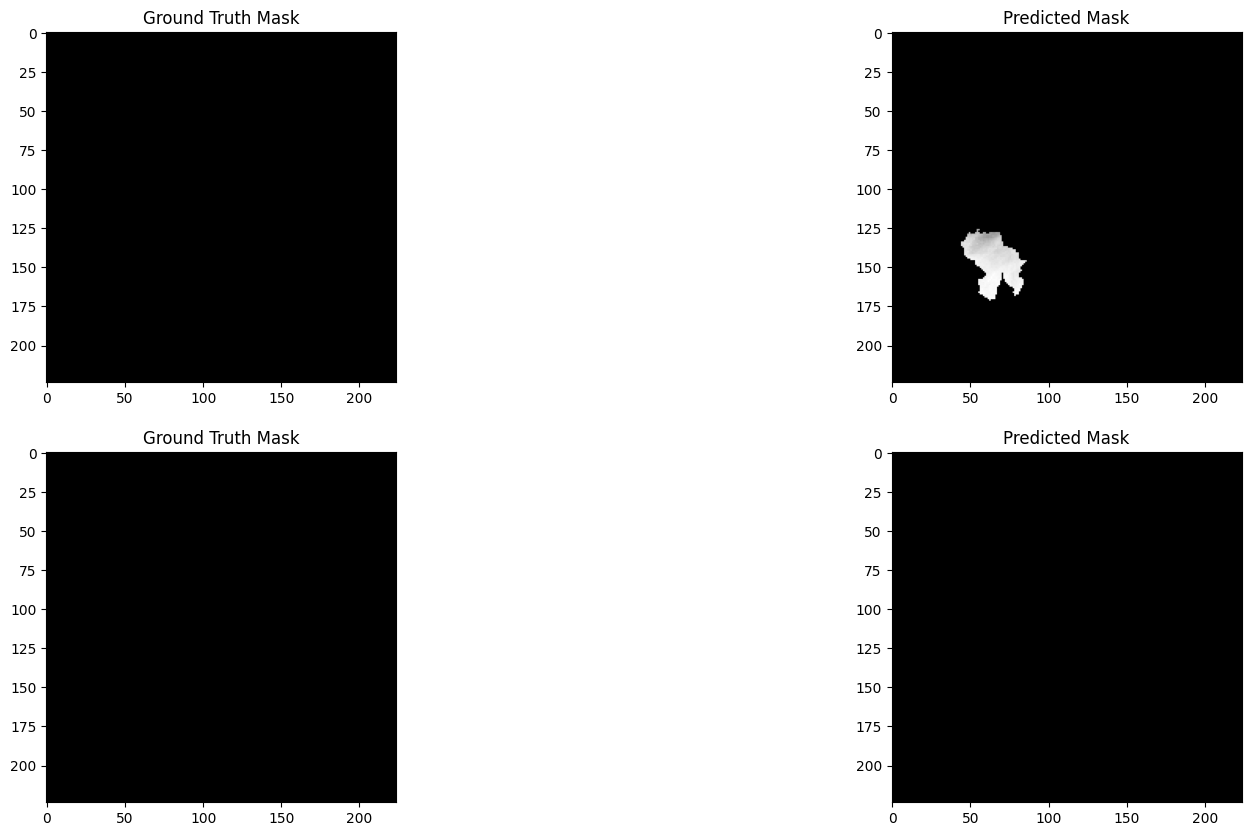

In [ ]:
# doing prediction on -ve samples
patientIdList = [test_data.loc[test_data.Target==0,'patientId'].sample(1).values[0],
            test_data.loc[test_data.Target==0,'patientId'].sample(1).values[0]]
fig,ax = plt.subplots(2,2,figsize=(20,10))

for ax_indx, patientId in enumerate(patientIdList):
  test_data.patientId
  img = cv2.resize(cv2.imread(test_data.loc[test_data.patientId==patientId,'jpg_file_path'].values[0],cv2.IMREAD_GRAYSCALE), (IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_LINEAR)
  mask = cv2.resize(cv2.imread(test_data.loc[test_data.patientId==patientId,'mask_jpg_file'].values[0],cv2.IMREAD_GRAYSCALE), (IMAGE_WIDTH,IMAGE_HEIGHT), interpolation = cv2.INTER_LINEAR)

  indx = np.where(test_data.patientId==patientId)[0][0]



  ax[ax_indx,0].imshow(img*mask, cmap='gray')
  ax[ax_indx,0].set_title('Ground Truth Mask')
  ax[ax_indx,1].imshow(img*np.squeeze(mask_pred[indx]), cmap='gray')
  ax[ax_indx,1].set_title('Predicted Mask')
plt.show()

**From the above it can be seen that in -ve cases, the model works reasonably well and is not detecting any region of infection and in one case detecting a small region of infection.**

**Since this is a medical application, i think it a good model as it is conservative and its predicting in places where there may be little chance of occurrence of pneumonia, which can be corrected by subsequent doctor review.**

In [ ]:
y_test = []
for _, (_, labels) in enumerate(test_ds):
        y_test.append(labels.numpy())
y_test = np.concatenate(y_test)

In [ ]:
def dice_coef_1(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    numerator = (y_true * y_pred).sum()
    return (2. * numerator ) / (y_true.sum() + y_pred.sum() + tf.keras.backend.epsilon())
dice_coff = []
for y_true,y_pred in zip(y_test, mask_pred):
  dice_coff.append(dice_coef_1(y_true,y_pred))


In [ ]:
print(f'Mean dice coff. for all test set is {np.mean(dice_coff)}')

Mean dice coff. for all test set is 0.11477134081791018


## Step 4: Pickle the model for future prediction [ 3 Points]

There are 3 models that we will save
1.	Binary classifier to classify Xray into +ve or -ve pneumonia
2.	RCNN binary classifier to classify image regions to if the regions is a infected region or not
3.	UNET based Mask RCNN model

In [34]:
pickle.dump(model_bin_cls,open(r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/model_bin_cls.pkl', 'wb'))
pickle.dump(model_rcnn,open(r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/model_rcnn.pkl', 'wb'))
pickle.dump(model,open(r'/content/drive/MyDrive/AI ML GreatLearning/Capstone Project/PnemoniaDetection_Capstore_project/model_unet.pkl', 'wb'))